# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 # 4 hours / 72*5min = 6 hours used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 32
TRAIN_SPLIT_RATIO = 0.8 #0.9891 # 1-(60/5*24)/50977
MODE_TRAIN_AE = False # True # False
MODE_AUTO_SELECT = 2 #1  #0 # 0: False, 1: True, 2: from disk

MODE_TRAIN_PREDICTOR = False #True

MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_92400/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
67666  1692831000000   1675.99   1676.50  1675.23    1675.24    365.8599   
67667  1692831300000   1675.23   1676.54  1675.23    1676.19    367.3257   
67668  1692831600000   1676.19   1677.00  1675.22    1676.42    298.2720   
67669  1692831900000   1676.42   1678.43  1676.41    1677.59    380.8305   
67670  1692832200000   1677.58   1677.59  1677.50    1677.51     19.6382   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1751.679883       1751.147585   
1      2023-01-01 00:05:00       1751.679883       1751.147585   
2      2023-01-01 00:10:00       1751.679883       1751.147585   
3      2023-01-01 00:15:00       1751.679883       1751.147585   
4      2023-01-01 00:20:00       1751.679883       1751.147585   
...                    ...               ...               ...   
67666  2023-08-23 22:50:00       1687.875000       1688.205000   
67667  2023-08-23 22:55:00       1688.547500       1688.905000   
67668  2023-08-23 23:00:00       1688.547500       1689.495000   
67669  2023-08-23 23:05:00       1688.572500       1689.495000   
67670  2023-08-23 23:10:00       1688.825000       1689.495000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
67666        1674.585  ...   NaN         NaN            NaN           NaN   
67667        1673.500  ...   NaN         NaN            NaN           NaN   
67668        1673.250  ...   NaN         NaN            NaN           NaN   
67669        1672.780  ...   NaN         NaN            NaN           NaN   
67670        1672.780  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
67666               NaN         0.0               NaN         0.0      0.0   
67667               NaN         0.0               NaN         0.0      0.0   
67668               NaN         0.0               NaN         0.0      0.0   
67669               NaN         0.0               NaN         0.0      0.0   
67670               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
67666   NaN  
67667   NaN  
67668   NaN  
67669   NaN  
67670   NaN  

[67671 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_BTC            1
vwap_z_score_ETH            1
ichi_tenkan_BTC             8
ichi_tenkan_ETH             8
min_low_h_BTC              13
rsi_h_BTC                  13
max_high_h_ETH             13
min_low_h_ETH              13
rsi_h_ETH                  13
max_high_h_BTC             13
chop_h_BTC                 14
chop_h_ETH                 14
ichi_cloud_a_ETH           25
ichi_kijun_ETH             25
ichi_kijun_BTC             25
ichi_cloud_a_BTC           25
ichi_tenkan_day_BTC       215
ichi_tenkan_day_ETH       215
dxy                       264
rsi_d_ETH                 335
min_low_d_BTC             335
rsi_d_BTC                 335
max_high_d_ETH            335
min_low_d_ETH             335
max_high_d_BTC            335
chop_d_ETH                335
chop_d_BTC                335
ichi_kijun_day_ETH        623
ichi_cloud_a_day_ETH      623
ichi_kijun_day_BTC        623
ichi_cloud_a_day_BTC      623
fvx                       732
spx                     

#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
67666  1692831000000   1675.99   1676.50  1675.23    1675.24    365.8599   
67667  1692831300000   1675.23   1676.54  1675.23    1676.19    367.3257   
67668  1692831600000   1676.19   1677.00  1675.22    1676.42    298.2720   
67669  1692831900000   1676.42   1678.43  1676.41    1677.59    380.8305   
67670  1692832200000   1677.58   1677.59  1677.50    1677.51     19.6382   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1751.679883       1751.147585   
1      2023-01-01 00:05:00       1751.679883       1751.147585   
2      2023-01-01 00:10:00       1751.679883       1751.147585   
3      2023-01-01 00:15:00       1751.679883       1751.147585   
4      2023-01-01 00:20:00       1751.679883       1751.147585   
...                    ...               ...               ...   
67666  2023-08-23 22:50:00       1687.875000       1688.205000   
67667  2023-08-23 22:55:00       1688.547500       1688.905000   
67668  2023-08-23 23:00:00       1688.547500       1689.495000   
67669  2023-08-23 23:05:00       1688.572500       1689.495000   
67670  2023-08-23 23:10:00       1688.825000       1689.495000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...   1.0         0.0            0.0           0.0   
1            1194.710  ...   1.0         0.0            0.0           0.0   
2            1194.710  ...   1.0         0.0            0.0           0.0   
3            1194.710  ...   1.0         0.0            0.0           0.0   
4            1194.710  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
67666        1674.585  ...   NaN         NaN            NaN           NaN   
67667        1673.500  ...   NaN         NaN            NaN           NaN   
67668        1673.250  ...   NaN         NaN            NaN           NaN   
67669        1672.780  ...   NaN         NaN            NaN           NaN   
67670        1672.780  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
67666               NaN         0.0               NaN         0.0      0.0   
67667               NaN         0.0               NaN         0.0      0.0   
67668               NaN         0.0               NaN         0.0      0.0   
67669               NaN         0.0               NaN         0.0      0.0   
67670               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
67666                  NaN  
67667                  NaN  
67668                  NaN  
67669                  NaN  
67670                  NaN  

[67671 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       3578
delta_event_real    3578
delta_event_pred    3578
Previous_num        3578
Actual_num          3578
Event               3578
Date                3578
Previous            3578
Consensus           3578
Actual              3578
Country             3578
Time (ET)           3578
keep                3578
date                3578
dtype: int64

on 67671 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
67666   1675.99   1676.50  1675.23    1675.24    365.8599   
67667   1675.23   1676.54  1675.23    1676.19    367.3257   
67668   1676.19   1677.00  1675.22    1676.42    298.2720   
67669   1676.42   1678.43  1676.41    1677.59    380.8305   
67670   1677.58   1677.59  1677.50    1677.51     19.6382   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1751.679883       1751.147585   
1      2023-01-01 00:05:00       1751.679883       1751.147585   
2      2023-01-01 00:10:00       1751.679883       1751.147585   
3      2023-01-01 00:15:00       1751.679883       1751.147585   
4      2023-01-01 00:20:00       1751.679883       1751.147585   
...                    ...               ...               ...   
67666  2023-08-23 22:50:00       1687.875000       1688.205000   
67667  2023-08-23 22:55:00       1688.547500       1688.905000   
67668  2023-08-23 23:00:00       1688.547500       1689.495000   
67669  2023-08-23 23:05:00       1688.572500       1689.495000   
67670  2023-08-23 23:10:00       1688.825000       1689.495000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0            1194.710         1194.710  ...  1196.096667  1196.096667   
1            1194.710         1194.710  ...  1195.801420  1195.801420   
2            1194.710         1194.710  ...  1195.648641  1195.648641   
3            1194.710         1194.710  ...  1195.575250  1195.575250   
4            1194.710         1194.710  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
67666        1674.585         1675.705  ...  1738.142208  1838.102475   
67667        1673.500         1675.720  ...  1738.130006  1838.094120   
67668        1673.250         1676.145  ...  1738.123307  1838.086161   
67669        1672.780         1676.145  ...  1738.115366  1838.078511   
67670        1672.780         1676.485  ...  1738.112394  1838.075318   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
67666  1829.848191  1777.878085   1732.162562         -0.326426 -0.033979   
67667  1829.845861  1777.865534   1732.162348         -0.320979 -0.033393   
67668  1829.843177  1777.850171   1732.162176         -0.319661 -0.033251   
67669  1829.840742  1777.839394   1732.161960         -0.312952 -0.032530   
67670  1829.840274  1777.827264   1732.161949         -0.313413 -0.032579   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.205254e+08      522461.0       17.891060  
1      1.205254e+08      522461.0       17.891060  
2      1.205254e+08      522461.0       17.891060  
3      1.205254e+08      522461.0       17.891060  
4      1.205254e+08      522461.0       17.891060  
...             ...           ...             ...  
67666  1.202143e+08      412244.0       18.312317  
67667  1.202143e+08      412244.0       18.312317  
67668  1.202143e+08      412244.0       18.312317  
67669  1.202143e+08      412244.0       18.312317  
67670  1.202143e+08      412244.0       18.312317  

[67671 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [21]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0      3.910  3823.179932  103.494003
1      3.910  3823.179932  103.494003
2      3.910  3823.179932  103.494003
3      3.910  3823.179932  103.494003
4      3.910  3823.179932  103.494003
...      ...          ...         ...
67666  4.361  4436.009766  103.361000
67667  4.361  4436.009766  103.361000
67668  4.361  4436.009766  103.361000
67669  4.361  4436.009766  103.361000
67670  4.361  4436.009766  103.361000

[67671 rows x 3 columns]

In [22]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [23]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [24]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [25]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  102


In [26]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [27]:
df_feat.shape[0]

67671

In [28]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

54137

In [29]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
67666  1692831000000   1675.99   1676.50  1675.23    1675.24    365.8599   
67667  1692831300000   1675.23   1676.54  1675.23    1676.19    367.3257   
67668  1692831600000   1676.19   1677.00  1675.22    1676.42    298.2720   
67669  1692831900000   1676.42   1678.43  1676.41    1677.59    380.8305   
67670  1692832200000   1677.58   1677.59  1677.50    1677.51     19.6382   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1751.679883       1751.147585   
1      2023-01-01 00:05:00       1751.679883       1751.147585   
2      2023-01-01 00:10:00       1751.679883       1751.147585   
3      2023-01-01 00:15:00       1751.679883       1751.147585   
4      2023-01-01 00:20:00       1751.679883       1751.147585   
...                    ...               ...               ...   
67666  2023-08-23 22:50:00       1687.875000       1688.205000   
67667  2023-08-23 22:55:00       1688.547500       1688.905000   
67668  2023-08-23 23:00:00       1688.547500       1689.495000   
67669  2023-08-23 23:05:00       1688.572500       1689.495000   
67670  2023-08-23 23:10:00       1688.825000       1689.495000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
67666        1674.585  ...         NaN            NaN           NaN   
67667        1673.500  ...         NaN            NaN           NaN   
67668        1673.250  ...         NaN            NaN           NaN   
67669        1672.780  ...         NaN            NaN           NaN   
67670        1672.780  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
67666               NaN         0.0               NaN         0.0      0.0   
67667               NaN         0.0               NaN         0.0      0.0   
67668               NaN         0.0               NaN         0.0      0.0   
67669               NaN         0.0               NaN         0.0      0.0   
67670               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
67666                  NaN  False  
67667                  NaN  False  
67668                  NaN  False  
67669                  NaN  False  
67670                  NaN  False  

[67671 rows x 136 columns]

In [30]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
54133  1688771100000   1868.72   1869.34  1868.72    1869.33    177.7769   
54134  1688771400000   1869.33   1869.34  1869.19    1869.20     60.8223   
54135  1688771700000   1869.19   1869.20  1868.35    1869.03    137.5554   
54136  1688772000000   1869.02   1869.23  1868.67    1869.22    175.3781   
54137  1688772300000   1869.23   1869.39  1869.22    1869.39    140.9896   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1751.679883       1751.147585   
1      2023-01-01 00:05:00       1751.679883       1751.147585   
2      2023-01-01 00:10:00       1751.679883       1751.147585   
3      2023-01-01 00:15:00       1751.679883       1751.147585   
4      2023-01-01 00:20:00       1751.679883       1751.147585   
...                    ...               ...               ...   
54133  2023-07-07 23:05:00       1863.247500       1864.895000   
54134  2023-07-07 23:10:00       1863.705000       1864.895000   
54135  2023-07-07 23:15:00       1864.025000       1864.895000   
54136  2023-07-07 23:20:00       1865.952500       1864.895000   
54137  2023-07-07 23:25:00       1865.952500       1864.895000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
54133        1868.715  ...         4.8            5.0           5.3   
54134        1868.910  ...         4.8            5.0           5.3   
54135        1868.910  ...         4.8            5.0           5.3   
54136        1868.910  ...         4.8            5.0           5.3   
54137        1868.910  ...         4.8            5.0           5.3   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
54133               0.3         0.0               0.2         0.0      0.0   
54134               0.3         0.0               0.2         0.0      0.0   
54135               0.3         0.0               0.2         0.0      0.0   
54136               0.3         0.0               0.2         0.0      0.0   
54137               0.3         0.0               0.2         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
54133  2023-07-12 13:00:00   True  
54134  2023-07-12 13:00:00   True  
54135  2023-07-12 13:00:00   True  
54136  2023-07-12 13:00:00   True  
54137  2023-07-12 13:00:00   True  

[54138 rows x 136 columns]

In [31]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
54138  1688772600000   1869.39   1869.43  1868.00    1868.20    139.3711   
54139  1688772900000   1868.21   1868.69  1867.53    1868.68    210.6366   
54140  1688773200000   1868.68   1869.83  1868.68    1869.82    240.7722   
54141  1688773500000   1869.83   1869.83  1868.03    1869.09    234.3773   
54142  1688773800000   1869.08   1870.01  1869.08    1870.00    164.8892   
...              ...       ...       ...      ...        ...         ...   
67666  1692831000000   1675.99   1676.50  1675.23    1675.24    365.8599   
67667  1692831300000   1675.23   1676.54  1675.23    1676.19    367.3257   
67668  1692831600000   1676.19   1677.00  1675.22    1676.42    298.2720   
67669  1692831900000   1676.42   1678.43  1676.41    1677.59    380.8305   
67670  1692832200000   1677.58   1677.59  1677.50    1677.51     19.6382   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
54138  2023-07-07 23:30:00         1866.3075          1864.235   
54139  2023-07-07 23:35:00         1867.0825          1864.145   
54140  2023-07-07 23:40:00         1867.1100          1864.145   
54141  2023-07-07 23:45:00         1867.2900          1864.060   
54142  2023-07-07 23:50:00         1867.7800          1864.060   
...                    ...               ...               ...   
67666  2023-08-23 22:50:00         1687.8750          1688.205   
67667  2023-08-23 22:55:00         1688.5475          1688.905   
67668  2023-08-23 23:00:00         1688.5475          1689.495   
67669  2023-08-23 23:05:00         1688.5725          1689.495   
67670  2023-08-23 23:10:00         1688.8250          1689.495   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
54138        1868.910  ...         4.8            5.0           5.3   
54139        1868.490  ...         4.8            5.0           5.3   
54140        1868.465  ...         4.8            5.0           5.3   
54141        1868.465  ...         4.8            5.0           5.3   
54142        1868.465  ...         4.8            5.0           5.3   
...               ...  ...         ...            ...           ...   
67666        1674.585  ...         NaN            NaN           NaN   
67667        1673.500  ...         NaN            NaN           NaN   
67668        1673.250  ...         NaN            NaN           NaN   
67669        1672.780  ...         NaN            NaN           NaN   
67670        1672.780  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
54138               0.3         0.0               0.2         0.0      0.0   
54139               0.3         0.0               0.2         0.0      0.0   
54140               0.3         0.0               0.2         0.0      0.0   
54141               0.3         0.0               0.2         0.0      0.0   
54142               0.3         0.0               0.2         0.0      0.0   
...                 ...         ...               ...         ...      ...   
67666               NaN         0.0               NaN         0.0      0.0   
67667               NaN         0.0               NaN         0.0      0.0   
67668               NaN         0.0               NaN         0.0      0.0   
67669               NaN         0.0               NaN         0.0      0.0   
67670               NaN         0.0               NaN         0.0      0.0   

                      date  train  
54138  2023-07-12 13:00:00  False  
54139  2023-07-12 13:00:00  False  
54140  2023-07-12 13:00:00  False  
54141  2023-07-12 13:00:00  False  
54142  2023-07-12 13:00:00  False  
...                    ...    ...  
67666                  NaN  False  
67667                  NaN  False  
67668                  NaN  False  
67669                  NaN  False  
67670                  NaN  False  

[13533 rows x 136 columns]

In [32]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [33]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [34]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [35]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(54051, 72, 102) (54051, 15)
(13446, 72, 102) (13446, 15)


In [36]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [37]:
seq_y

array([0.99983957, 0.99985561, 0.99951335, 0.99949731, 0.99956148,
       0.99793041, 0.99862562, 0.99885023, 0.99947592, 0.99887162,
       0.99934757, 0.99967379, 0.99960427, 0.99951335, 0.99961496])

In [38]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00028363, 1.0007064 , 1.00054586, ..., 1.00005352, 1.00037996,
        1.00031039],
       [1.00042265, 1.00026215, 1.0002782 , ..., 1.0000963 , 1.00002675,
        0.9999358 ],
       [0.99983957, 0.99985561, 0.99951335, ..., 0.99960427, 0.99951335,
        0.99961496]])

In [39]:
seq_y

array([0.99983957, 0.99985561, 0.99951335, 0.99949731, 0.99956148,
       0.99793041, 0.99862562, 0.99885023, 0.99947592, 0.99887162,
       0.99934757, 0.99967379, 0.99960427, 0.99951335, 0.99961496])

In [40]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00028363, 1.0007064 , 1.00054586, ..., 1.00005352, 1.00037996,
        1.00031039],
       [1.00042265, 1.00026215, 1.0002782 , ..., 1.0000963 , 1.00002675,
        0.9999358 ],
       [0.99983957, 0.99985561, 0.99951335, ..., 0.99960427, 0.99951335,
        0.99961496]])

In [41]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [42]:
X_train.shape

(54051, 72, 102)

In [43]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(54051, 72, 102) (54051, 15)
(13446, 72, 102) (13446, 15)


## Standardization

In [44]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

Load standardization from disk...


In [45]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00028363, 1.0007064 , 1.00054586, ..., 1.00005352, 1.00037996,
        1.00031039],
       [1.00042265, 1.00026215, 1.0002782 , ..., 1.0000963 , 1.00002675,
        0.9999358 ],
       [0.99983957, 0.99985561, 0.99951335, ..., 0.99960427, 0.99951335,
        0.99961496]])

In [46]:
np.mean(y_train_sca)

5.117490302503078e-05

In [47]:
np.std(y_train_sca)

0.9998253617044405

In [48]:
np.mean(y_test_sca)

-0.030615533124932866

In [49]:
np.std(y_test_sca)

0.719712370218287

### Check unscaling

In [50]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1751.679883       1751.147585   
1    1195.38   1196.31   1196.69  1194.90       1751.679883       1751.147585   
2    1194.55   1195.38   1195.81  1194.55       1751.679883       1751.147585   
3    1195.98   1194.55   1195.98  1194.31       1751.679883       1751.147585   
4    1196.06   1195.98   1196.37  1195.97       1751.679883       1751.147585   
5    1196.61   1196.06   1196.70  1196.06       1751.679883       1751.147585   
6    1194.36   1196.62   1196.62  1193.72       1751.679883       1751.147585   
7    1194.22   1194.37   1194.43  1192.72       1751.679883       1751.147585   
8    1193.64   1194.22   1194.22  1193.02       1751.679883       1751.147585   
9    1194.64   1193.64   1195.06  1193.63       1751.679883       1751.147585   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1754.803036   
1         1194.71          1194.71           1754.803036   
2         1194.71          1194.71           1754.803036   
3         1194.71          1194.71           1754.803036   
4         1194.71          1194.71           1754.803036   
5         1194.71          1194.71           1754.803036   
6         1194.71          1194.71           1754.803036   
7         1194.71          1194.71           1754.803036   
8         1194.71          1194.71           1754.803036   
9         1194.71          1194.71           1754.803036   

   ichi_cloud_b_day_ETH  ...    supply_ETH  hour_cos  hour_sin  weekday_cos  \
0           1746.356285  ...  1.205254e+08       1.0       0.0      0.62349   
1           1746.356285  ...  1.205254e+08       1.0       0.0      0.62349   
2           1746.356285  ...  1.205254e+08       1.0       0.0      0.62349   
3           1746.356285  ...  1.205254e+08       1.0       0.0      0.62349   
4           1746.356285  ...  1.205254e+08       1.0       0.0      0.62349   
5           1746.356285  ...  1.205254e+08       1.0       0.0      0.62349   
6           1746.356285  ...  1.205254e+08       1.0       0.0      0.62349   
7           1746.356285  ...  1.205254e+08       1.0       0.0      0.62349   
8           1746.356285  ...  1.205254e+08       1.0       0.0      0.62349   
9           1746.356285  ...  1.205254e+08       1.0       0.0      0.62349   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0    -0.781831           0.97953          0.201299      0.0         0.0   
1    -0.781831           0.97953          0.201299      0.0         0.0   
2    -0.781831           0.97953          0.201299      0.0         0.0   
3    -0.781831           0.97953          0.201299      0.0         0.0   
4    -0.781831           0.97953          0.201299      0.0         0.0   
5    -0.781831           0.97953          0.201299      0.0         0.0   
6    -0.781831           0.97953          0.201299      0.0         0.0   
7    -0.781831           0.97953          0.201299      0.0         0.0   
8    -0.781831           0.97953          0.201299      0.0         0.0   
9    -0.781831           0.97953          0.201299      0.0         0.0   

   event_real  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  

[10 rows x 102 columns]

In [51]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [52]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [53]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [54]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. ... 1. 1. 1.]
X test         :  [1. 1. 1. ... 1. 1. 1.]
unscaled to raw:  [1868.2  1868.68 1869.82 1869.09 1870.   1870.91 1869.43 1870.09 1869.18
 1870.6 ]
X_test_raw     :  [1868.2  1868.68 1869.82 1869.09 1870.   1870.91 1869.43 1870.09 1869.18
 1870.6 ]


## Check Inputs TRAIN/TEST 

In [55]:
X_train.reshape(-1, X_train.shape[-1]).shape

(3891672, 102)

In [56]:
X_train[:,-1,:].shape

(54051, 102)

In [57]:
X_test[:,-1,:].shape

(13446, 102)

In [58]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0       0.027099  0.004254 -0.056117  0.100573         -0.019093   
1       0.027099 -0.020723 -0.066920  0.075500         -0.048250   
2       0.027099  0.036393 -0.047124  0.107750         -0.042577   
3       0.027099  0.109640  0.015026  0.114013          0.018463   
4       0.027099 -0.043937 -0.065120  0.053091         -0.018601   
...          ...       ...       ...       ...               ...   
67492   0.027099  0.120087  0.025559  0.047716          0.091857   
67493   0.027099 -0.032130  0.002495 -0.012068          0.036237   
67494   0.027099  0.134090  0.105582 -0.049157          0.072805   
67495   0.027099  0.442232  0.374113 -0.626092          0.374994   
67496   0.027099  0.821445  0.732670  0.020390          1.110920   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.038640       -0.110720        -0.017842   
1              0.005620       -0.138731        -0.047290   
2              0.011021       -0.125750        -0.016501   
3              0.065679       -0.049529         0.063587   
4              0.017623       -0.116543        -0.006826   
...                 ...             ...              ...   
67492         -0.281380        0.628986         0.181710   
67493         -0.303160        0.572076         0.106622   
67494         -0.227716        0.613736         0.112009   
67495          0.049848        0.540809         0.033466   
67496          0.600914        1.222202         0.726961   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
0                  7.463864              7.034102  ...  0.367731  1.364794   
1                  7.453136              7.023963  ...  0.001684  1.412980   
2                  7.454891              7.025621  ...  0.001684  1.412980   
3                  7.472649              7.042404  ...  0.001684  1.412980   
4                  7.457036              7.027649  ...  0.001684  1.412980   
...                     ...                   ...  ...       ...       ...   
67492             -0.074739             -0.006047  ...  1.001744 -1.001094   
67493             -0.083647             -0.014513  ...  1.001744 -1.001094   
67494             -0.067888              0.000465  ...  1.001744 -1.001094   
67495             -0.006619              0.057301  ...  1.001744 -1.001094   
67496              0.111209              0.169277  ...  1.001744 -1.001094   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin   day_off  \
0         0.877031    -1.116949          1.354118          0.251788 -0.060954   
1         0.877031    -1.116949          1.354118          0.251788 -0.060954   
2         0.877031    -1.116949          1.354118          0.251788 -0.060954   
3         0.877031    -1.116949          1.354118          0.251788 -0.060954   
4         0.877031    -1.116949          1.354118          0.251788 -0.060954   
...            ...          ...               ...               ...       ...   
67492    -0.317003     1.372622         -0.103929         -1.445751 -0.060954   
67493    -0.317003     1.372622         -0.103929         -1.445751 -0.060954   
67494    -0.317003     1.372622         -0.103929         -1.445751 -0.060954   
67495    -0.317003     1.372622         -0.103929         -1.445751 -0.060954   
67496    -0.317003     1.372622         -0.103929         -1.445751 -0.060954   

       event_pred  event_real  TRAIN  
0       -0.001193         0.0    1.0  
1       -0.001193         0.0    1.0  
2       -0.001193         0.0    1.0  
3       -0.001193         0.0    1.0  
4       -0.001193         0.0    1.0  
...           ...         ...    ...  
67492   -0.001193         0.0    0.0  
67493   -0.001193         0.0    0.0  
67494   -0.001193         0.0    0.0  
67495   -0.001193         0.0    0.0  
67496   -0.001193         0.0    0.0  

[67497 rows x 103 columns]

In [59]:
df[df["TRAIN"] == 1].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  5.405100e+04  54051.000000  54051.000000  54051.000000   
mean   2.709909e-02      0.026719      0.027004      0.026772   
std    2.864055e-14      0.167434      0.127507      0.130725   
min    2.709909e-02     -5.140758     -0.067819     -5.081996   
25%    2.709909e-02     -0.039064     -0.047116     -0.002843   
50%    2.709909e-02      0.026930     -0.008182      0.063675   
75%    2.709909e-02      0.091555      0.056015      0.103320   
max    2.709909e-02      3.329633      3.262123      0.124772   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      54051.000000      54051.000000    54051.000000     54051.000000   
mean           0.015663          0.014955        0.025028         0.026341   
std            0.625660          0.679109        0.361140         0.232235   
min           -5.215365         -5.402177       -3.588144        -3.538474   
25%           -0.206241         -0.230441       -0.130800        -0.074116   
50%            0.027545          0.030580        0.035977         0.031126   
75%            0.250368          0.292649        0.193624         0.134164   
max            6.367323          5.858633        3.739533         3.262584   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          54051.000000          54051.000000  ...  54051.000000   
mean              -0.000286             -0.000124  ...     -0.000189   
std                0.972982              0.976662  ...      0.999806   
min               -2.955931             -2.526319  ...     -1.412615   
25%               -0.410989             -0.457413  ...     -0.998377   
50%               -0.040775             -0.059045  ...      0.001684   
75%                0.304631              0.372071  ...      1.001744   
max                7.487696              7.056624  ...      1.415983   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  54051.000000  54051.000000  54051.000000      54051.000000   
mean      -0.001950     -0.001908      0.000081         -0.000699   
std        1.000212      1.000410      0.999609          0.999230   
min       -1.415283     -1.274543     -1.390593         -1.447576   
25%       -1.001094     -1.274543     -1.116949         -0.979286   
50%       -0.001152     -0.317003     -0.008986          0.115699   
75%        0.998790      0.877031      1.098977          0.942874   
max        1.412980      1.408426      1.372622          1.383090   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      54051.000000  54051.000000  5.405100e+04  5.405100e+04  54051.0  
mean           0.001262     -0.000024 -4.635822e-07  5.258313e-19      1.0  
std            1.000767      0.999816  9.998150e-01  9.998150e-01      0.0  
min           -1.447567     -0.060954 -6.446948e+01 -7.350510e+01      1.0  
25%           -1.058259     -0.060954 -1.193194e-03  0.000000e+00      1.0  
50%           -0.032969     -0.060954 -1.193194e-03  0.000000e+00      1.0  
75%            1.018282     -0.060954 -1.193194e-03  0.000000e+00      1.0  
max            1.381629     16.405792  6.446709e+01  7.350510e+01      1.0  

[8 rows x 103 columns]

In [60]:
df[df["TRAIN"] == 0].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  1.344600e+04  13446.000000  13446.000000  13446.000000   
mean   2.709909e-02      0.028439     -0.016680      0.073198   
std    5.336208e-15      0.136662      0.118351      0.088711   
min    2.709909e-02     -3.297335     -0.067819     -3.267179   
25%    2.709909e-02     -0.009969     -0.063172      0.057466   
50%    2.709909e-02      0.027468     -0.039721      0.096885   
75%    2.709909e-02      0.066110     -0.001396      0.120130   
max    2.709909e-02     10.059757     10.259940      0.124772   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      13446.000000      13446.000000    13446.000000     13446.000000   
mean           0.057838          0.069795        0.048285         0.037245   
std            0.426108          0.452018        0.257402         0.158934   
min           -3.781730         -3.643615       -4.237844        -2.781936   
25%           -0.081844         -0.084303       -0.046368        -0.028219   
50%            0.050395          0.064272        0.052963         0.037360   
75%            0.184352          0.217325        0.147987         0.102176   
max            8.769950          9.016747        5.947099         5.553817   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          13446.000000          13446.000000  ...  13446.000000   
mean               0.138860              0.240276  ...     -0.005937   
std                0.380567              0.380658  ...      0.998786   
min               -1.121103             -1.030467  ...     -1.412615   
25%               -0.010376              0.054360  ...     -0.998377   
50%                0.092484              0.206485  ...      0.001684   
75%                0.224241              0.358089  ...      1.001744   
max                2.941908              2.874681  ...      1.415983   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  13446.000000  13446.000000  13446.000000      13446.000000   
mean      -0.003571      0.053632     -0.004876         -0.331028   
std        1.001256      0.986032      1.012405          0.953030   
min       -1.415283     -1.274543     -1.390593         -1.440315   
25%       -1.001094     -1.274543     -1.116949         -1.269735   
50%       -0.001152     -0.317003     -0.008986         -0.655548   
75%        0.998790      0.877031      1.098977          0.459309   
max        1.412980      1.408426      1.372622          1.383090   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      13446.000000  1.344600e+04  13446.000000  13446.000000  13446.0  
mean          -0.037172 -6.095408e-02     -0.005988      0.010933      0.0  
std            1.002351  5.454173e-15      0.962988      1.267801      0.0  
min           -1.445751 -6.095408e-02    -64.469478    -73.505102      0.0  
25%           -1.058259 -6.095408e-02     -0.001193      0.000000      0.0  
50%           -0.032969 -6.095408e-02     -0.001193      0.000000      0.0  
75%            0.992321 -6.095408e-02     -0.001193      0.000000      0.0  
max            1.379813 -6.095408e-02     64.467092     73.505102      0.0  

[8 rows x 103 columns]

Text(0.5, 1.0, 'Features scaled boxplot')

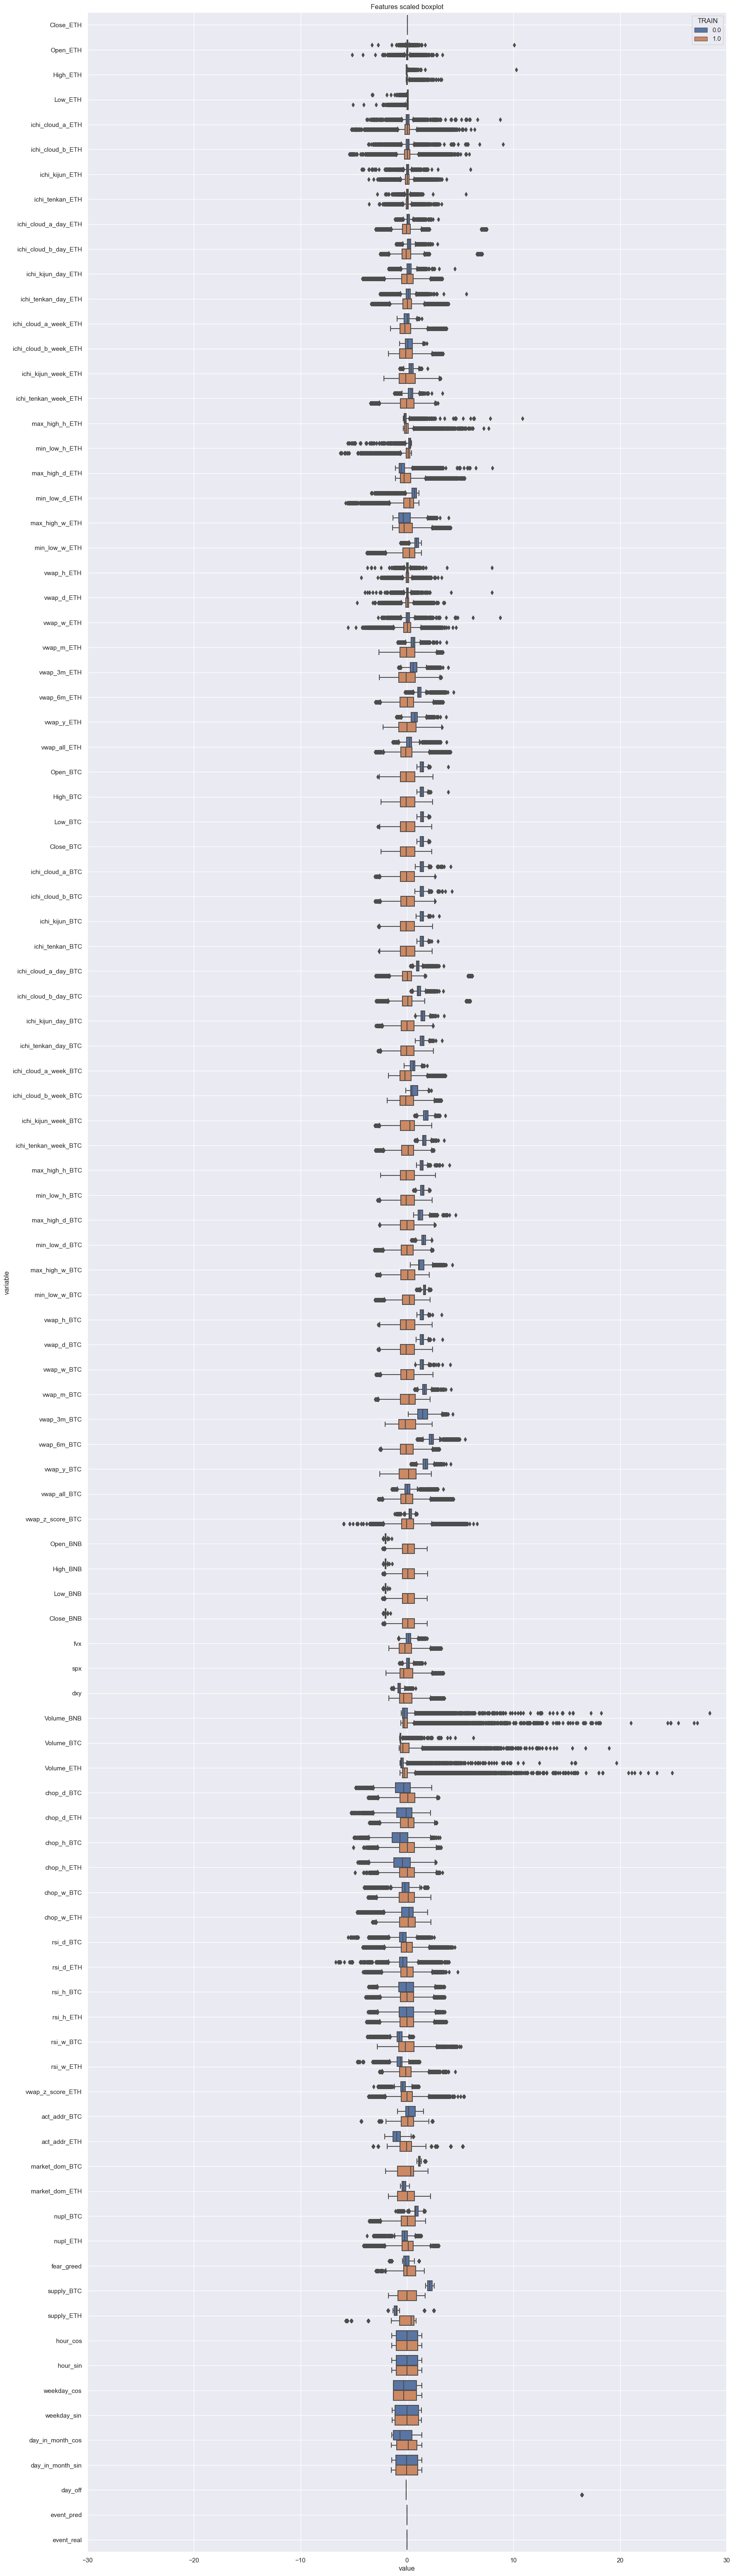

In [61]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

<AxesSubplot: >

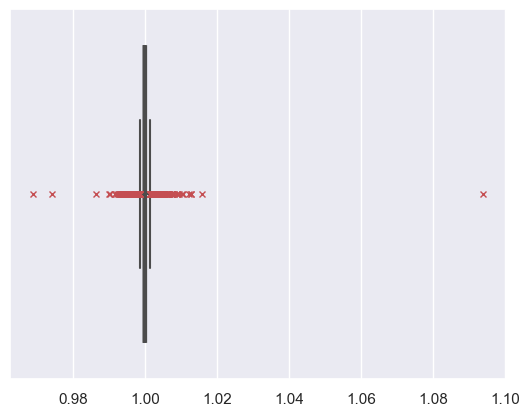

In [62]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


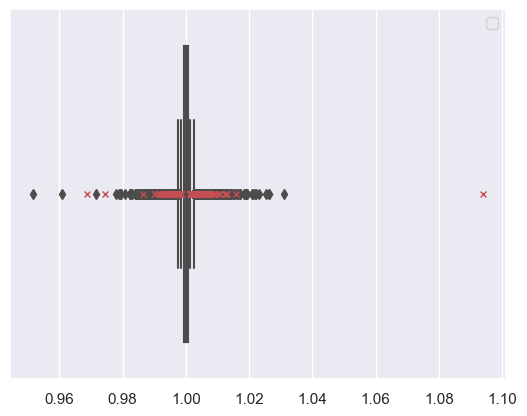

In [63]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

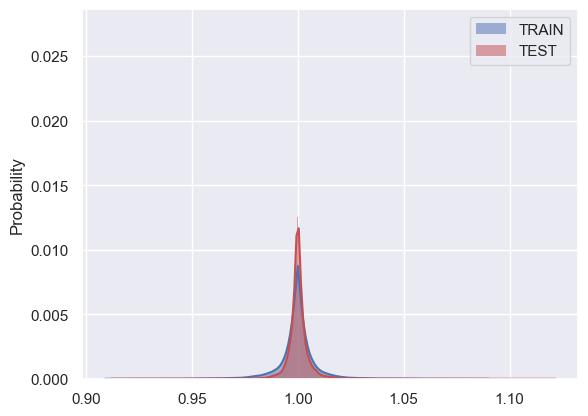

In [64]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [65]:
X_train_sca.shape

(54051, 72, 102)

In [66]:
X_train_sca[:,-1,:].shape

(54051, 102)

In [67]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.08803871],
       [-0.03450839],
       [-0.19147288],
       ...,
       [ 0.04759737],
       [ 0.07939757],
       [-0.05398028]])

In [68]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(54051, 103)

In [69]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [70]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [71]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

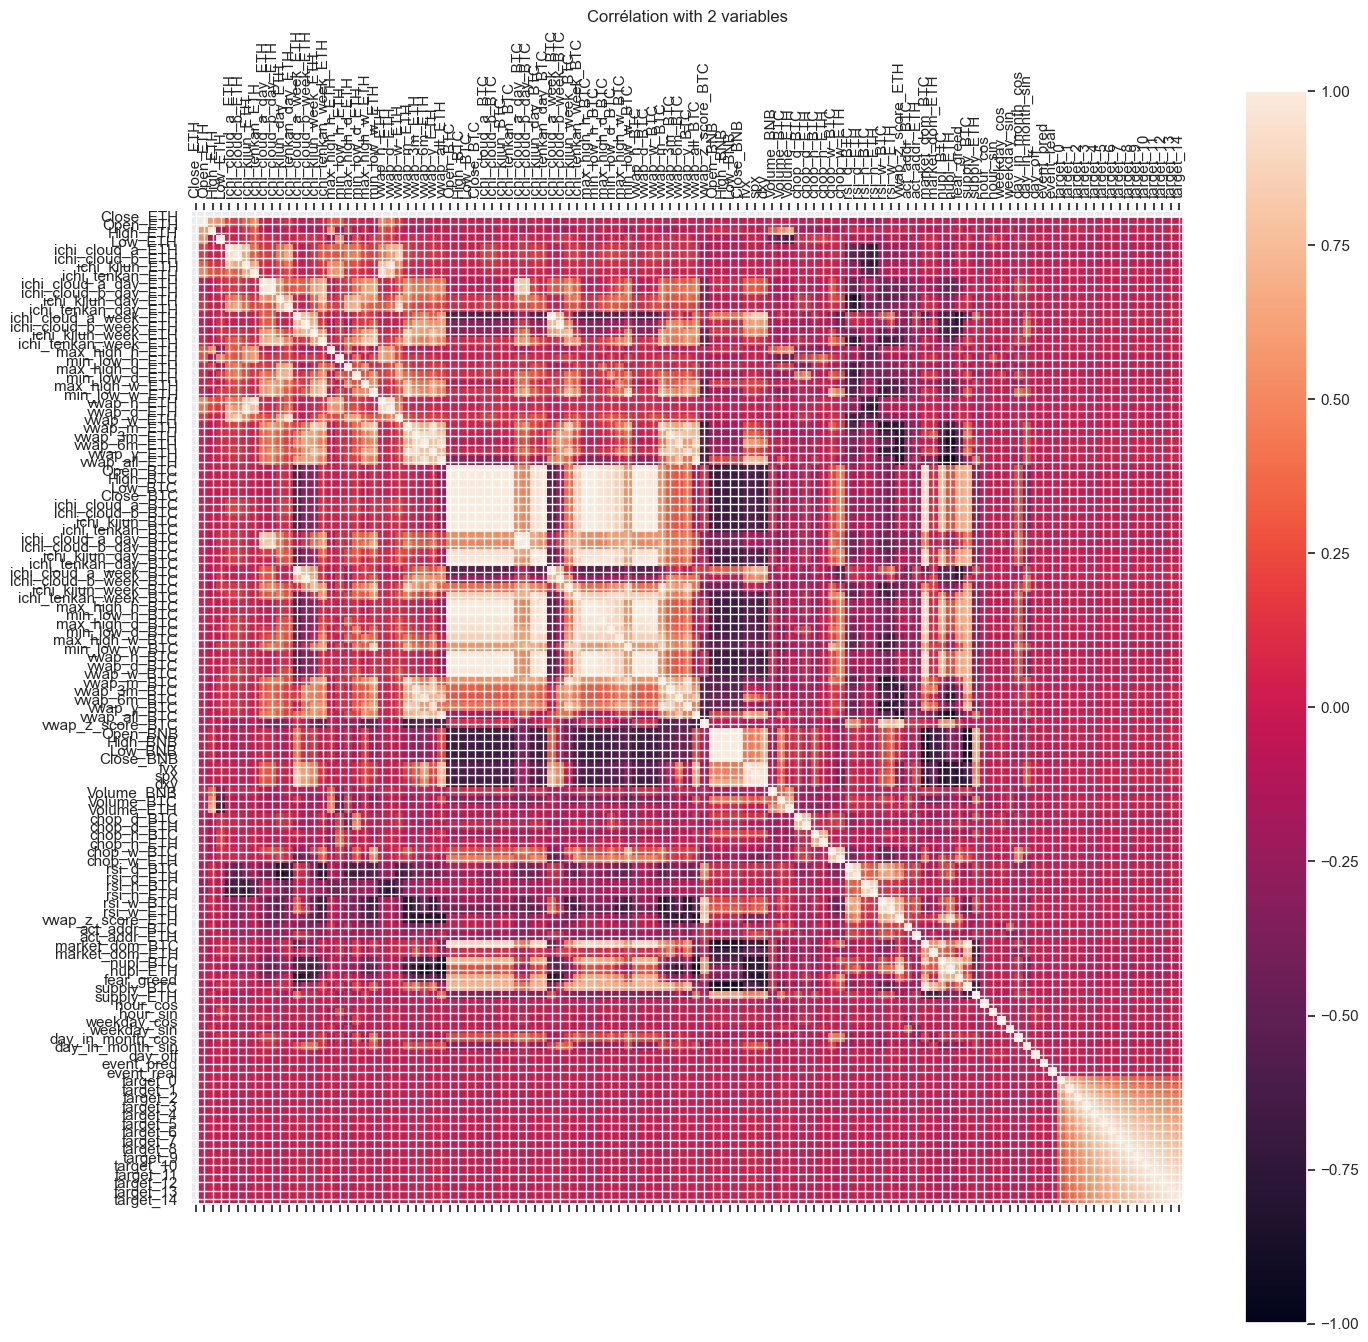

In [72]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


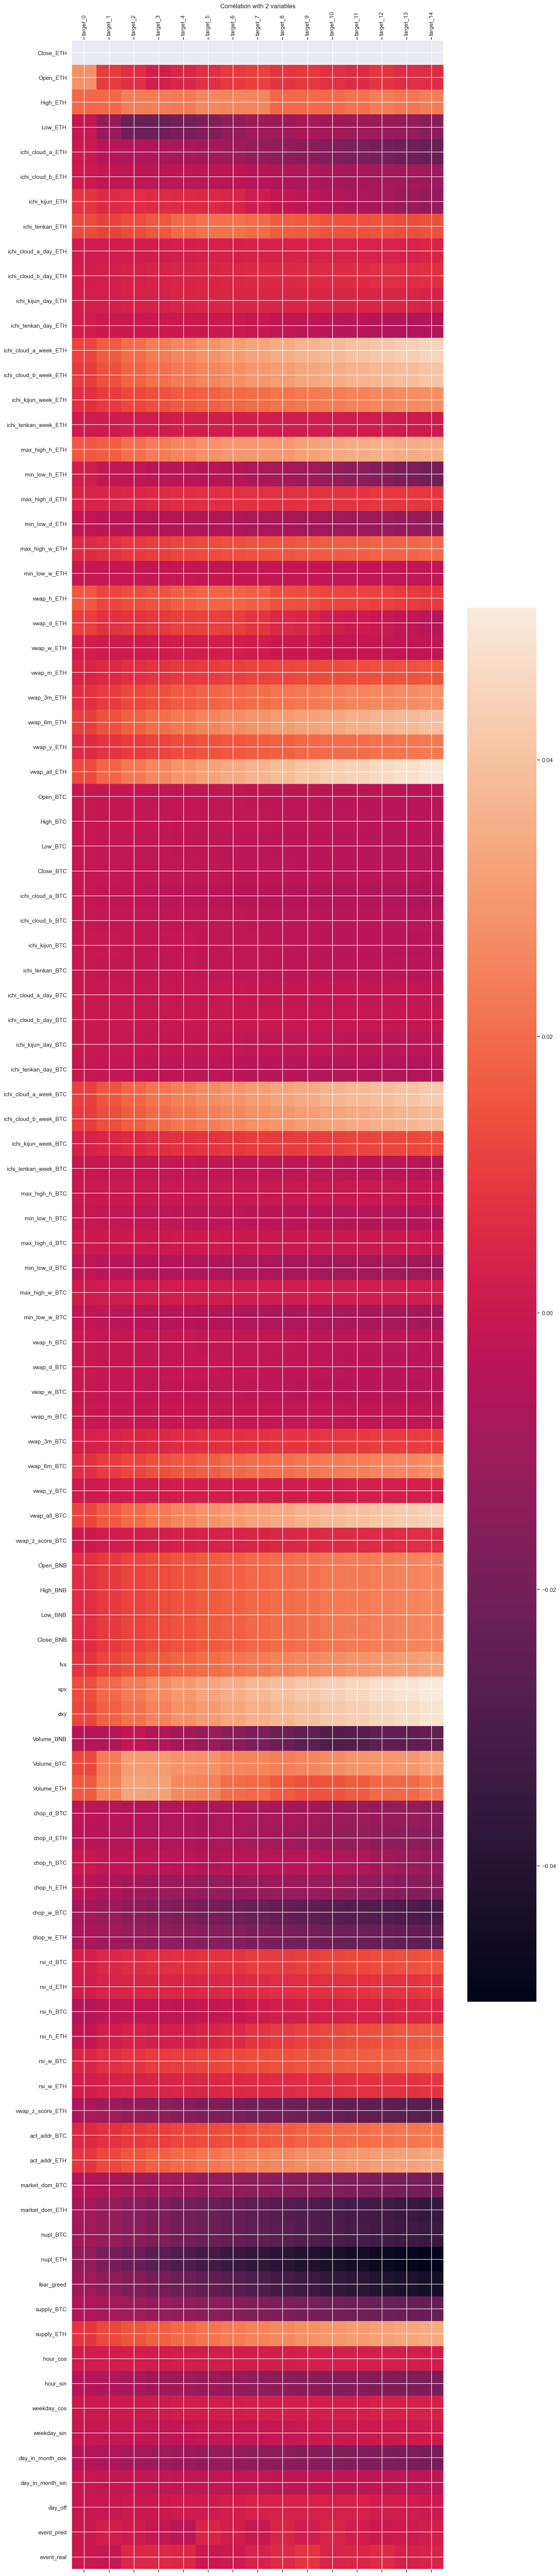

In [73]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


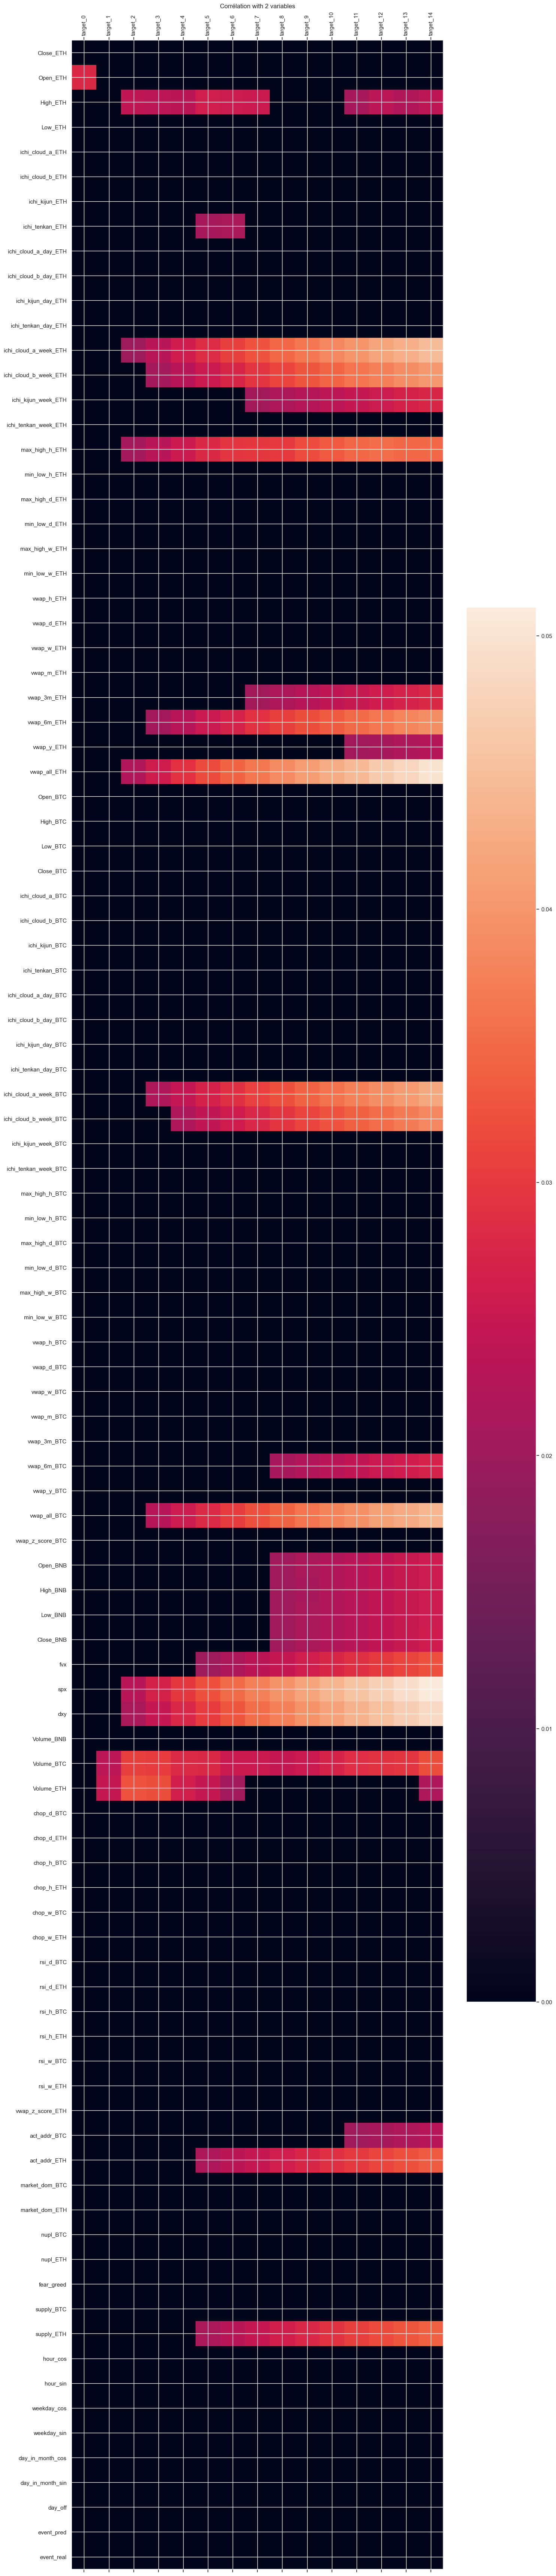

In [74]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [75]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

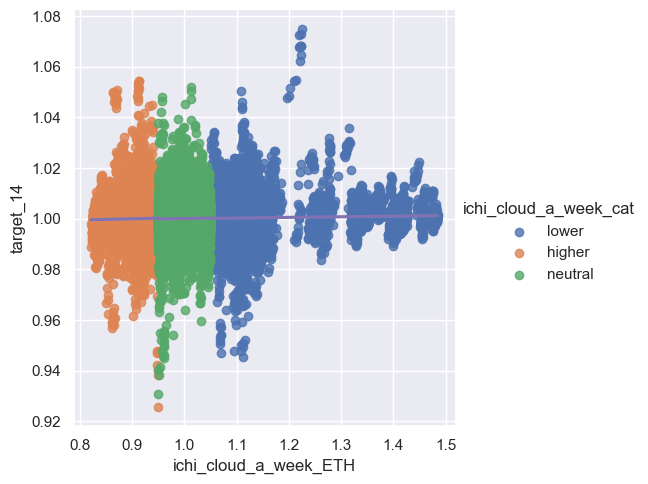

In [76]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

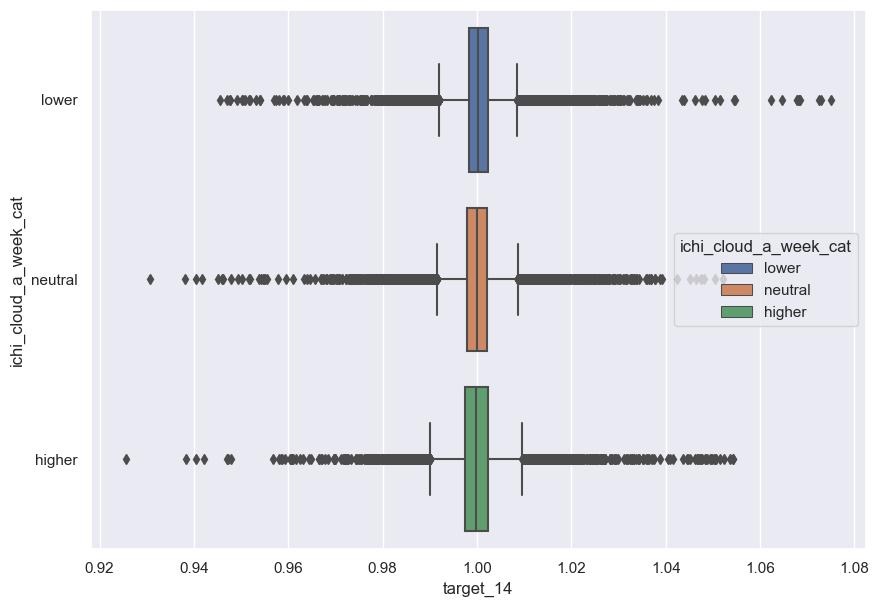

In [77]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [78]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


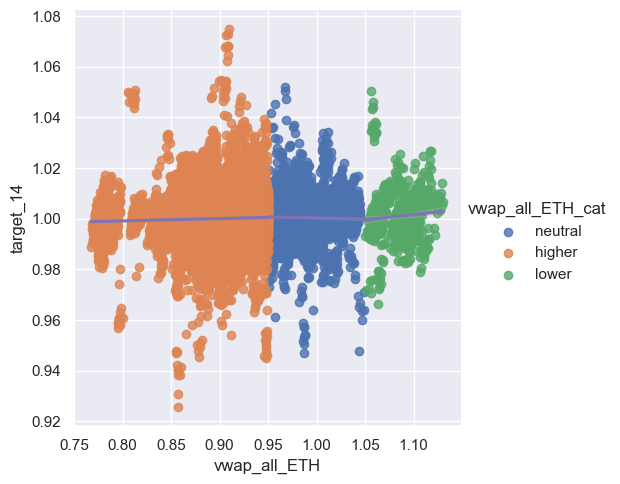

In [79]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

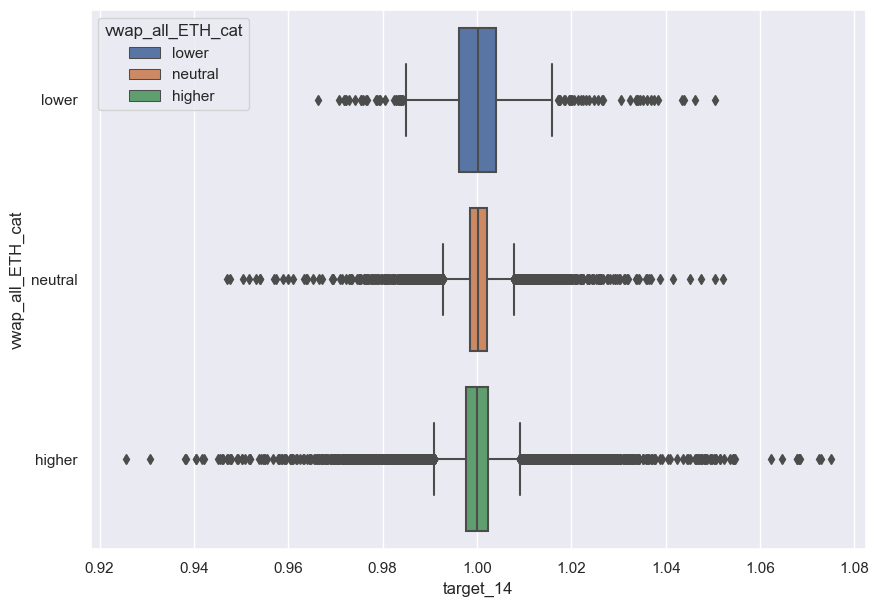

In [80]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

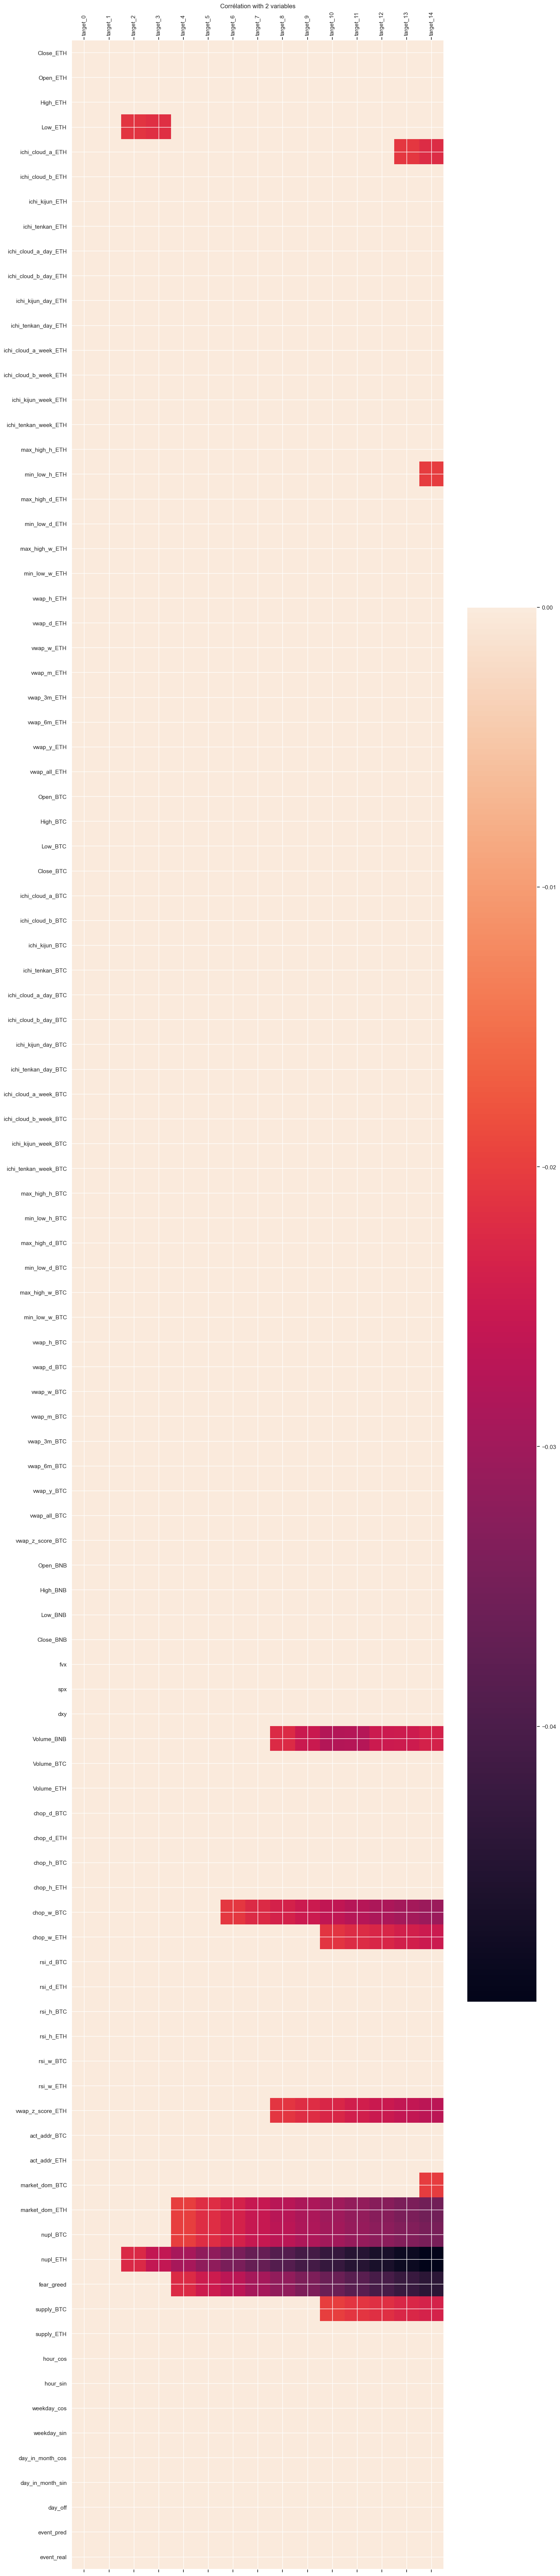

In [81]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

Text(0.5, 1.0, 'Net Unrealized Profit/Loss impact : ETH price = f(NUPL)')

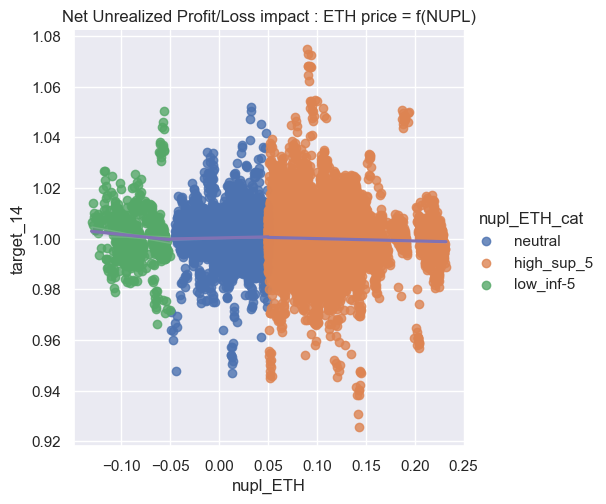

In [82]:
list_nupl_level=["low_inf-5", "neutral", "high_sup_5"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low_inf-5"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high_sup_5"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Net Unrealized Profit/Loss impact : ETH price = f(NUPL)")

(0.98, 1.02)

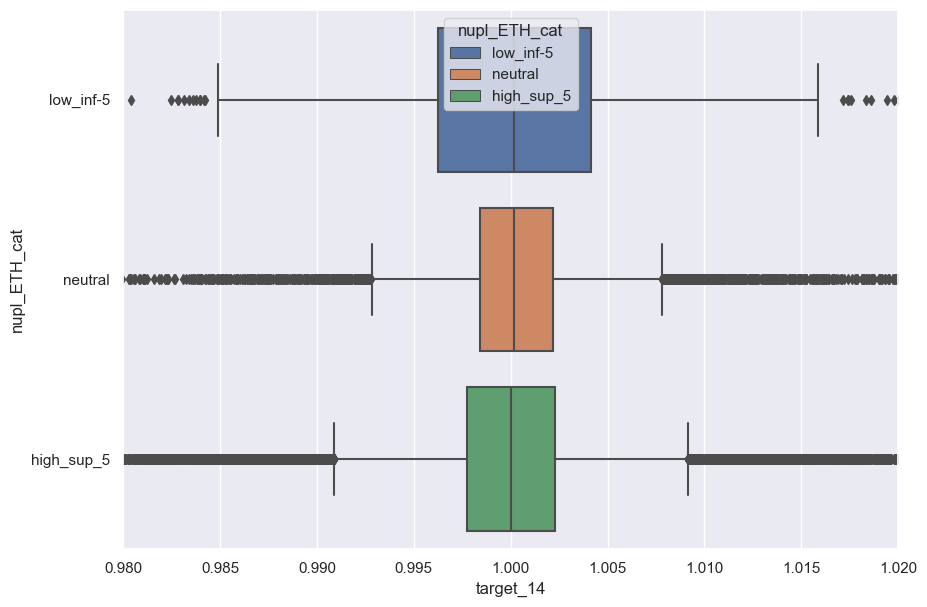

In [83]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])

In [84]:
df["target_14"].describe()

count    54051.000000
mean         1.000142
std          0.005965
min          0.925613
25%          0.997898
50%          1.000043
75%          1.002286
max          1.074927
Name: target_14, dtype: float64

In [85]:
df["target_1"].describe()

count    54051.000000
mean         1.000019
std          0.002189
min          0.967271
25%          0.999173
50%          1.000010
75%          1.000853
max          1.053076
Name: target_1, dtype: float64

<AxesSubplot: xlabel='target_14'>

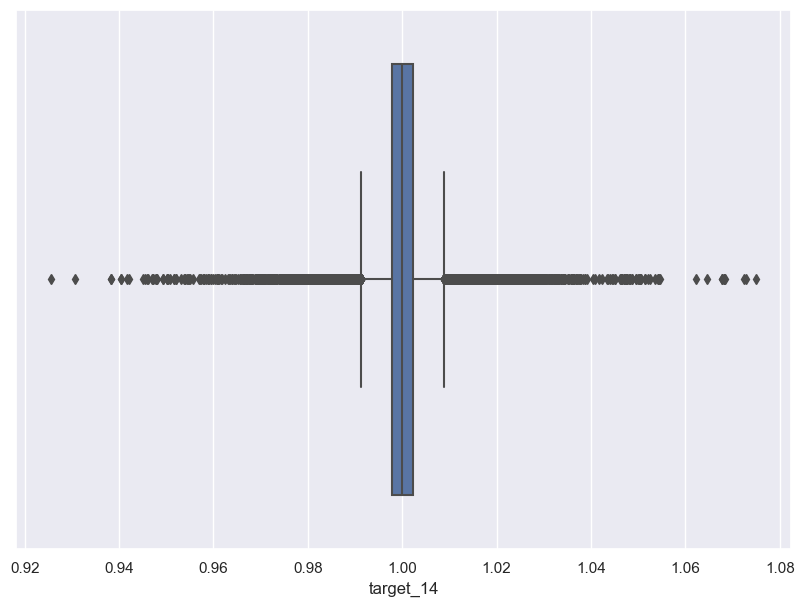

In [86]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [87]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00028363, 1.0007064 , 1.00054586, ..., 1.00005352, 1.00037996,
        1.00031039],
       [1.00042265, 1.00026215, 1.0002782 , ..., 1.0000963 , 1.00002675,
        0.9999358 ],
       [0.99983957, 0.99985561, 0.99951335, ..., 0.99960427, 0.99951335,
        0.99961496]])

In [88]:
y_train_sca

array([[ 0.08803871,  0.07080441, -0.10345353, ..., -0.04217601,
         0.01718658, -0.0498357 ],
       [-0.03450839, -0.20868613, -0.05556284, ..., -0.08810154,
        -0.15509298, -0.2909899 ],
       [-0.19147288, -0.03833806, -0.14744662, ..., -0.13787569,
        -0.27378285, -0.33886515],
       ...,
       [ 0.04759737,  0.14430438,  0.1075802 , ..., -0.00504063,
         0.06963188,  0.05371806],
       [ 0.07939757,  0.0426838 ,  0.04635518, ...,  0.00474624,
        -0.01116306, -0.03196753],
       [-0.05398028, -0.05031046, -0.12860007, ..., -0.10780439,
        -0.12860007, -0.10535784]])

## Autoencoder

### Model creation

### Training

In [89]:
X_train_sca.shape

(54051, 72, 102)

In [90]:
3*3*3*10*35/3600

2.625

In [91]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
seed = 1
epochs = 30 #100 #150 #6 #300
patience = 10 #30 #20 #40 #3 #100
mse_curr_min = None
if MODE_TRAIN_AE:
    for n_unit_enc in [64]: #[32, 64, 128]: #[104]: #
        for encoding_dim in [16]:#[16, 20, 32]:
            for dropout_autoenc in [0.25]: #[0.05, 0.15, 0.25]: #[0.25]:
                # check already done ? 
                #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
                plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                path_jpg = os.path.join(path_data,
                    f"output_MSE autoencoder - {plt_name}.jpg")
                if (MODE_TRAIN_AE == False):
                    print(f"BE CAREFUL ! training inactivated => no training done...")
                    continue
                print(f"Training: {plt_name} ...")
                # Init
                tf.keras.backend.clear_session()
                np.random.seed(seed)
                random.seed(seed)
                tf.random.set_seed(seed)
                # Input dimension
                input_dim = X_train.shape[-1]
                # Reduced encoded input dimension
                # 64/8/0.5
                # Définir l'encodeur
                encoder_inputs = keras.Input(shape=(None, input_dim))
                encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
                #encoder = layers.LayerNormalization()(encoder)
                #encoder = layers.Dense(encoding_dim, activation='relu')
                encoder = layers.Dropout(dropout_autoenc)(encoder)
                encoder_outputs = layers.Dense(encoding_dim)(encoder)
                encoder_model = keras.Model(encoder_inputs, encoder_outputs)
                print(encoder_model.summary())
                # Définir le décodeur
                decoder_inputs = keras.Input(shape=(None, encoding_dim))
                decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
                #decoder = layers.LayerNormalization()(decoder)
                #decoder = layers.Dense(n_unit_enc, activation='relu')
                decoder = layers.Dropout(dropout_autoenc)(decoder)
                decoder_outputs = layers.Dense(input_dim)(decoder)
                decoder_model = keras.Model(decoder_inputs, decoder_outputs)
                print(decoder_model.summary())
                # Define complete autoencoder 
                autoencoder_inputs = keras.Input(shape=(None, input_dim))
                encoded = encoder_model(autoencoder_inputs)
                decoded = decoder_model(encoded)
                autoencoder = keras.Model(autoencoder_inputs, decoded)
                # Compile : autoencoder
                optim = tf.keras.optimizers.legacy.Adam()
                #optim = tf.keras.optimizers.Adam()
                autoencoder.compile(optimizer=optim, loss="mse")
                # earlystop 
                es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                                monitor='val_loss', mode='auto', restore_best_weights=True)
                # Train
                if patience == 0:
                    autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                    epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                    verbose=1)
                else:
                    autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                        epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                        verbose=1, callbacks=[es])

                plot_train_history(
                    autoenc_step_history,f"MSE autoencoder - {plt_name}",
                    saveFolder=path_data)
                #autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                #encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                            # save the best
                mse_curr = np.min(autoenc_step_history.history['val_loss'])
                print("MSE TEST : ", mse_curr)

                if mse_curr_min == None:
                    mse_curr_min = mse_curr
                    n_unit_enc_min = n_unit_enc
                    encoding_dim_min = encoding_dim
                    dropout_autoenc_min = dropout_autoenc
                    print("Save autoencoder: ", path_mdl_autoencoder)
                    autoencoder.save(path_mdl_autoencoder)
                    print("Save encoder: ", path_mdl_encoder)
                    encoder_model.save(path_mdl_encoder)
                else:
                    if mse_curr < mse_curr_min:
                        mse_curr_min = mse_curr
                        n_unit_enc_min = n_unit_enc
                        encoding_dim_min = encoding_dim
                        dropout_autoenc_min = dropout_autoenc
                        print("Save autoencoder: ", path_mdl_autoencoder)
                        autoencoder.save(path_mdl_autoencoder)
                        print("Save encoder: ", path_mdl_encoder)
                        encoder_model.save(path_mdl_encoder)

    mse_curr = mse_curr_min 
    n_unit_enc = n_unit_enc_min 
    encoding_dim = encoding_dim_min
    dropout_autoenc = dropout_autoenc_min
else:
    print("Load models...")
    autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
    print(autoencoder.summary())
    encoder_model = tf.keras.models.load_model(path_mdl_encoder)
    print(encoder_model.summary())
    n_unit_enc = encoder_model.layers[1].units
    dropout_autoenc = encoder_model.layers[2].rate
    encoding_dim = encoder_model.layers[3].units

print(f"Best model : n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")

Load models...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 model (Functional)          (None, None, 16)          43792     
                                                                 
 model_1 (Functional)        (None, None, 102)         27366     
                                                                 
Total params: 71158 (277.96 KB)
Trainable params: 71158 (277.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                    

### Save model

In [92]:
# TODO select best model


In [93]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [94]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [95]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

1690/1690 [==============================] - 40s 23ms/step


(54051, 72, 102)

### Results

In [96]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

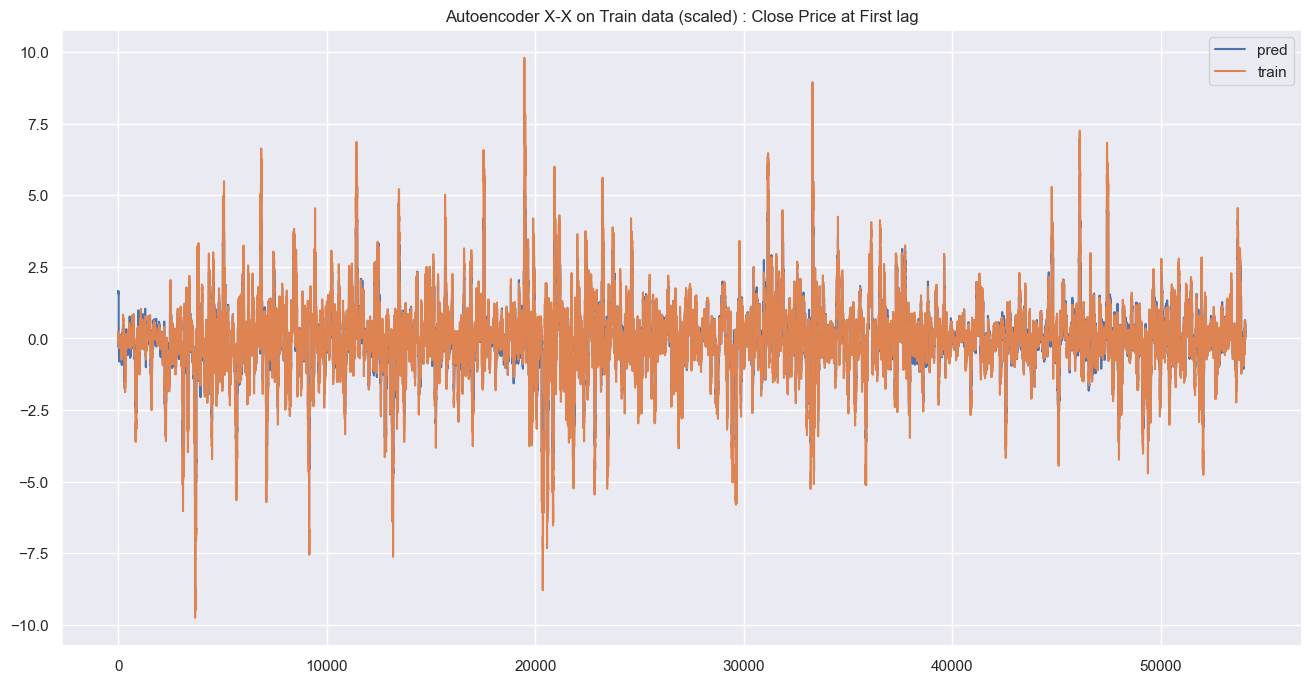

In [97]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE TRAIN by lags and by features

In [98]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)

mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)

df_mae_ae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_train.index))]
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)

df_mae_ae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(54051, 72, 102)
(54051, 72, 102)
(72, 102)
(1, 102)


In [99]:
df_mae_ae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.191437  0.196634  0.184327  0.193026          0.292215   
lag_1    0.152390  0.151700  0.142186  0.149144          0.256627   
lag_2    0.136865  0.130703  0.123699  0.131552          0.236452   
lag_3    0.133816  0.126521  0.119532  0.128844          0.227592   
lag_4    0.132158  0.124662  0.117532  0.127141          0.220330   
...           ...       ...       ...       ...               ...   
lag_67   0.093794  0.095609  0.080892  0.092879          0.157818   
lag_68   0.092863  0.095025  0.080087  0.092129          0.157623   
lag_69   0.091922  0.094426  0.079218  0.091278          0.157456   
lag_70   0.090923  0.093717  0.078318  0.090443          0.157256   
lag_71   0.089772  0.093278  0.077281  0.089439          0.157054   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.319050        0.215785         0.210833   
lag_1           0.283933        0.177869         0.168688   
lag_2           0.264323        0.153748         0.143436   
lag_3           0.255034        0.146395         0.134716   
lag_4           0.247452        0.142863         0.127387   
...                  ...             ...              ...   
lag_67          0.160590        0.113339         0.088352   
lag_68          0.160481        0.112947         0.087869   
lag_69          0.160367        0.112535         0.087434   
lag_70          0.160252        0.112171         0.086974   
lag_71          0.160129        0.111699         0.086408   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  \
lag_0               0.307068              0.239265  ...    0.313240  0.602404   
lag_1               0.227771              0.180401  ...    0.252153  0.429995   
lag_2               0.191330              0.146772  ...    0.203115  0.353541   
lag_3               0.175458              0.134303  ...    0.172960  0.309256   
lag_4               0.166304              0.124831  ...    0.153064  0.281545   
...                      ...                   ...  ...         ...       ...   
lag_67              0.127720              0.098815  ...    0.115181  0.197666   
lag_68              0.127703              0.098806  ...    0.115148  0.197613   
lag_69              0.127692              0.098777  ...    0.115108  0.197573   
lag_70              0.127673              0.098746  ...    0.115070  0.197559   
lag_71              0.127679              0.098724  ...    0.115028  0.197522   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
lag_0   0.587467     0.566336     0.548810          0.586342   
lag_1   0.425923     0.429969     0.405385          0.443408   
lag_2   0.361437     0.367334     0.350554          0.370408   
lag_3   0.325562     0.331645     0.317895          0.331169   
lag_4   0.299325     0.307107     0.297851          0.305686   
...          ...          ...          ...               ...   
lag_67  0.195335     0.203366     0.215567          0.181879   
lag_68  0.195221     0.203326     0.215500          0.181854   
lag_69  0.195147     0.203310     0.215434          0.181832   
lag_70  0.195066     0.203290     0.215394          0.181798   
lag_71  0.194999     0.203274     0.215354          0.181773   

        day_in_month_sin   day_off  event_pred  event_real  
lag_0           0.547138  0.332393    0.115360    0.040837  
lag_1           0.421876  0.266312    0.080280    0.038270  
lag_2           0.353770  0.187958    0.062797    0.037296  
lag_3           0.314661  0.139599    0.056951    0.036876  
lag_4           0.286398  0.113554    0.053541    0.036920  
...                  ...       ...         ...         ...  
lag_67          0.177944  0.068452    0.046912    0.034725  
lag_68          0.177929  0.068395    0.046897    0.034670  
lag_69          0.177933  0.068339    0.046884    0.034601  
lag_70          0.177924  0.068282    0.046873    0.034541  
lag_71          0.177921  0.06822

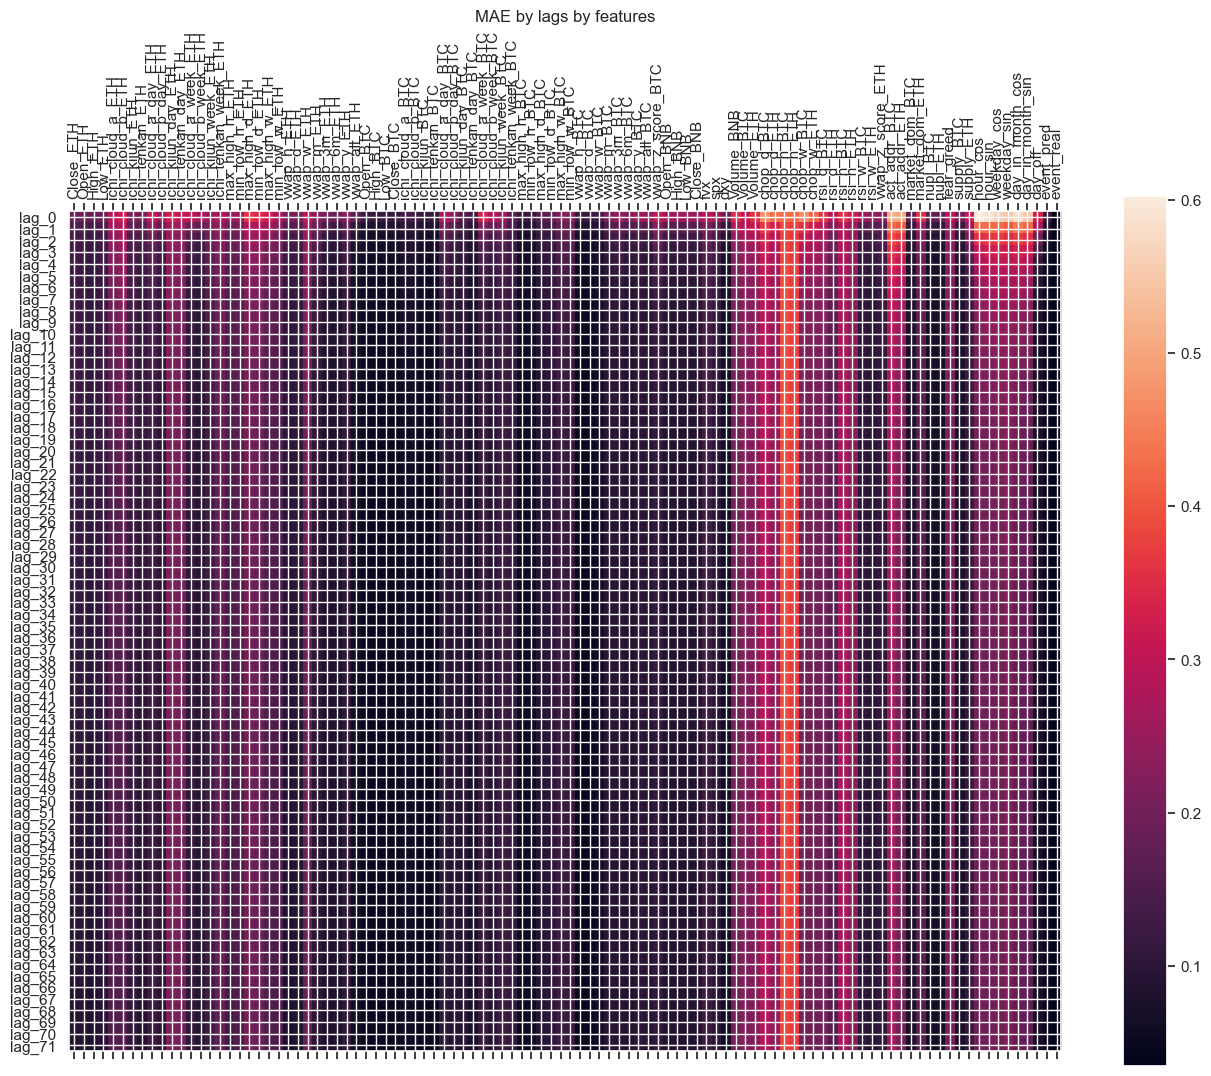

In [100]:
plot_corr(df_mae_ae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

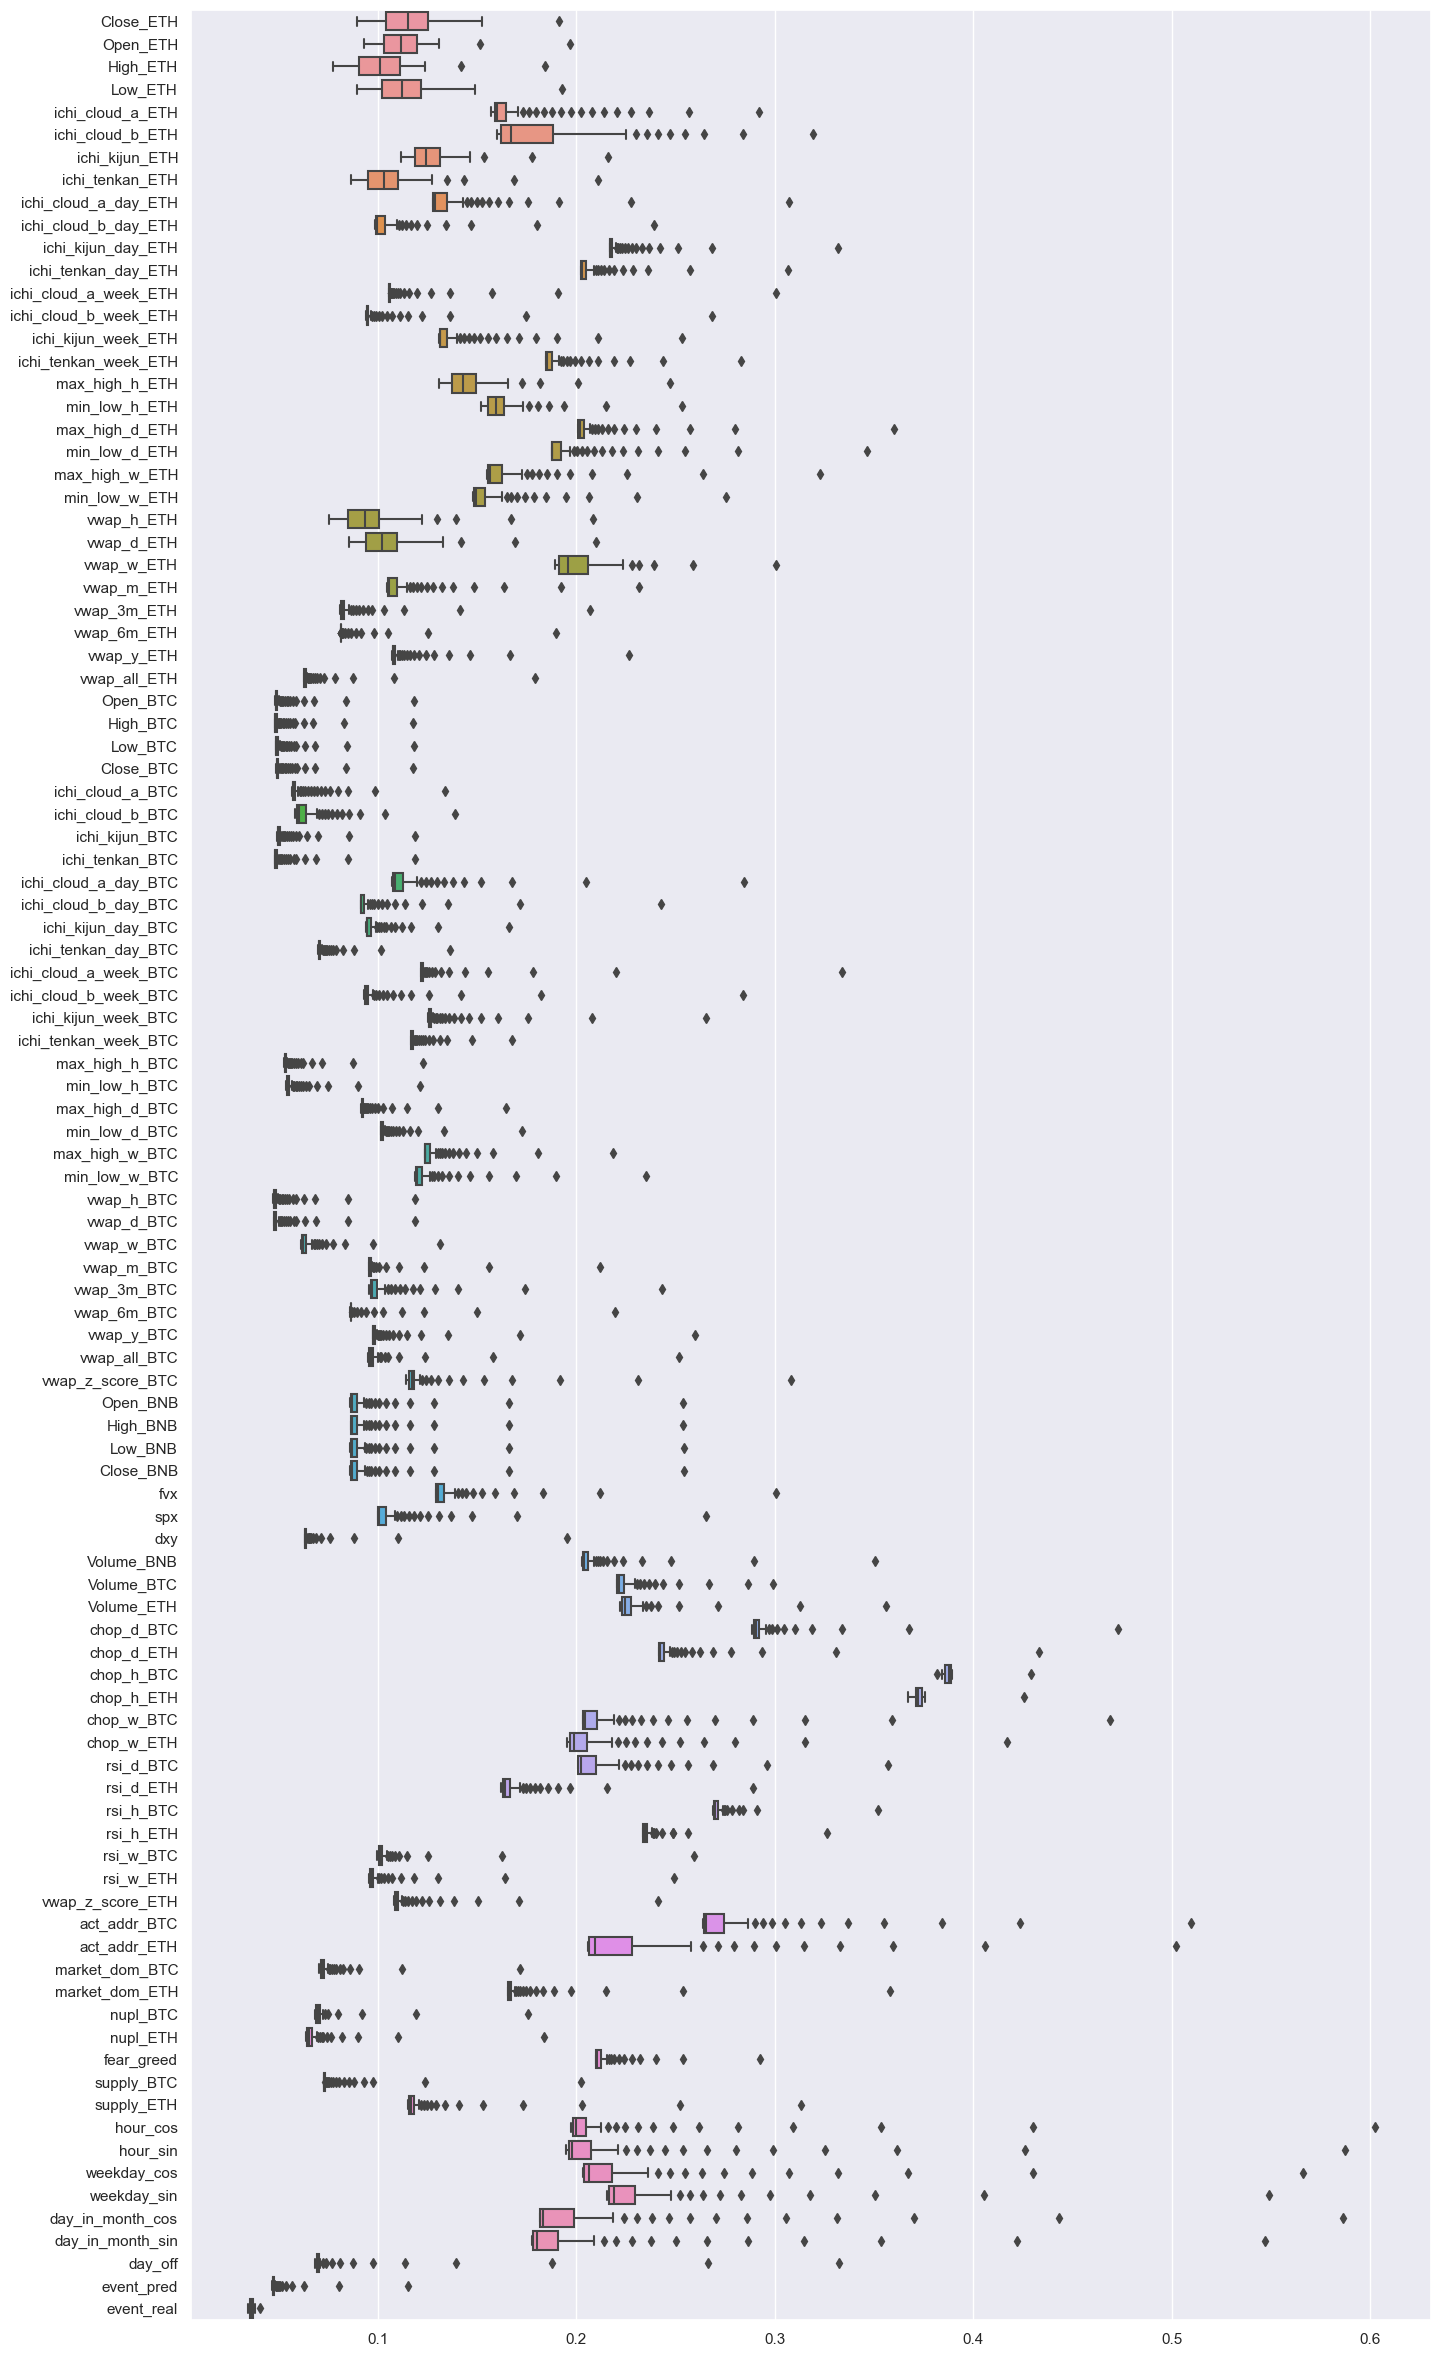

In [101]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_ae_train, orient="h")

In [102]:
df_mae_ae_train_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.115406  0.112361  0.101689  0.112519          0.170241   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.182421        0.127074         0.105517              0.137735   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.106099  ...    0.124984  0.217271  0.218099     0.226356   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.235646          0.208204          0.200981  0.080249    0.049282   

   event_real  
0    0.036384  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature')

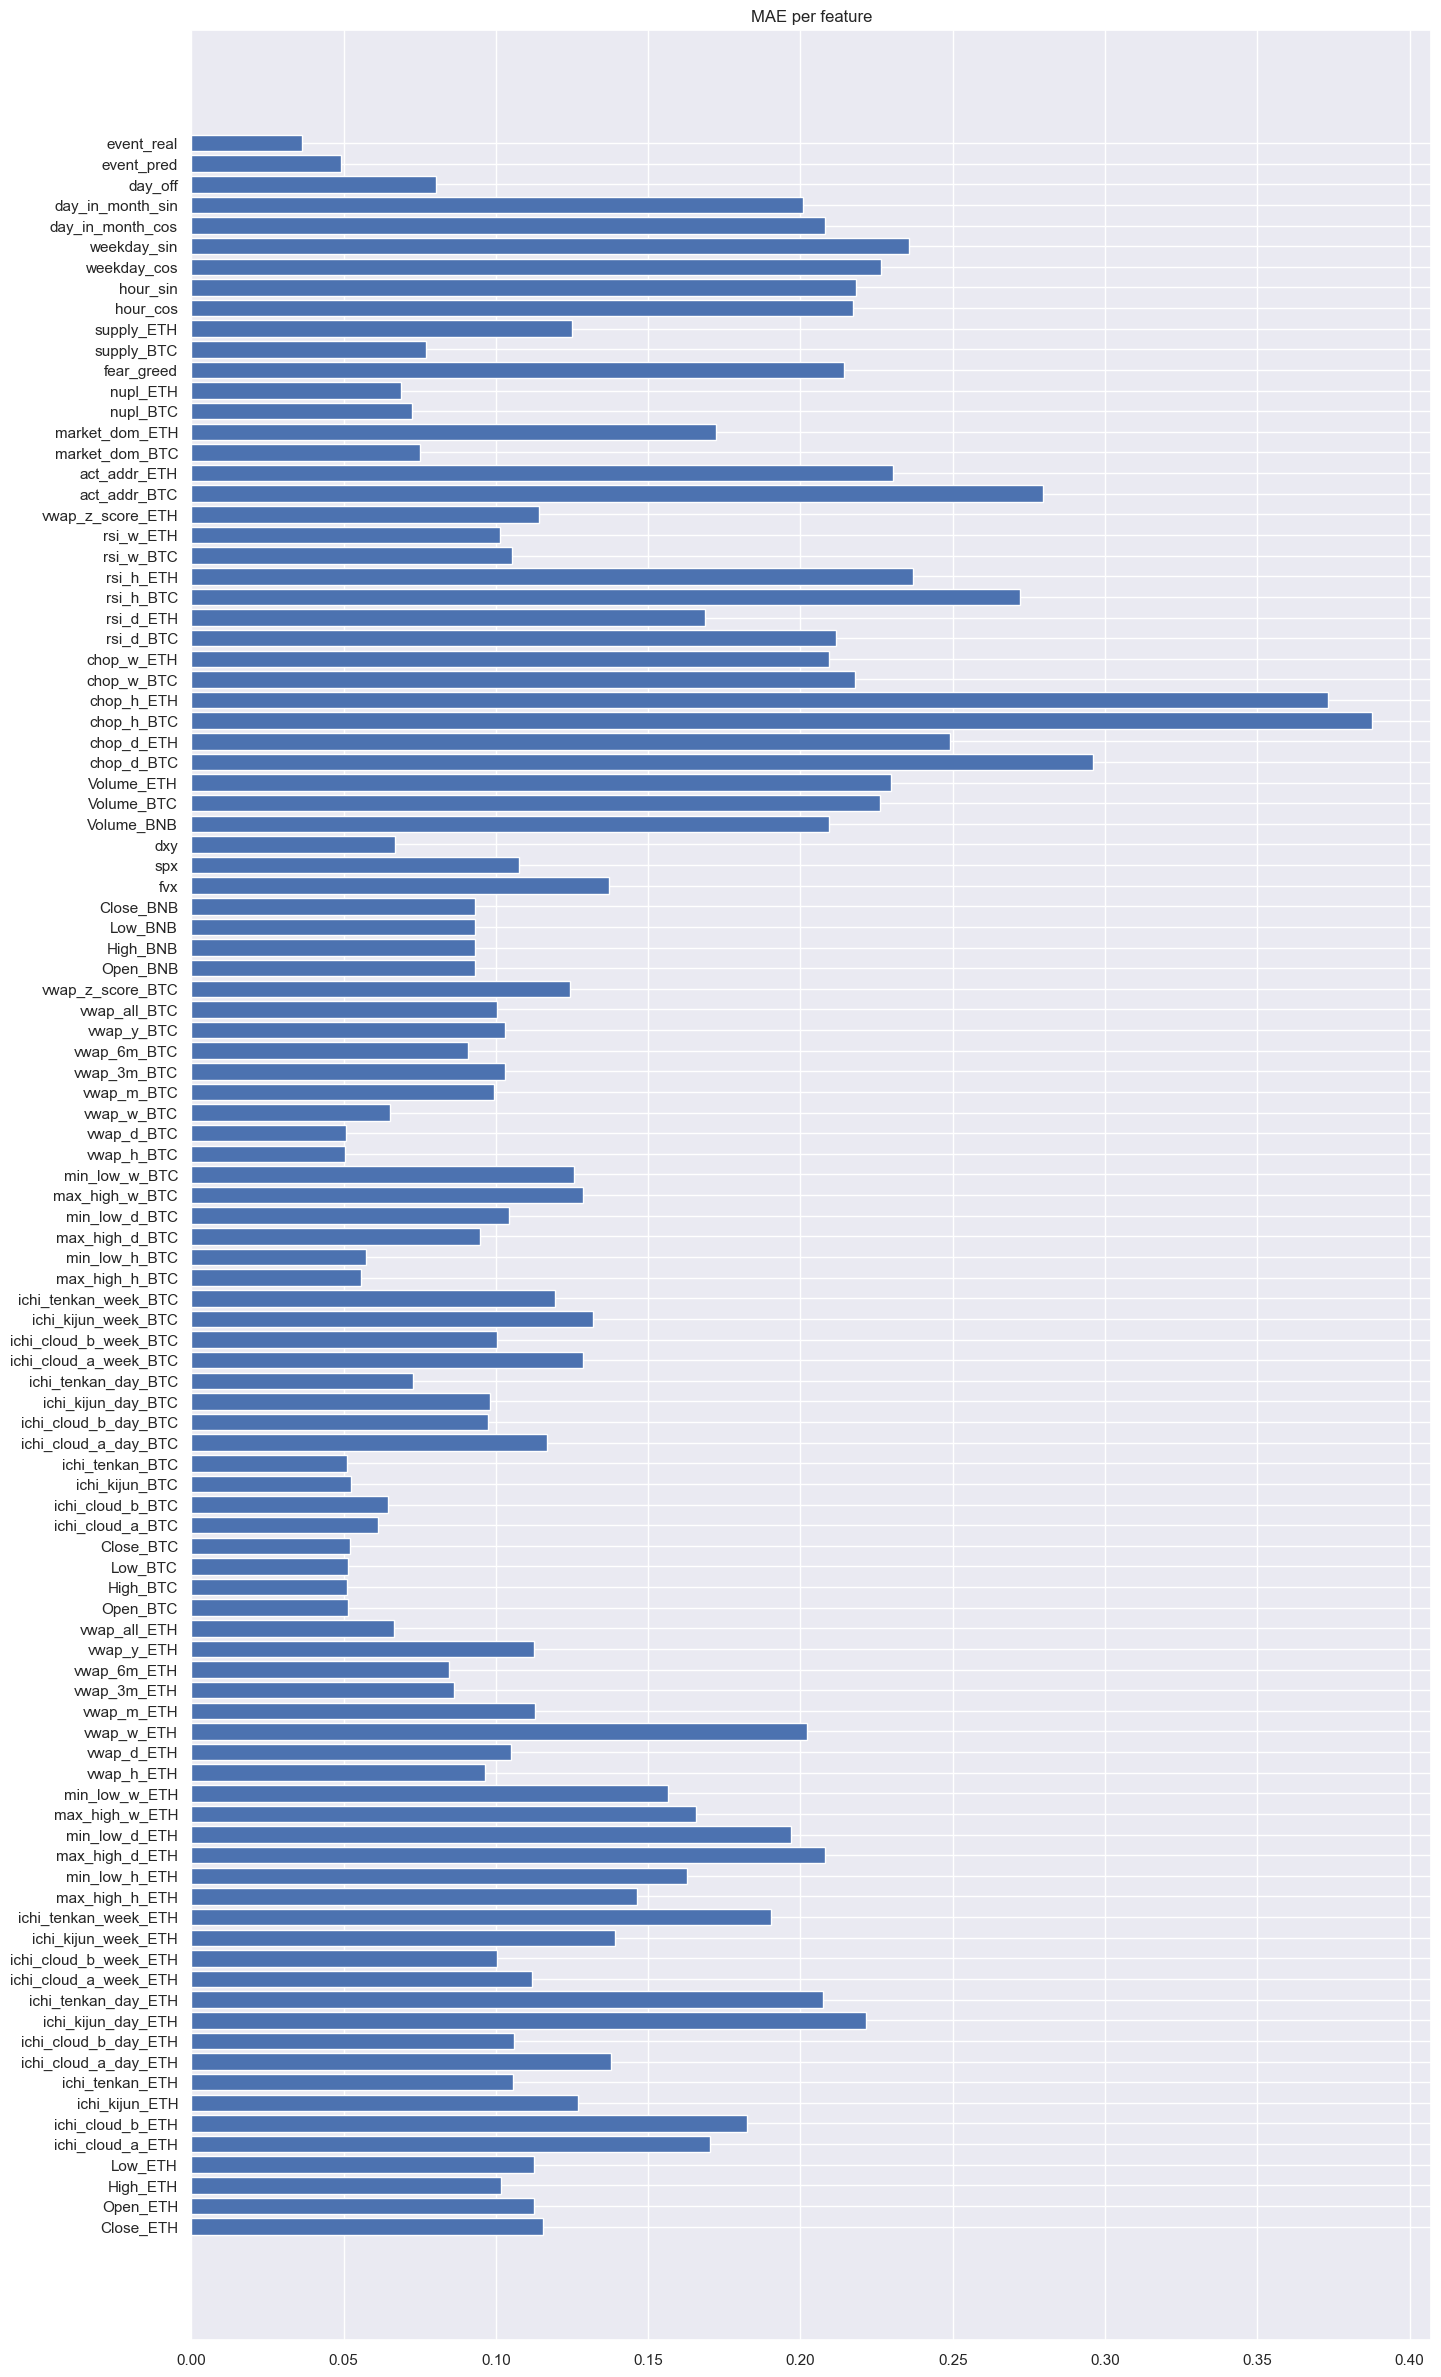

In [103]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_train_feat.columns, df_mae_ae_train_feat.values[0])
plt.title("MAE per feature")

In [104]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(54051,)
(54051,)
[1196.32 1195.38 1194.55 ... 1872.02 1871.17 1873.81]
[1196.32 1195.38 1194.55]


In [105]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.9986622 , 0.9994918 , 0.99932235, ..., 1.0012784 , 1.0003923 ,
       1.0002064 ], dtype=float32)

[1196.32 1195.38 1194.55 ... 1872.02 1871.17 1873.81]
[1212.48542376 1212.79949991 1212.83210218 ... 1872.71783525 1871.68012159
 1873.52423773]


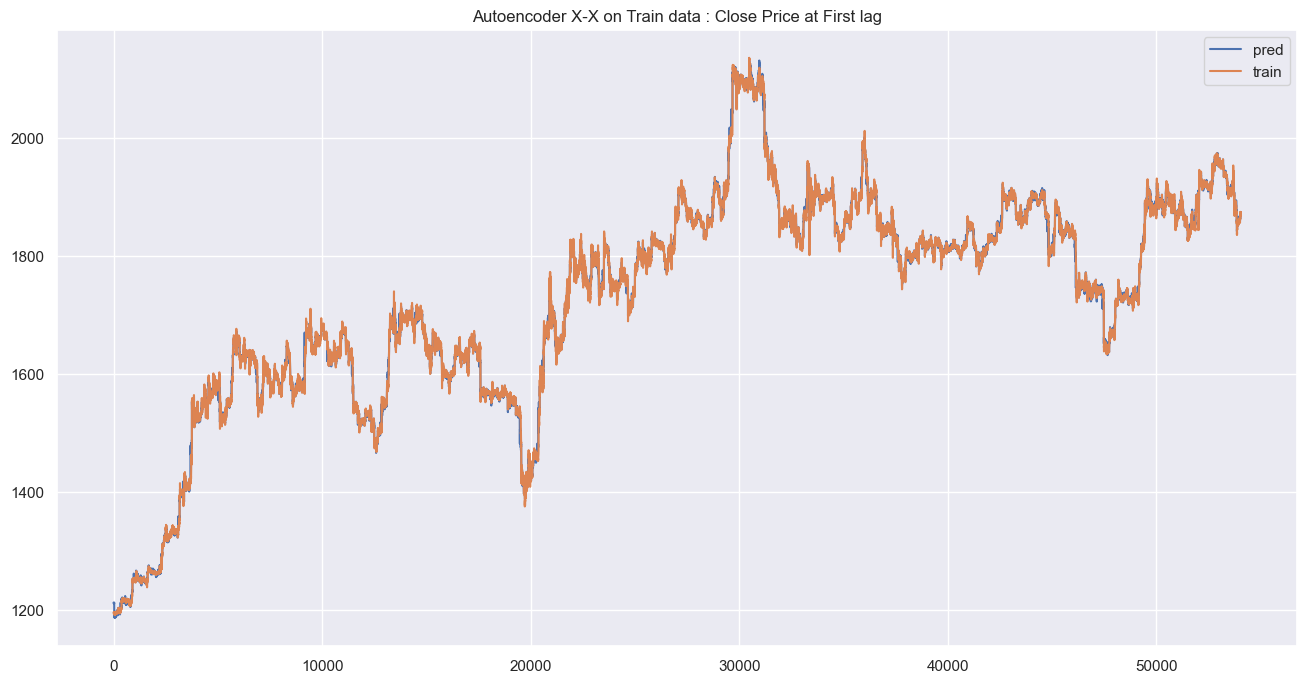

In [106]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### MAE TEST per features

In [107]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

421/421 [==============================] - 10s 24ms/step


(13446, 72, 102)

In [108]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-07-07 23:25:00'

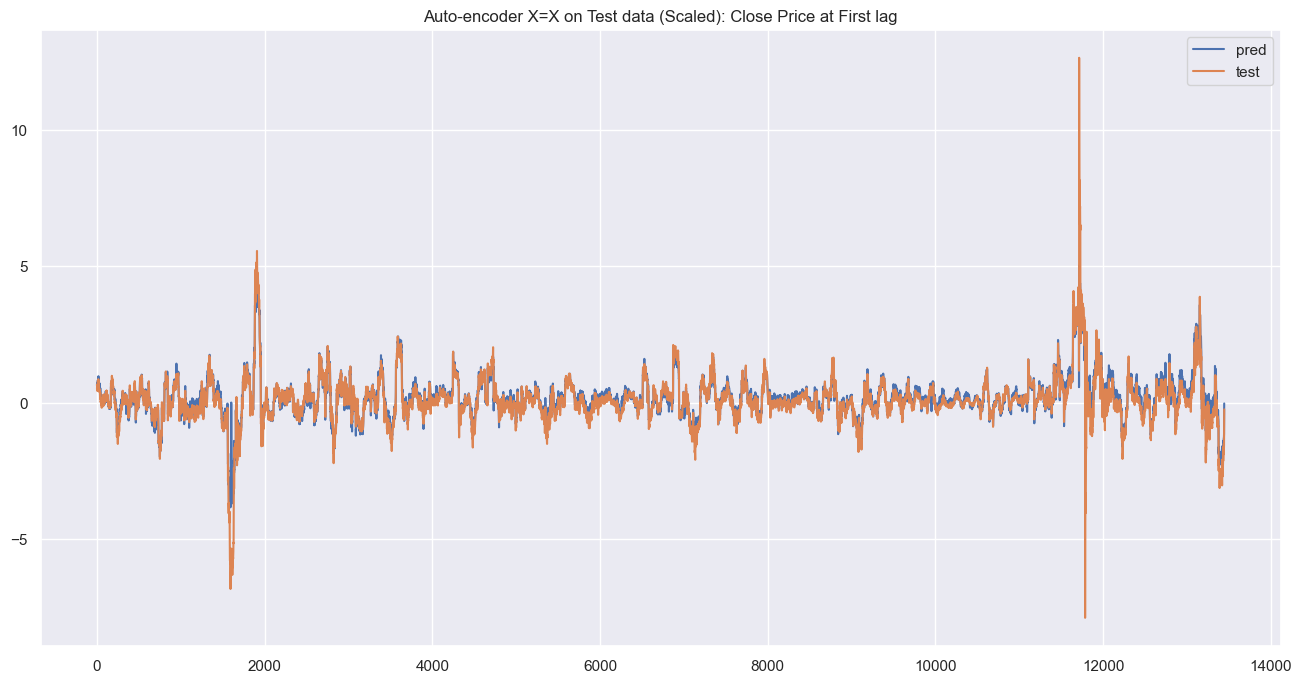

In [109]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [110]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1868.2  1868.68 1869.82 1869.09 1870.   1870.91 1869.43 1870.09 1869.18]
X test pred :  [1870.68790467 1870.2773488  1871.26074383 1871.39039665 1871.58637887
 1872.64813869 1872.34790014 1871.80439942 1871.12973017]


[1868.2  1868.68 1869.82 ... 1655.81 1658.1  1657.37]
[1870.68790467 1870.2773488  1871.26074383 ... 1662.24386656 1661.65554703
 1660.68387137]


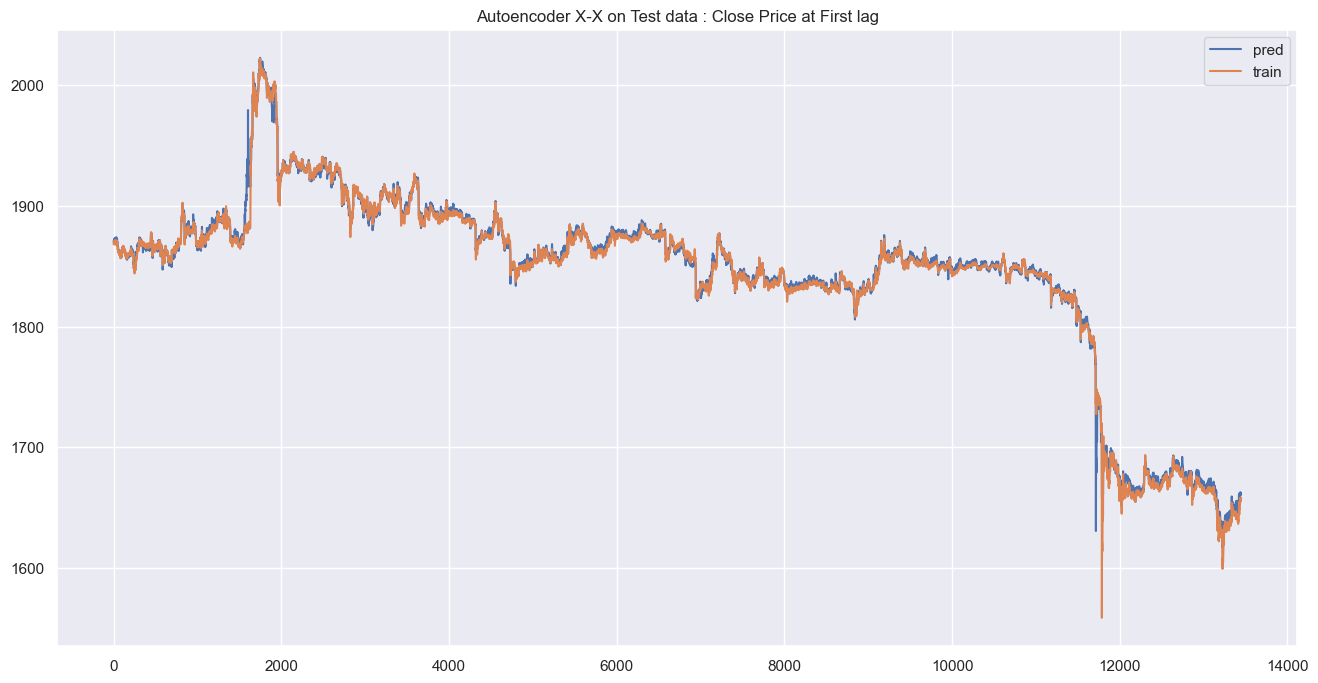

In [111]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [112]:
X_test_sca.shape

(13446, 72, 102)

In [113]:
mean_absolute_error(X_test_sca[:,0,:], X_test_sca_pred[:,0,:])

0.37360888223246347

In [114]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_ae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_ae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(13446, 72, 102)
(13446, 72, 102)
(72, 102)
(1, 102)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.191437  0.196634  0.184327  0.193026          0.292215   
lag_1    0.152390  0.151700  0.142186  0.149144          0.256627   
lag_2    0.136865  0.130703  0.123699  0.131552          0.236452   
lag_3    0.133816  0.126521  0.119532  0.128844          0.227592   
lag_4    0.132158  0.124662  0.117532  0.127141          0.220330   
...           ...       ...       ...       ...               ...   
lag_67   0.114506  0.113785  0.099840  0.129161          0.155259   
lag_68   0.114243  0.113645  0.099546  0.129006          0.155161   
lag_69   0.113921  0.113429  0.099209  0.128786          0.155081   
lag_70   0.113621  0.113169  0.098962  0.128498          0.155047   
lag_71   0.113275  0.112948  0.098597  0.128182          0.155076   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.319050        0.215785         0.210833   
lag_1           0.283933        0.177869         0.168688   
lag_2           0.264323        0.153748         0.143436   
lag_3           0.255034        0.146395         0.134716   
lag_4           0.247452        0.142863         0.127387   
...                  ...             ...              ...   
lag_67          0.149192        0.132405         0.116750   
lag_68          0.149155        0.132308         0.116620   
lag_69          0.149062        0.132194         0.116460   
lag_70          0.149024        0.132111         0.116347   
lag_71          0.148942        0.131876         0.116109   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
lag_0               0.307068              0.239265  ...  0.602404  0.587467   
lag_1               0.227771              0.180401  ...  0.429995  0.425923   
lag_2               0.191330              0.146772  ...  0.353541  0.361437   
lag_3               0.175458              0.134303  ...  0.309256  0.325562   
lag_4               0.166304              0.124831  ...  0.281545  0.299325   
...                      ...                   ...  ...       ...       ...   
lag_67              0.350959              0.283563  ...  0.205189  0.211656   
lag_68              0.350865              0.283427  ...  0.205130  0.211593   
lag_69              0.350769              0.283299  ...  0.205049  0.211554   
lag_70              0.350703              0.283205  ...  0.204944  0.211465   
lag_71              0.350648              0.283158  ...  0.204885  0.211389   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.566336     0.548810          0.586342          0.547138   
lag_1      0.429969     0.405385          0.443408          0.421876   
lag_2      0.367334     0.350554          0.370408          0.353770   
lag_3      0.331645     0.317895          0.331169          0.314661   
lag_4      0.307107     0.297851          0.305686          0.286398   
...             ...          ...               ...               ...   
lag_67     0.296634     0.412331          0.981520          0.838192   
lag_68     0.296381     0.412297          0.981485          0.838136   
lag_69     0.296162     0.412269          0.981445          0.838074   
lag_70     0.295932     0.412219          0.981399          0.838008   
lag_71     0.295616     0.412129          0.981347          0.837937   

         day_off  event_pred  event_real  dataset  
lag_0   0.332393    0.115360    0.040837    TRAIN  
lag_1   0.266312    0.080280    0.038270    TRAIN  
lag_2   0.187958    0.062797    0.037296    TRAIN  
lag_3   0.139599    0.056951    0.036876    TRAIN  
lag_4   0.113554    0.053541    0.036920    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.093152    0.046598    0.039015     TEST  
lag_68  0.093082    0.046591    0.038961     TEST  
lag_69  0.093044    0.046587    0.038917     TEST  
lag_70  0.093013    0.046579    0.038872     TEST  
lag_71  0.093027    0.046585    0.038816     TEST  

[144 ro

In [115]:
df_mae_ae_test_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.118412  0.115751  0.104479  0.130515          0.160515   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.159975         0.13533          0.11887               0.36534   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.299602  ...     0.34757  0.212293  0.229125     0.311067   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.427713          0.986438          0.853256  0.100121    0.047027   

   event_real  
0    0.040305  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature on TEST')

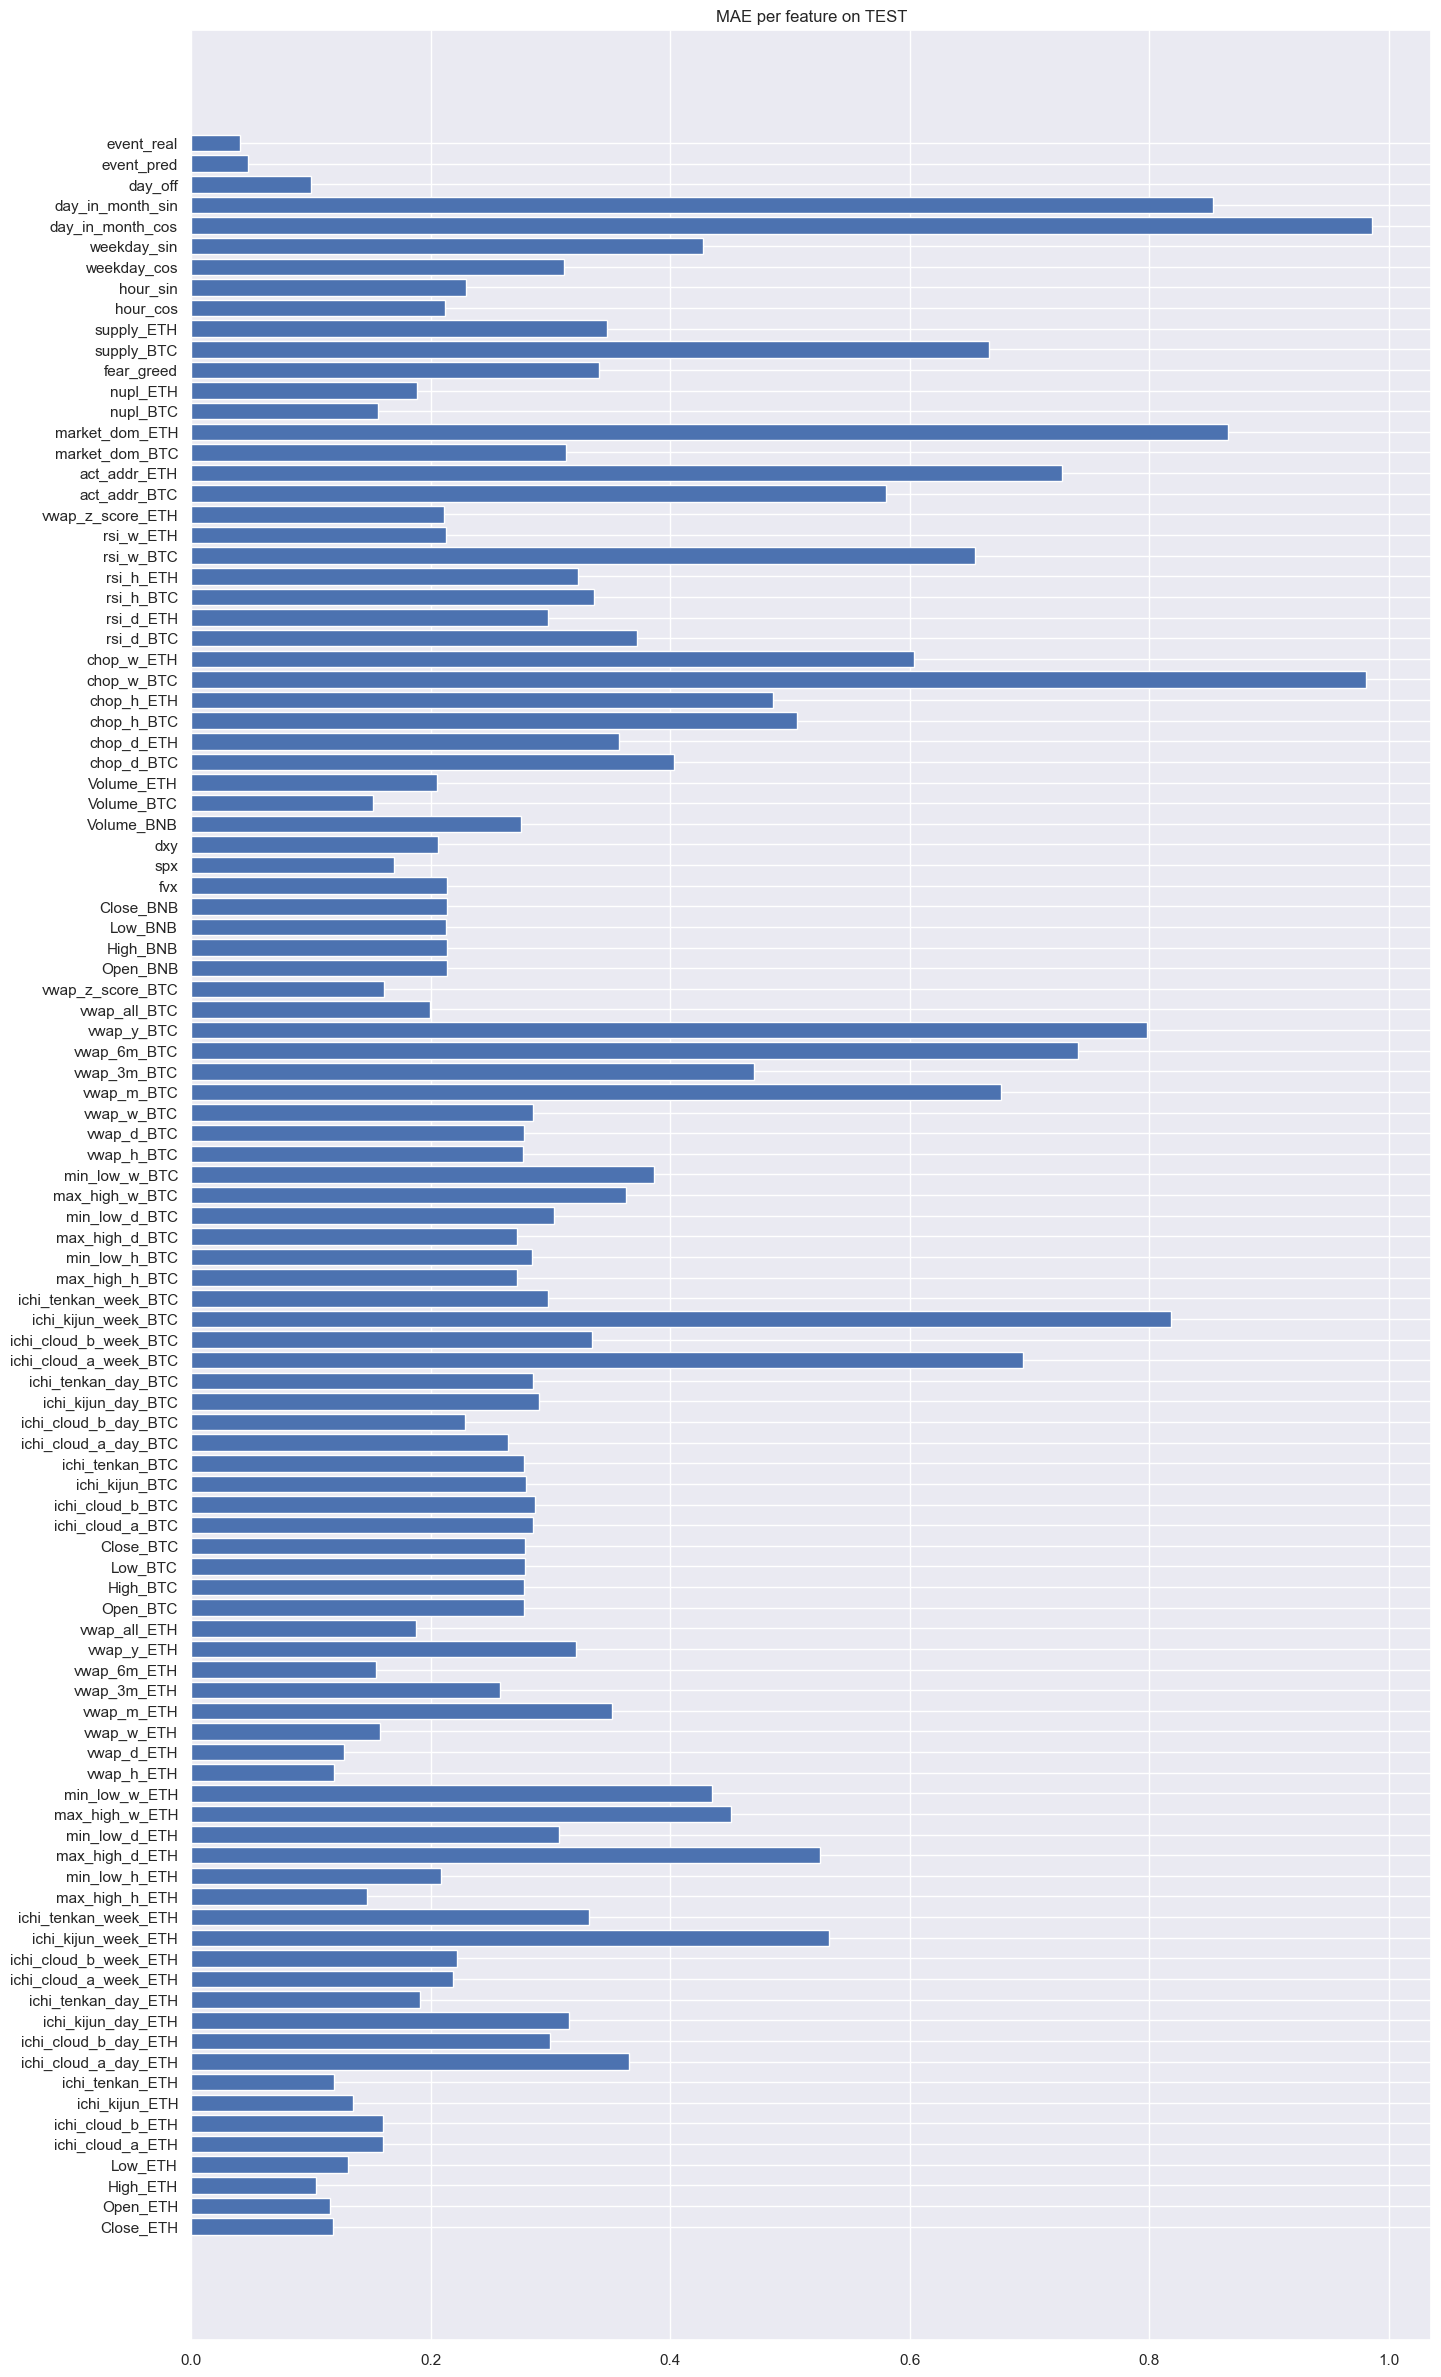

In [116]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_test_feat.columns, df_mae_ae_test_feat.values[0])
plt.title("MAE per feature on TEST")

In [117]:
df_mae_ae_test_feat.values[0]

array([0.11841244, 0.11575121, 0.10447862, 0.13051469, 0.16051456,
       0.1599749 , 0.13532968, 0.11887038, 0.36534028, 0.2996022 ,
       0.31521376, 0.19137748, 0.21863149, 0.22198133, 0.53268812,
       0.33187083, 0.14662223, 0.20829885, 0.52492551, 0.30734018,
       0.45054784, 0.4346183 , 0.11908587, 0.12773457, 0.15801441,
       0.3517515 , 0.25747554, 0.153909  , 0.32133285, 0.18732027,
       0.27824307, 0.27797153, 0.27913552, 0.27860057, 0.28531624,
       0.28696418, 0.27934543, 0.27783855, 0.26461095, 0.22823949,
       0.290134  , 0.28523458, 0.69452364, 0.33506736, 0.81814719,
       0.29799994, 0.27187257, 0.28441388, 0.27229383, 0.30334507,
       0.36319943, 0.38616603, 0.27722749, 0.27781113, 0.28571625,
       0.67661213, 0.47006678, 0.74042013, 0.79827156, 0.19895696,
       0.16077425, 0.2131819 , 0.21355524, 0.21293468, 0.21332545,
       0.21377363, 0.16907044, 0.20576483, 0.27561299, 0.15196227,
       0.20526103, 0.40279826, 0.35754642, 0.50618029, 0.48586

In [118]:
2/df_mae_ae_test_feat.values[0].sum()

0.059336119582558404

In [119]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0       TRAIN   Close_ETH  0.191437
1       TRAIN   Close_ETH  0.152390
2       TRAIN   Close_ETH  0.136865
3       TRAIN   Close_ETH  0.133816
4       TRAIN   Close_ETH  0.132158
...       ...         ...       ...
14683    TEST  event_real  0.039015
14684    TEST  event_real  0.038961
14685    TEST  event_real  0.038917
14686    TEST  event_real  0.038872
14687    TEST  event_real  0.038816

[14688 rows x 3 columns]

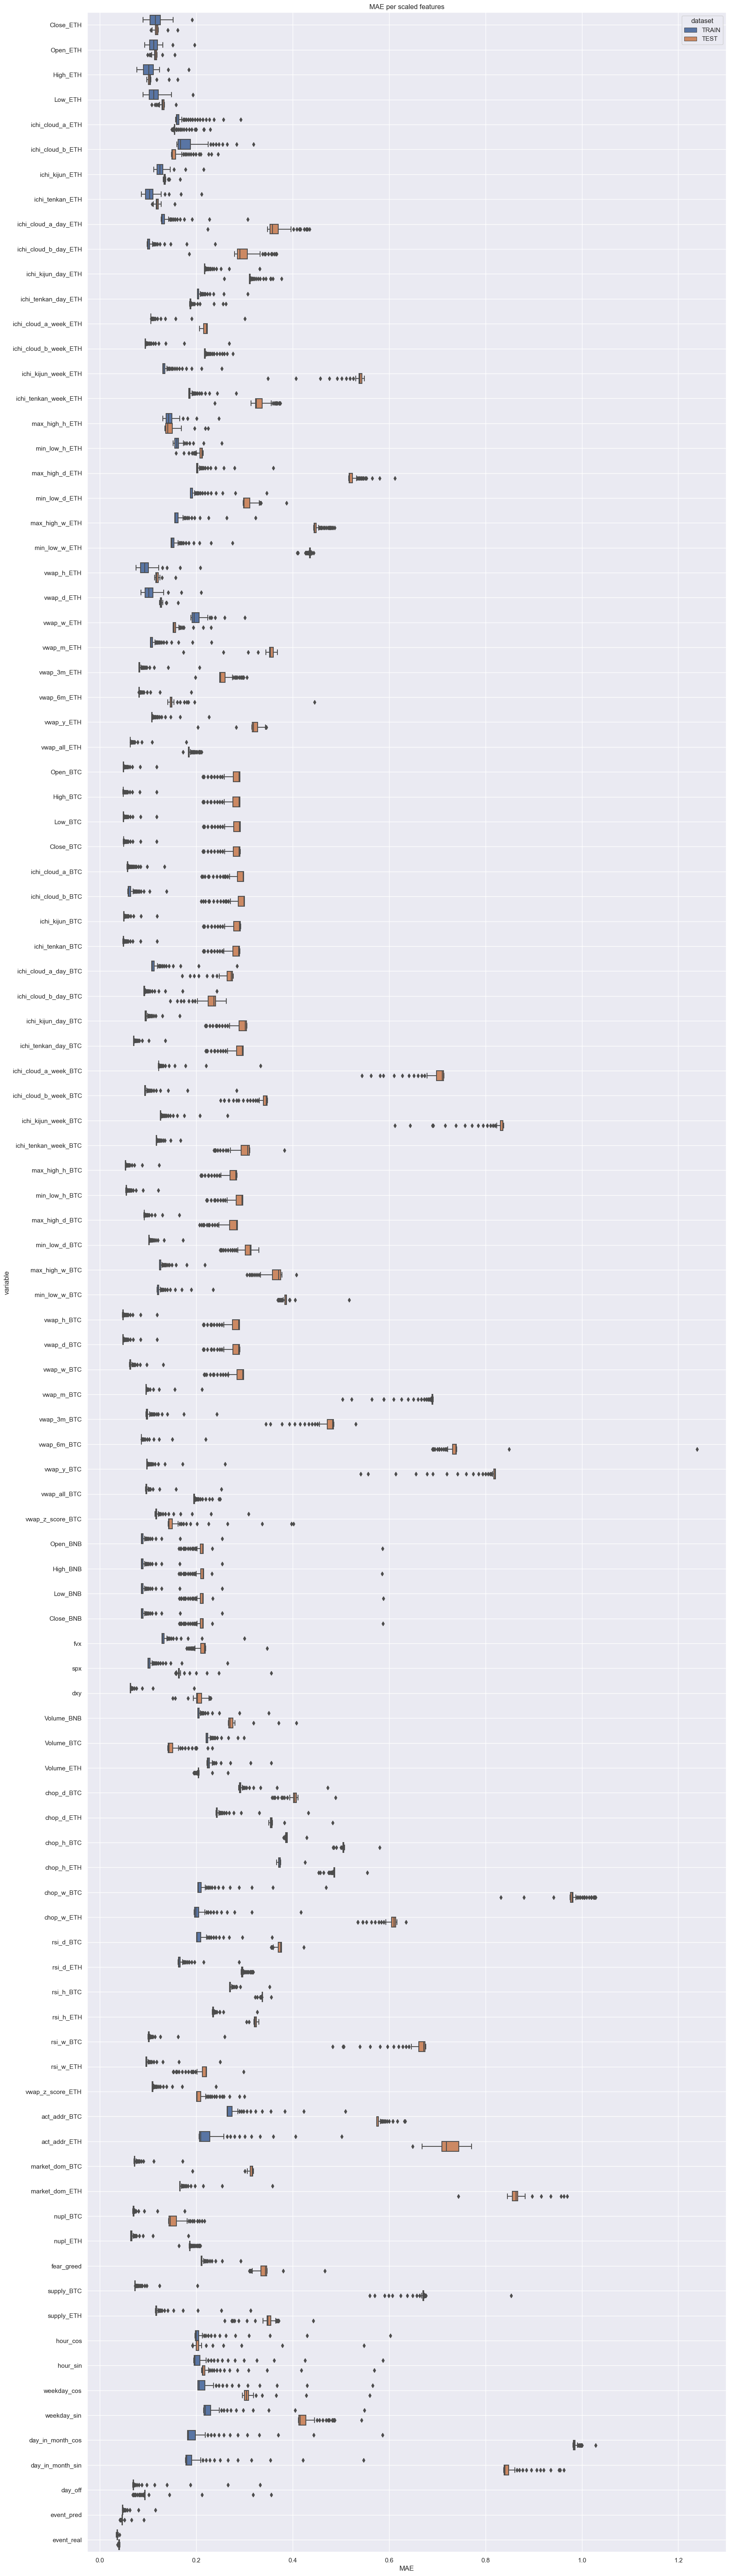

In [120]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MAE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

#### MSE  per features

In [121]:
# values per feat.
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mse_ae_train = np.mean(np.square(X_train_sca_pred - X_train_sca), 0)
print(mse_ae_train.shape)
df_mse_ae_train = pd.DataFrame(mse_ae_train, columns=list_col_select)
df_mse_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_train.index))]

print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mse_ae_test = np.mean(np.square(X_test_sca_pred - X_test_sca), 0)
print(mse_ae_test.shape)
df_mse_ae_test = pd.DataFrame(mse_ae_test, columns=list_col_select)
df_mse_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_test.index))]

# mean per feat.
mse_ae_train_feat = np.mean(mse_ae_train, 0)[np.newaxis,:]
print(mse_ae_train_feat.shape)
df_mse_ae_train_feat = pd.DataFrame(mse_ae_train_feat, columns=list_col_select)

mse_ae_test_feat = np.mean(mse_ae_test, 0)[np.newaxis,:]
print(mse_ae_test_feat.shape)
df_mse_ae_test_feat = pd.DataFrame(mse_ae_test_feat, columns=list_col_select)

# comp train/test
df_mse_ae_test["dataset"] = "TEST"
df_mse_ae_train["dataset"] = "TRAIN"
df_mse_ae_comp = pd.concat([df_mse_ae_train, df_mse_ae_test], ignore_index=False)

df_mse_ae_test_feat["dataset"] = "TEST"
df_mse_ae_train_feat["dataset"] = "TRAIN"
df_mse_ae_comp_feat = pd.concat([df_mse_ae_train_feat, df_mse_ae_test_feat], ignore_index=False)

df_mse_ae_comp = df_mse_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MSE")



(54051, 72, 102)
(54051, 72, 102)
(72, 102)
(13446, 72, 102)
(13446, 72, 102)
(72, 102)
(1, 102)
(1, 102)


In [122]:
df_mse_ae_comp_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.029441  0.027957  0.023374  0.027359          0.116865   
0   0.032232  0.028859  0.022814  0.037144          0.053699   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.112989        0.034207         0.023767              0.035093   
0          0.058054        0.038997         0.027023              0.162918   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0              0.022056  ...  0.068731  0.070575     0.076628     0.083182   
0              0.122362  ...  0.071953  0.077964     0.140493     0.327889   

   day_in_month_cos  day_in_month_sin   day_off  event_pred  event_real  \
0          0.068429          0.065453  0.055338    0.985510    0.997491   
0          1.401420          0.897462  0.018518    0.918643    1.606963   

   dataset  
0    TRAIN  
0     TEST  

[2 rows x 103 columns]

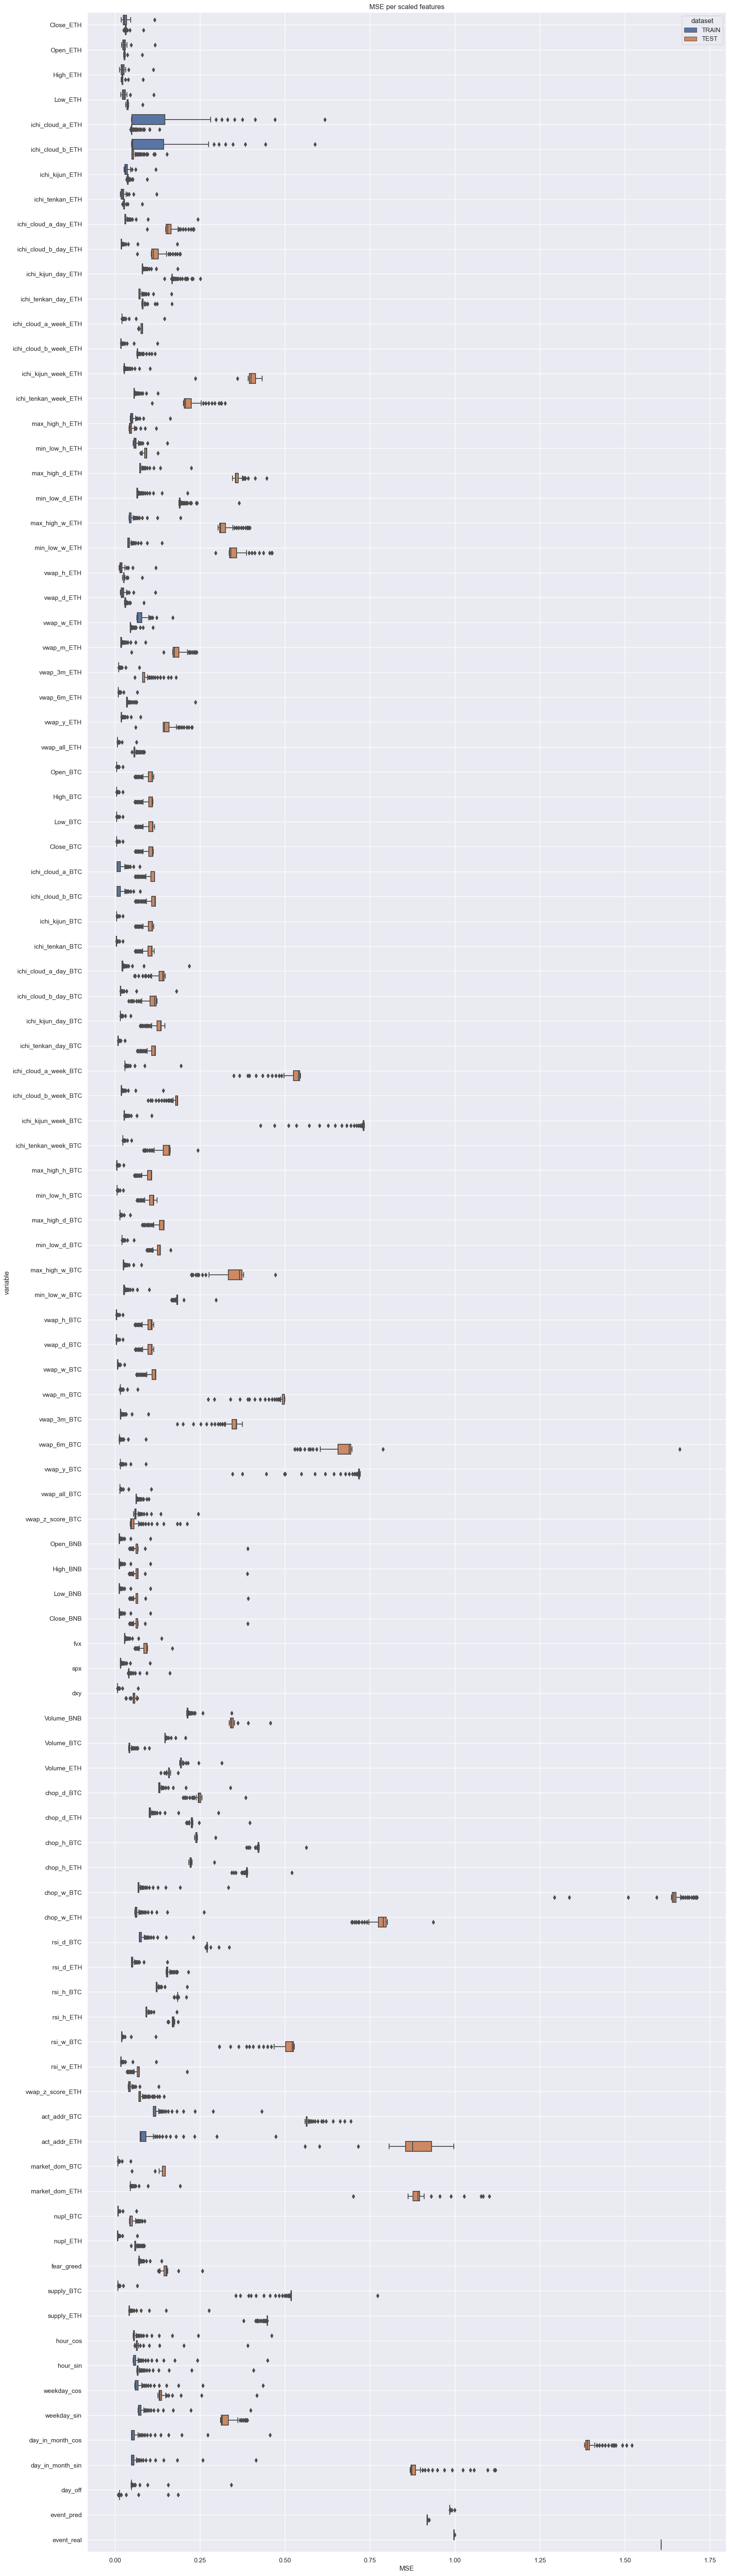

In [123]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_mse_ae_comp, x="MSE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MSE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MSE - {name_plt}.jpg")
)

Text(0.5, 1.0, 'MSE per feature on TRAIN')

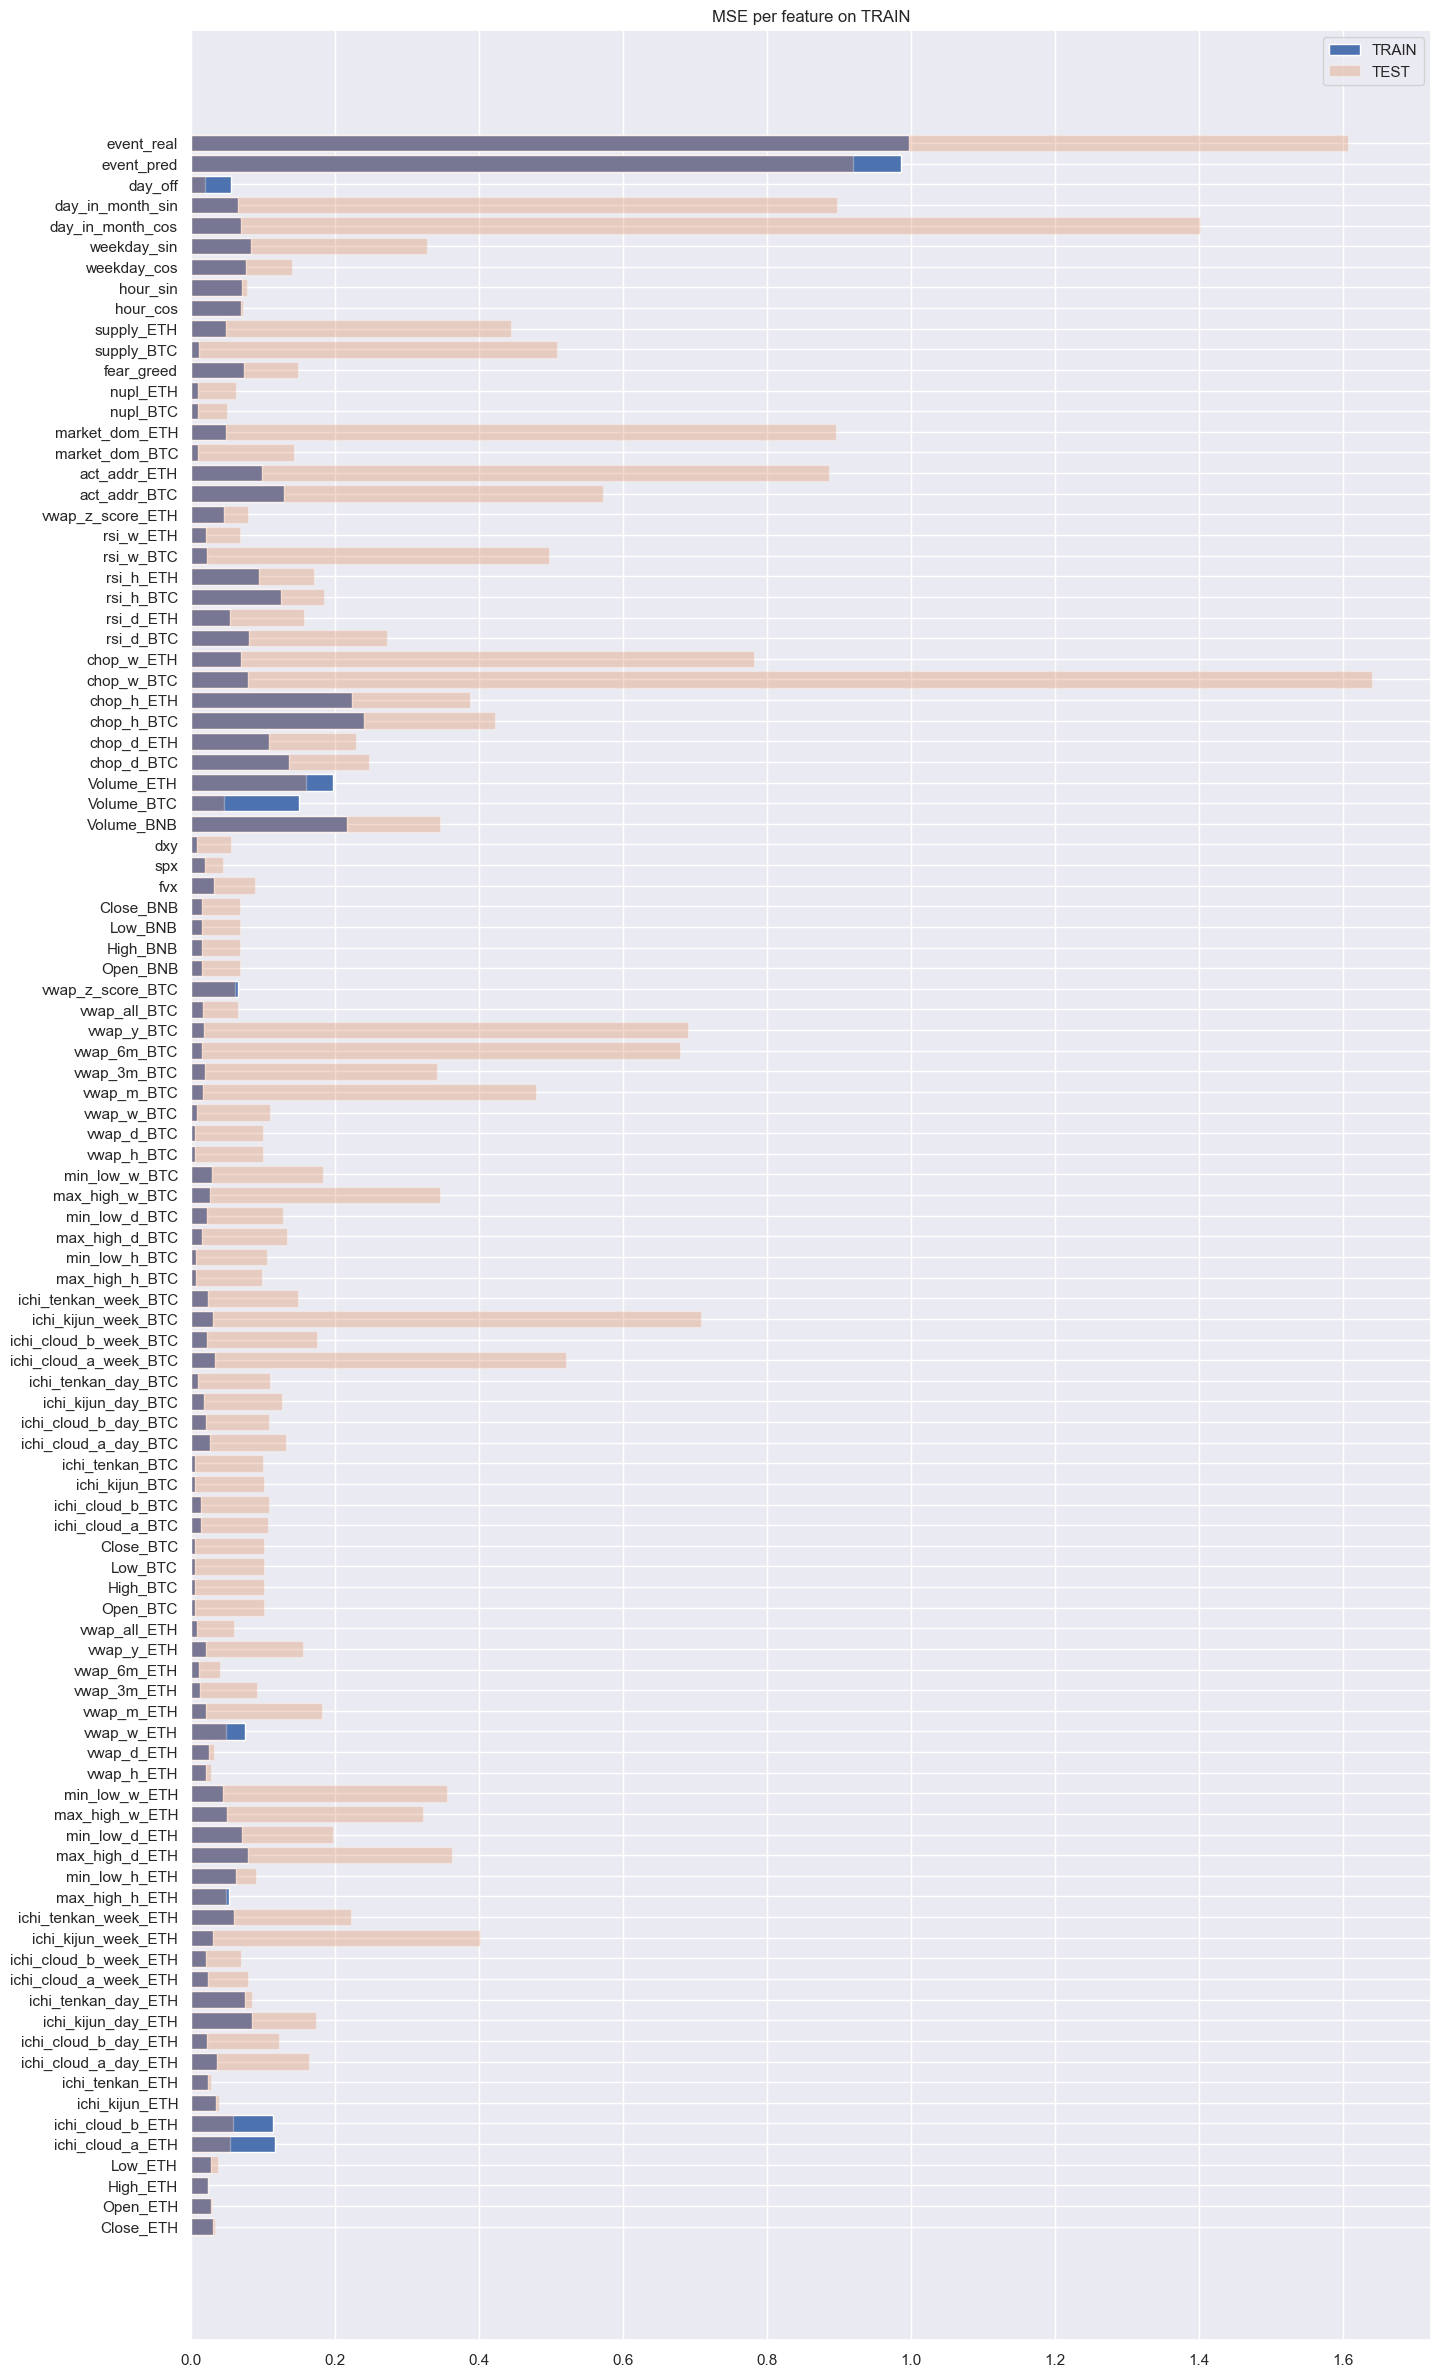

In [124]:
plt.figure(figsize=(16, 30))
plt.barh(list_col_select, df_mse_ae_train_feat.values[0,:-1], label="TRAIN")
plt.barh(list_col_select, df_mse_ae_test_feat.values[0,:-1], label="TEST", alpha=0.3)
plt.legend(loc='upper right')
#plt.barh(df_mse_ae_test_feat.columns, df_mse_ae_test_feat.values[0])
plt.title("MSE per feature on TRAIN")

In [125]:
encoder_model.layers[3].get_weights()

[array([[ 0.04108637, -0.17984025, -0.10649569, ..., -0.2270599 ,
          0.07100573,  0.38456196],
        [ 0.04566719,  0.06323217, -0.20245846, ..., -0.04891957,
          0.03919136,  0.26597777],
        [-0.41343817, -0.10003106, -0.40696988, ..., -0.05337881,
          0.40466857,  0.0499523 ],
        ...,
        [ 0.08813696, -0.10879647,  0.2015854 , ..., -0.19060424,
          0.30086815,  0.06916534],
        [-0.16727625, -0.14083526, -0.00130481, ..., -0.11823906,
          0.06093629,  0.29377037],
        [ 0.10701852, -0.10515004, -0.35126495, ..., -0.05769081,
          0.5233831 , -0.10425255]], dtype=float32),
 array([ 0.16367069,  0.57602865, -0.13275713, -0.28008646,  0.08608475,
         0.14709899,  0.56396246, -0.03397703,  0.45695487, -0.27002022,
         0.01684462, -0.55592495,  0.12863655, -0.32223076,  0.29442054,
         0.28562397], dtype=float32)]

## Prediction Models

### LSTM all features

In [126]:
X_train_sca.shape

(54051, 72, 102)

In [127]:
X_train_sca.shape[-1]

102

In [128]:
X_train_sca.shape[-2:]

(72, 102)

In [129]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    patience = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=patience,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [130]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [131]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

1690/1690 [==============================] - 22s 13ms/step


(54051, 72, 16)

In [132]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

421/421 [==============================] - 5s 13ms/step


(13446, 72, 16)

In [133]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



reloading scaler_enc...


In [134]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [135]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [136]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((54051, 72, 20), (13446, 72, 20))

#### Correlations

In [137]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



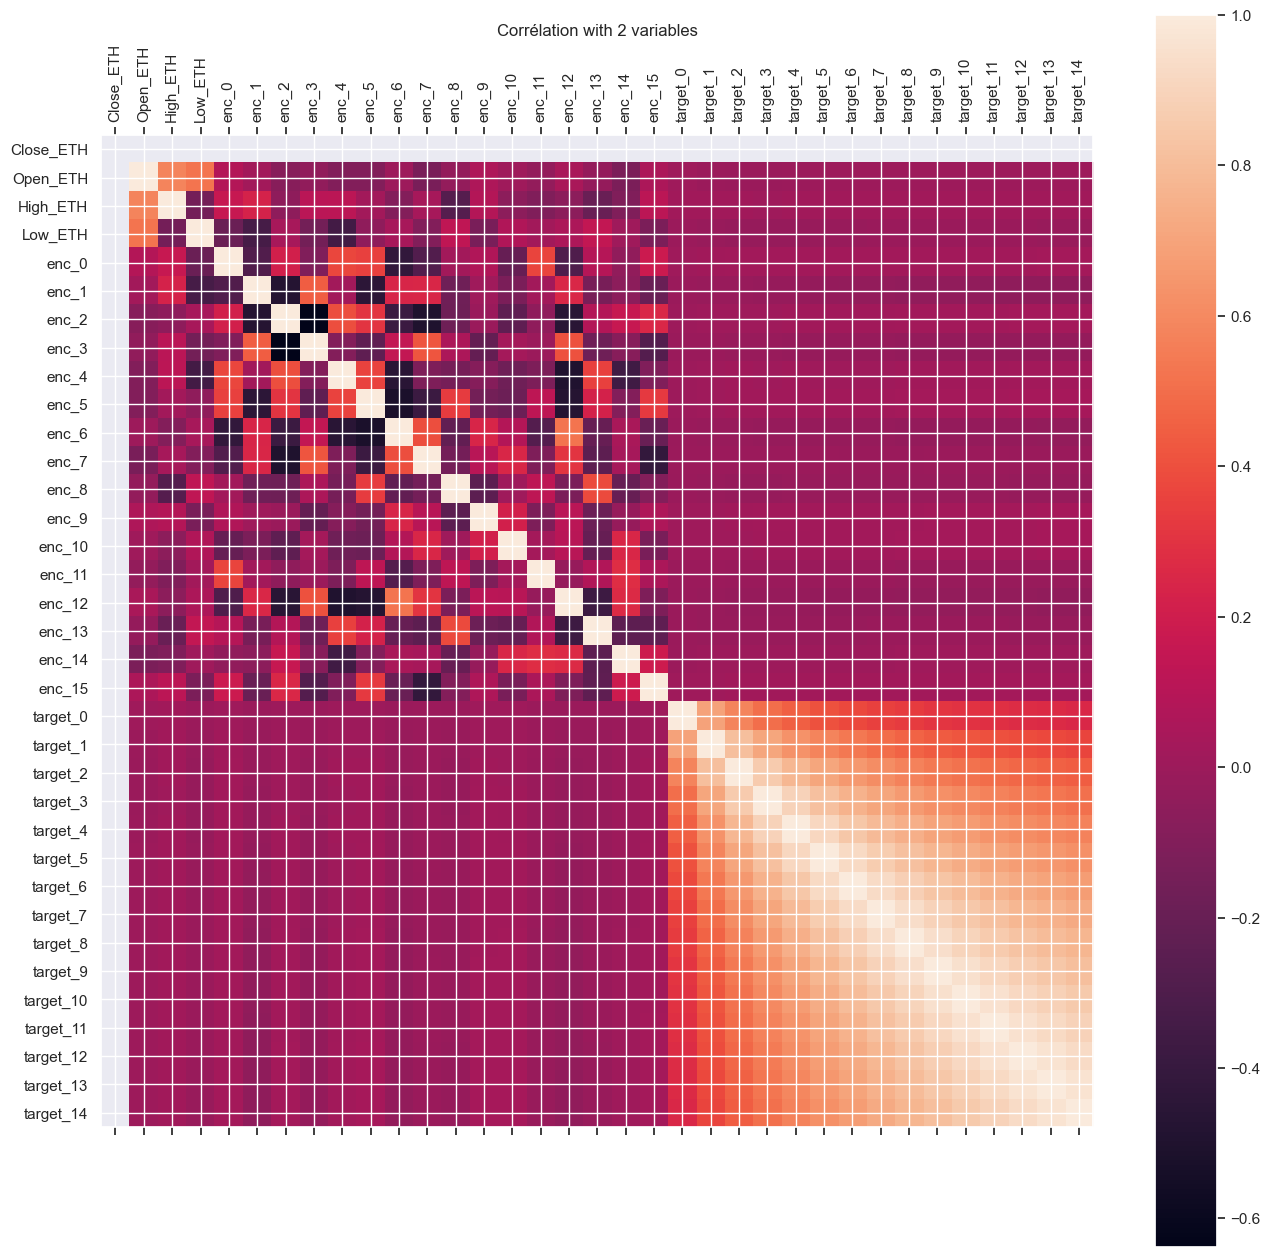

In [138]:
fig = plot_corr(corr_matrix_min)

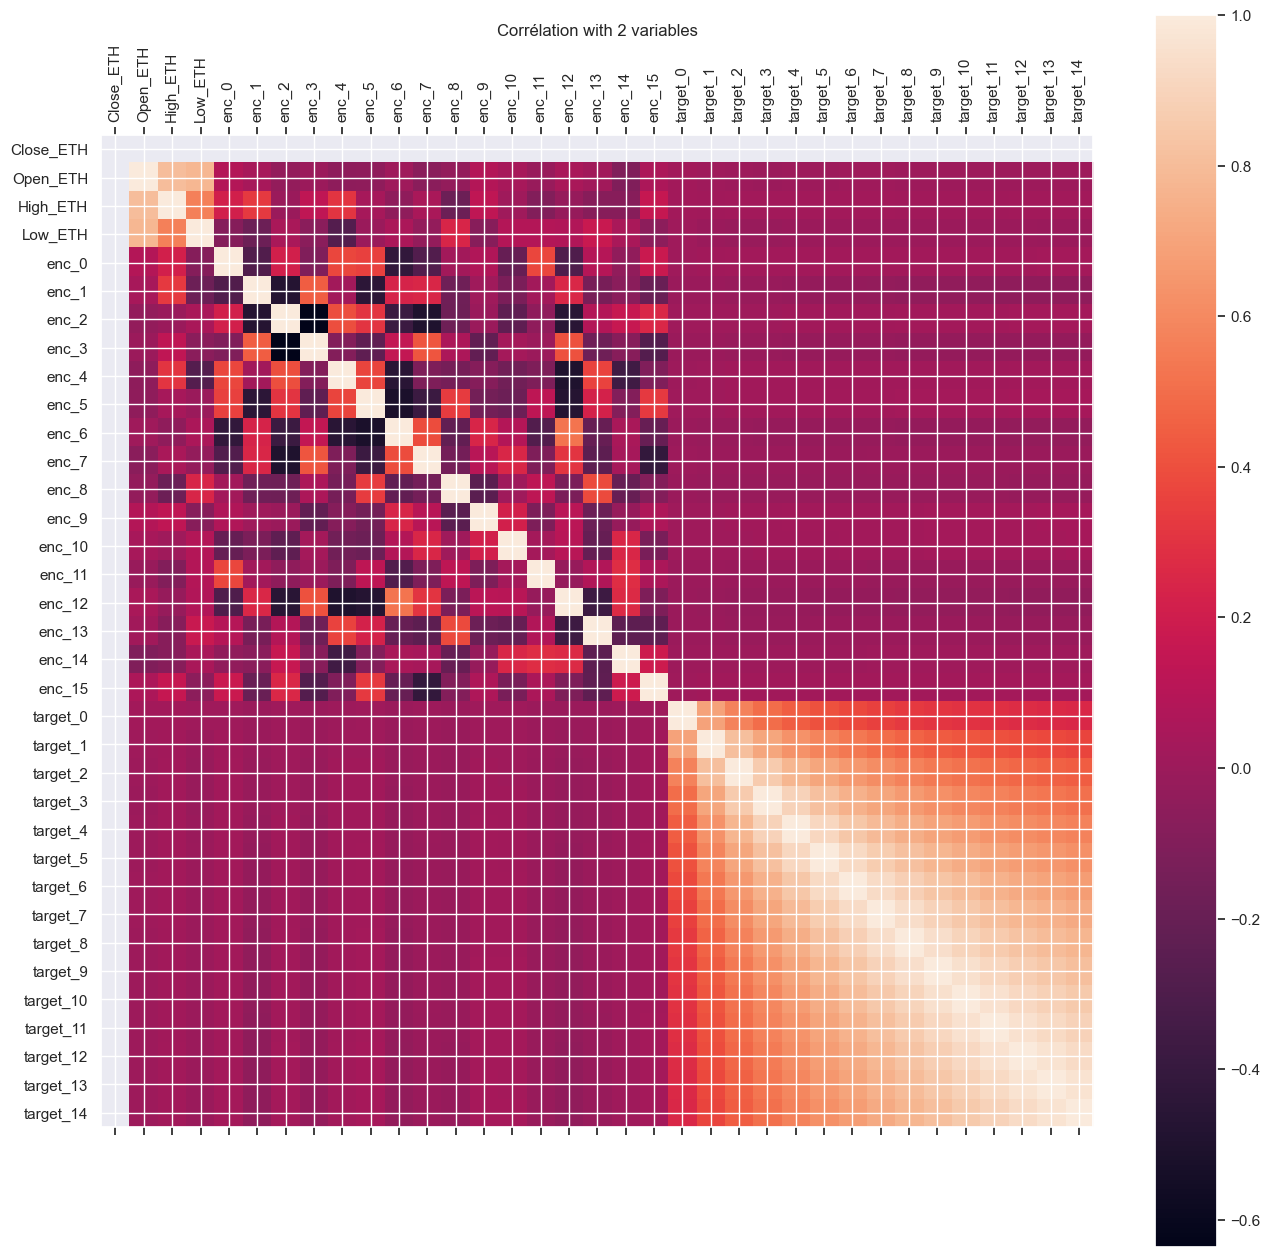

In [139]:
fig = plot_corr(corr_matrix_max) 

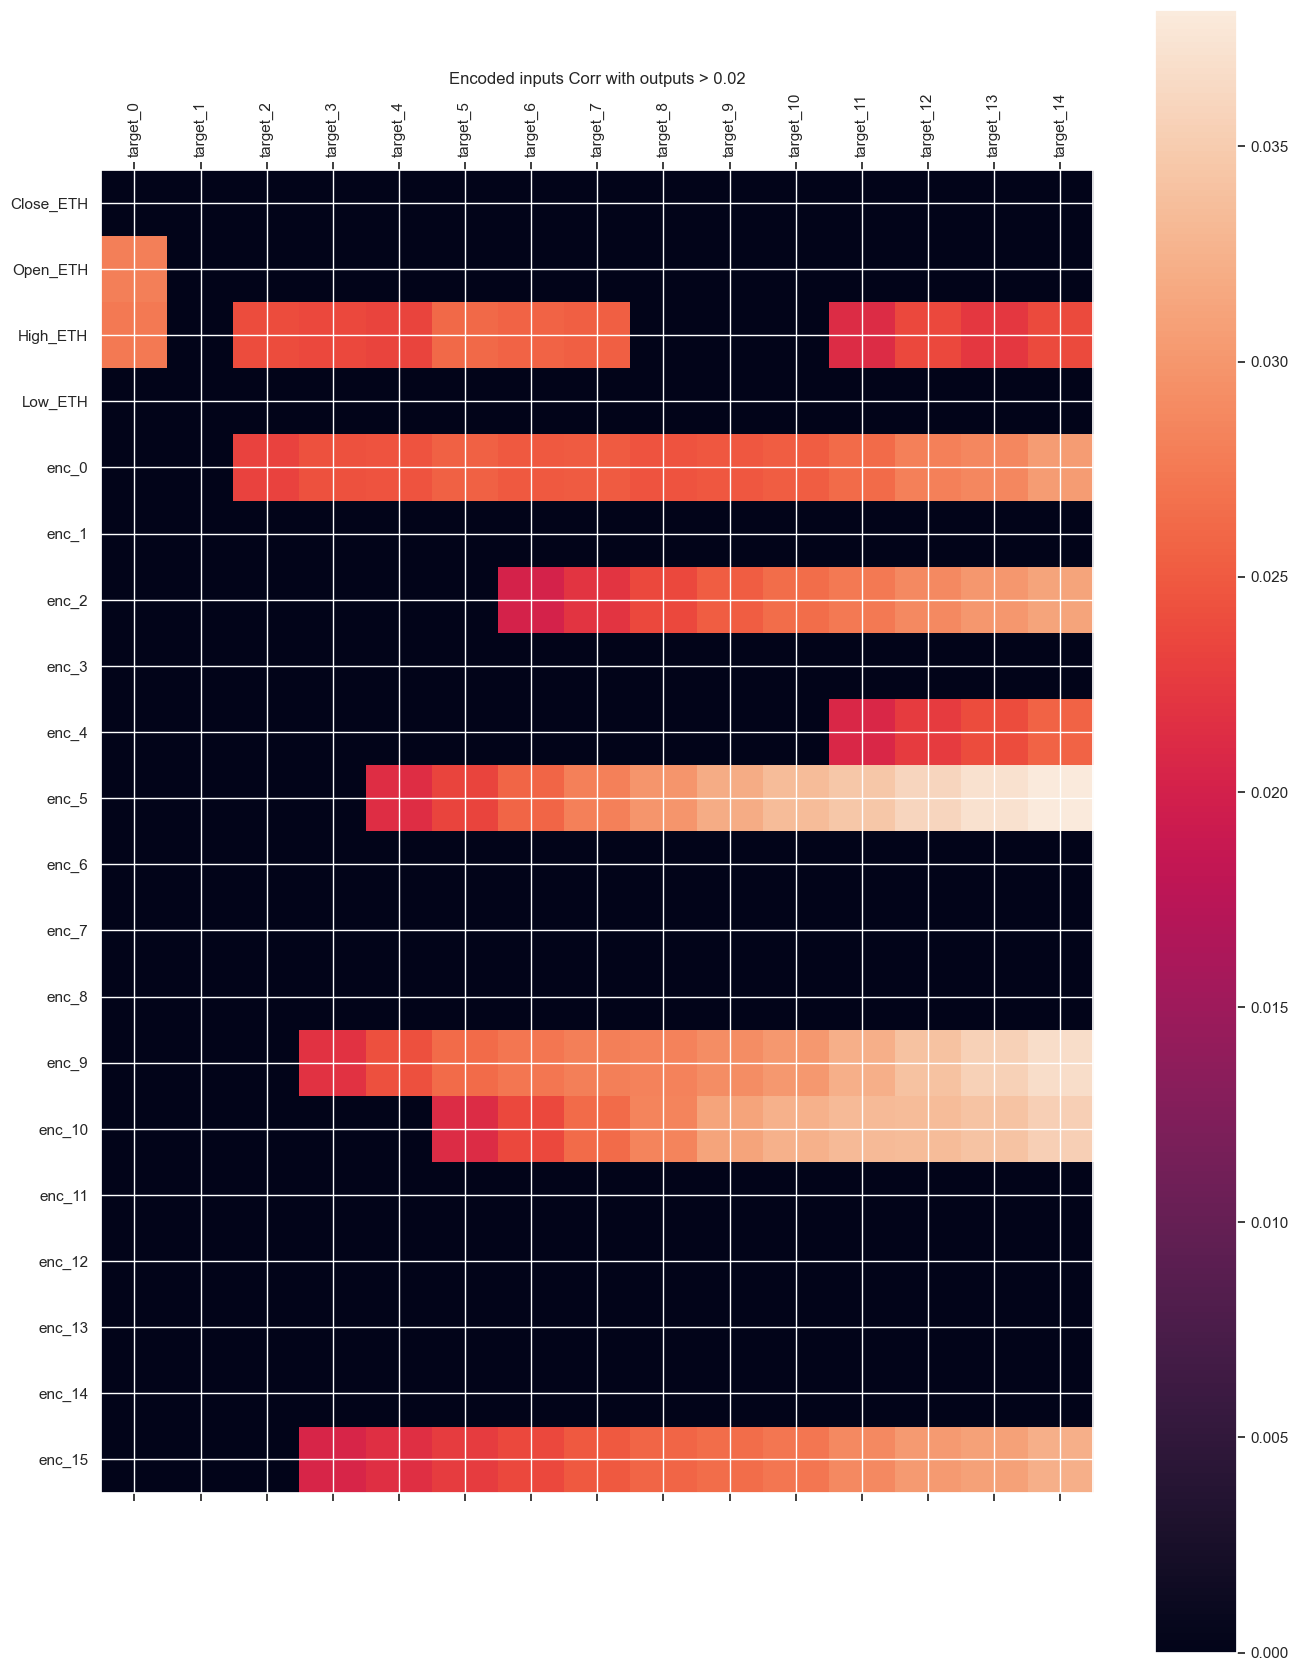

In [140]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

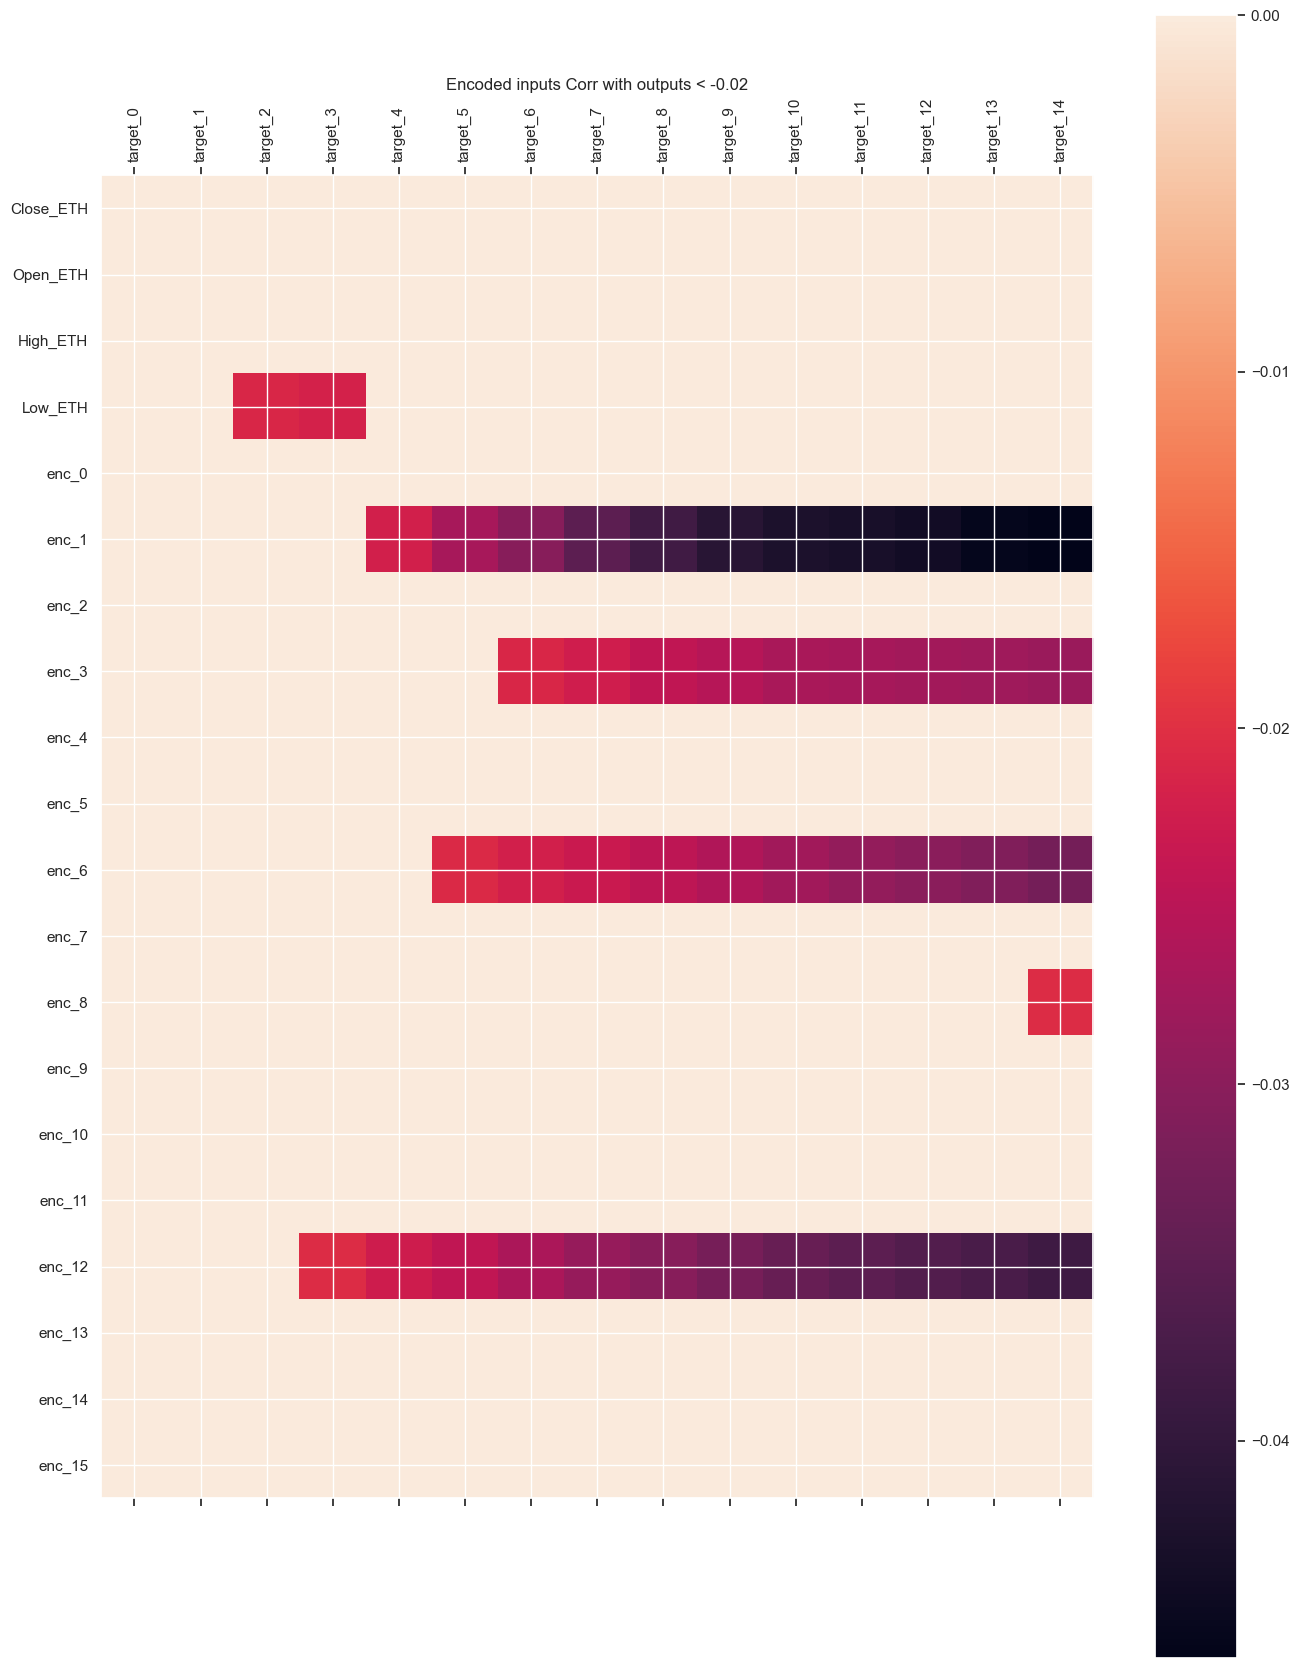

In [141]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [142]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [143]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [144]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [145]:
MODE_AUTO_SELECT

2

In [146]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 15]
nb encoded features:  12


In [147]:
X_train_.shape

(54051, 72, 20)

In [148]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 16, 19])

In [149]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [150]:
X_train_.shape

(54051, 72, 16)

#### Train

In [151]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 20#30
patience = 0#10
#dropout_rate = 0.25#0.1
#n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)
seed = 1
mse_curr_min = None
if MODE_TRAIN_PREDICTOR:
    for n_units in [128]: #[32, 64, 128]: #[128]: #
        for dropout_rate in  [0.15]: #[0.05, 0.15, 0.25]: #[0.1]:

            tf.keras.backend.clear_session()
            np.random.seed(seed)
            random.seed(seed)
            tf.random.set_seed(seed)
            optim = tf.keras.optimizers.legacy.Adam()
            if patience is not None:
                es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                verbose=1, patience=patience,
                                                restore_best_weights=True)
            # create model
            multi_step_model = tf.keras.models.Sequential()
            multi_step_model.add(
                tf.keras.layers.LSTM(
                    n_units,
                    return_sequences=False,
                    input_shape=X_train_.shape[-2:],
                    #kernel_regularizer=reg,
                    #bias_regularizer=reg,
                )
            )
            multi_step_model.add(tf.keras.layers.LayerNormalization())
            multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
            #multi_step_model.add(tf.keras.layers.BatchNormalization())
            multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
            # compile
            multi_step_model.compile(optimizer=optim, loss='mse')
            # fitting
            if patience == 0:
                multi_step_history = multi_step_model.fit(
                    X_train_, y_train_sca, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test_, y_test_sca), 
                    verbose=1,
                )
            else:
                multi_step_history = multi_step_model.fit(
                    X_train_, y_train_sca, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test_, y_test_sca), 
                    verbose=1, 
                    callbacks=[es],
                )
            # eval
            mse_curr = np.min(multi_step_history.history['val_loss'])
            print("MSE TEST : ", mse_curr)

            # plot MSE
            name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
            plot_train_history(
                multi_step_history,
                f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
                saveFolder="data",
            )

            # save the best
            if mse_curr_min == None:
                mse_curr_min = mse_curr
                n_units_min = n_units
                dropout_rate_min = dropout_rate

                print("Save model: ", path_mdl_predict_autoenc_lstm)
                multi_step_model.save(path_mdl_predict_autoenc_lstm)
            else:
                if mse_curr < mse_curr_min:
                    mse_curr_min = mse_curr
                    n_units_min = n_units
                    dropout_rate_min = dropout_rate
                    print("Save model: ", path_mdl_predict_autoenc_lstm)
                    multi_step_model.save(path_mdl_predict_autoenc_lstm)
    
    n_units = n_units_min#32
    dropout_rate = dropout_rate_min #0.25
    mse_curr = mse_curr_min

else:
    
    print("Load model: ", path_mdl_predict_autoenc_lstm)
    multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
    n_units = multi_step_model.layers[0].units#32
    dropout_rate = multi_step_model.layers[2].rate#0.25
    print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")
    print(multi_step_model.summary())

Load model:  data/mdl_predict_autoenc_lstm
Best model: n_units=128 / dropout= 0.15
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               74240     
                                                                 
 layer_normalization (Layer  (None, 128)               256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 15)                1935      
                                                                 
Total params: 76431 (298.56 KB)
Trainable params: 76431 (298.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
N

In [152]:
 print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")

Best model: n_units=128 / dropout= 0.15


In [153]:
np.min(y_train)

0.925613296000411

In [154]:
np.max(y_train)

1.0749270774292548

#### Results

##### Save mdl

In [155]:
X_train_.shape

(54051, 72, 16)

##### Predict

In [156]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

421/421 [==============================] - 5s 12ms/step


##### Plots

In [157]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(54060,)
(54060,)


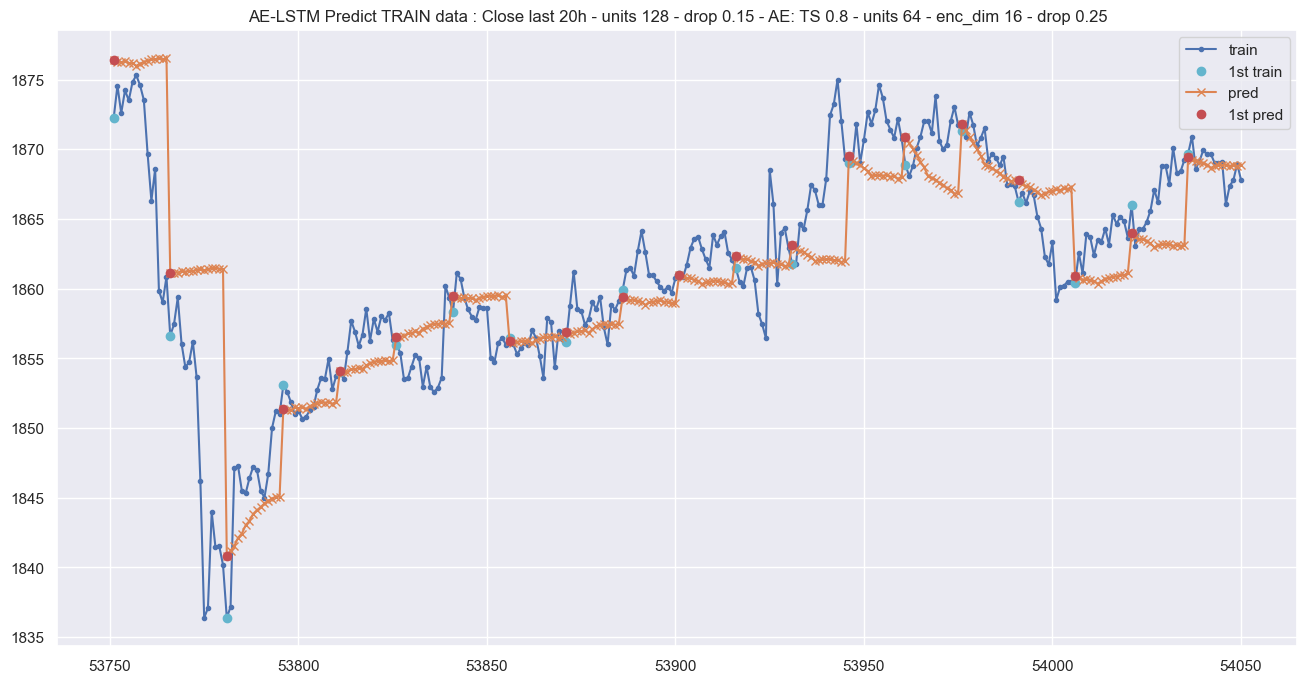

In [158]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

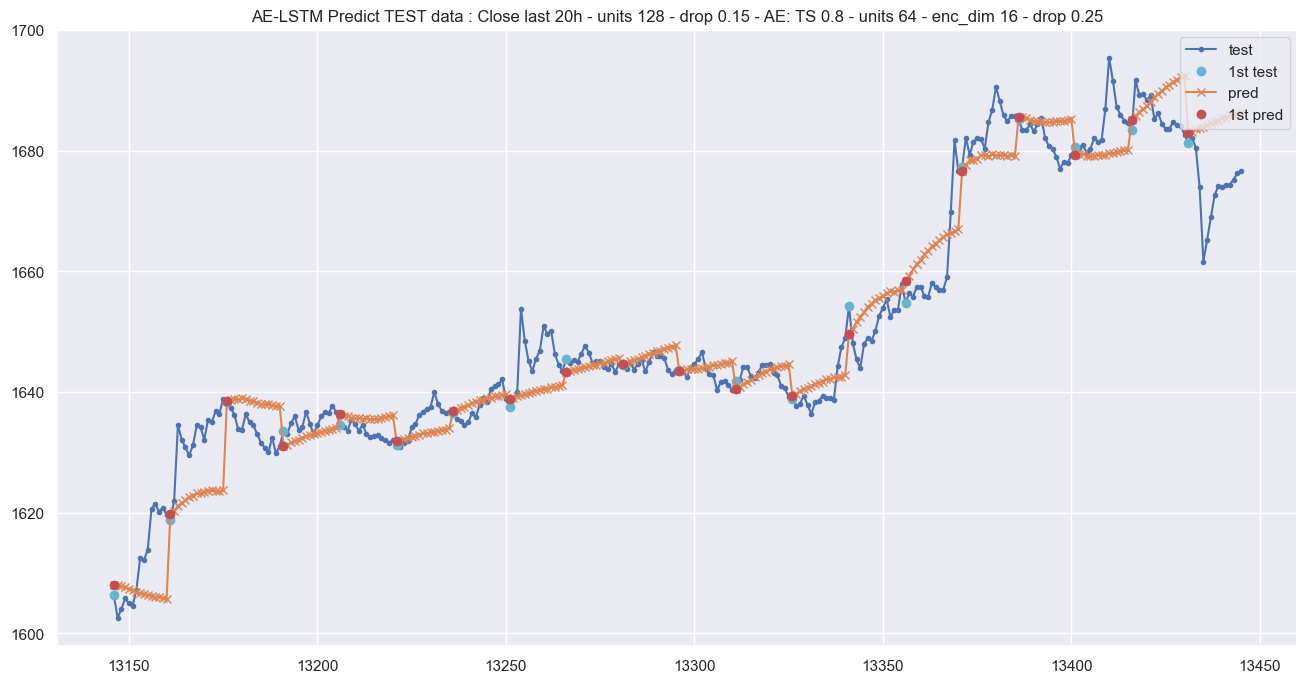

In [159]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

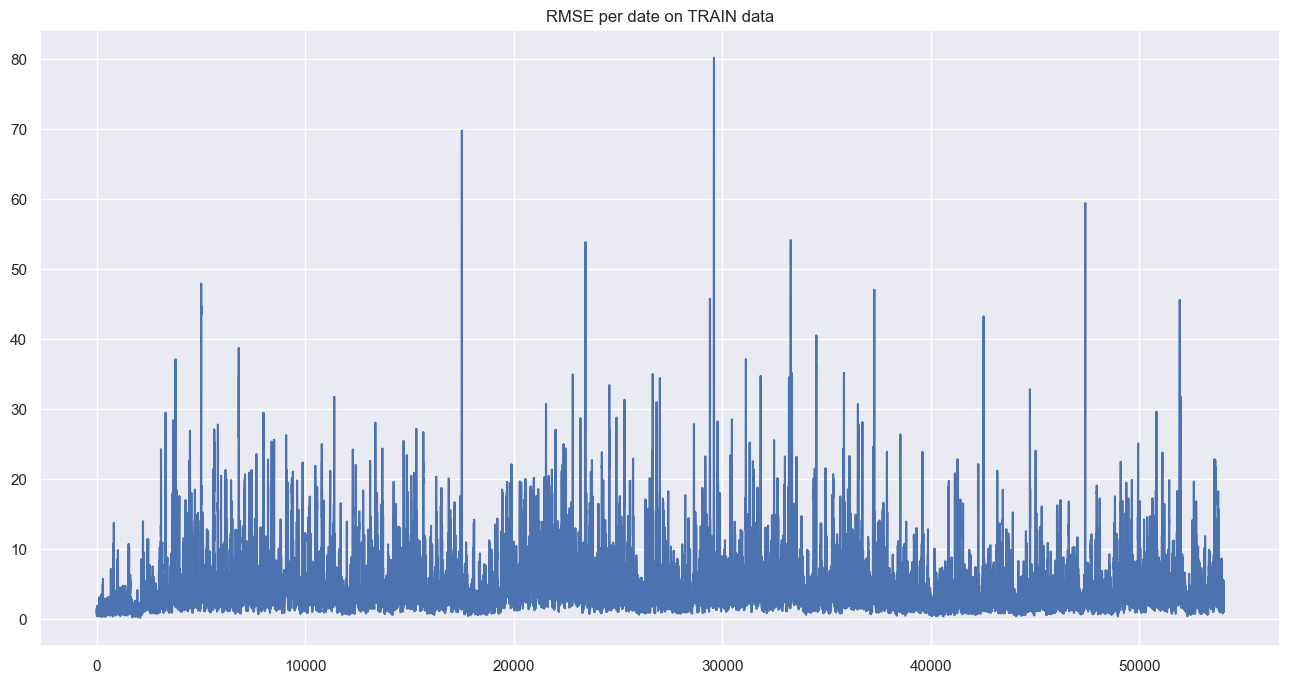

In [160]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

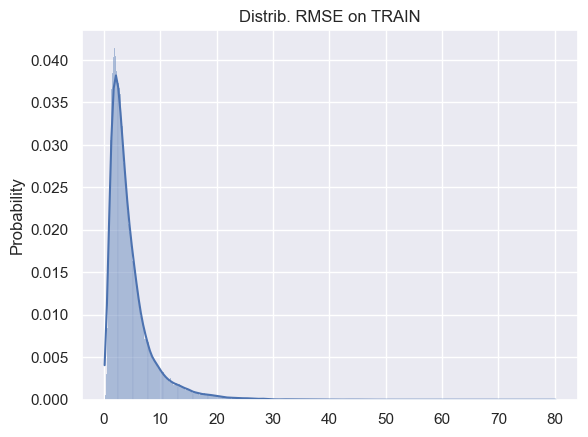

In [161]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 4.70')

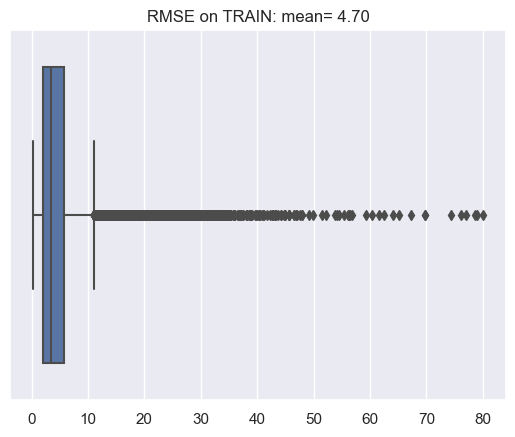

In [162]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

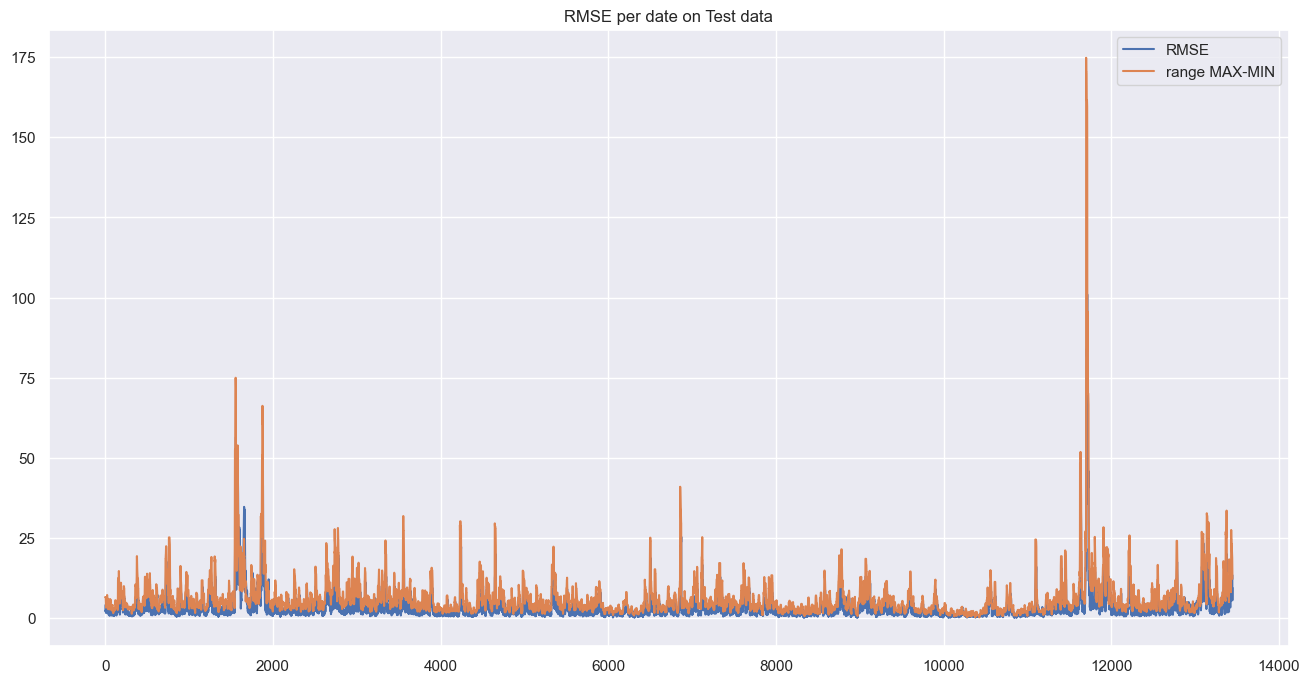

In [163]:
arr_mse = np.zeros((y_test_raw.shape[0]))
arr_range = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
    arr_range[i_date] = np.max(y_test_raw[i_date]) - np.min(y_test_raw[i_date])
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="RMSE")
plt.plot(arr_range, label="range MAX-MIN")
plt.legend(loc='upper right')

In [164]:
np.mean(arr_range)

6.573147404432546

<AxesSubplot: ylabel='Probability'>

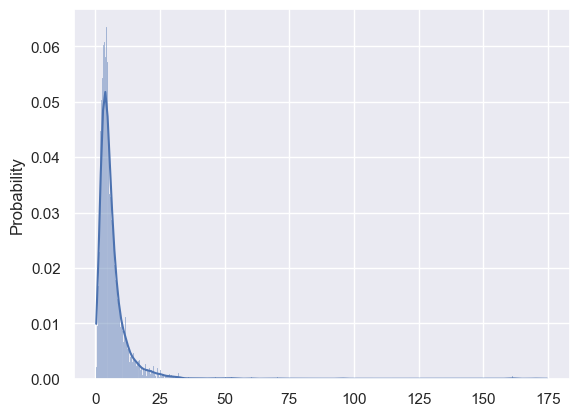

In [165]:
sns.histplot(x=arr_range,  stat="probability", kde=True)

In [166]:
np.mean(3*np.sqrt(np.var(y_test_raw, axis=1)))

5.859505072866659

<AxesSubplot: ylabel='Probability'>

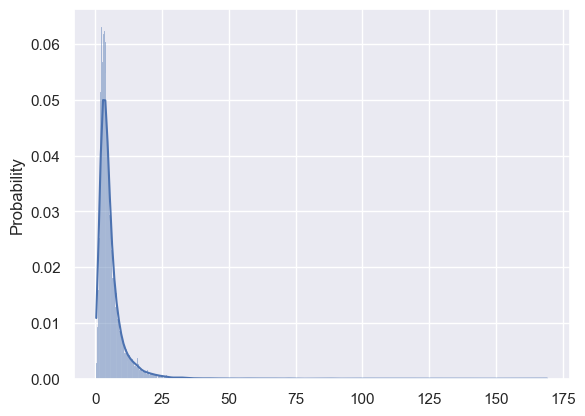

In [167]:
sns.histplot(x=3*np.sqrt(np.var(y_test_raw, axis=1)),  stat="probability", kde=True)

Text(0.5, 1.0, 'probability of RSME on each sequence')

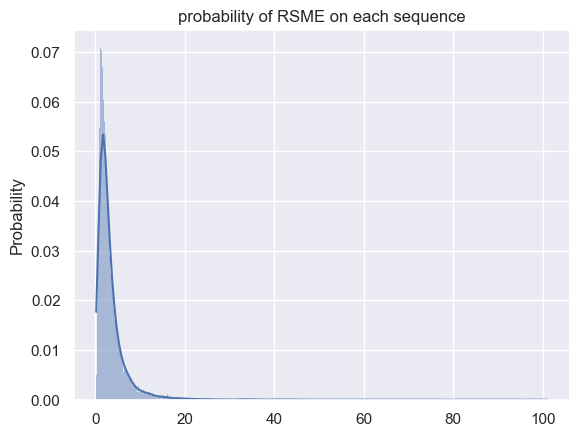

In [168]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)
plt.title("probability of RSME on each sequence")

(0.0, 32.865737022162726)

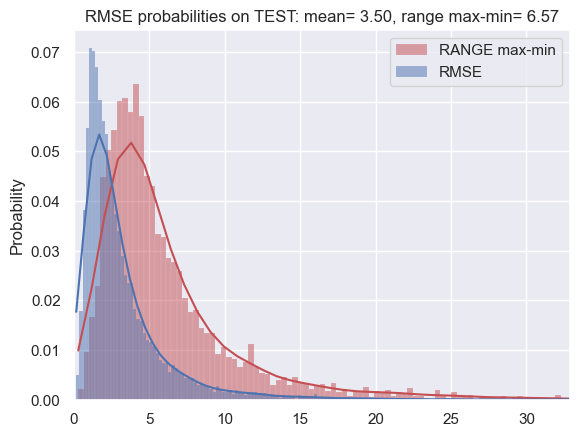

In [169]:
ax = sns.histplot(x=arr_range,  stat="probability", kde=True, label="RANGE max-min", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="RMSE", ax=ax)
plt.title(f"RMSE probabilities on TEST: mean= {np.mean(arr_mse):.2f}, range max-min= {np.mean(arr_range):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_range)*5])

(0.0, 17.520917821596377)

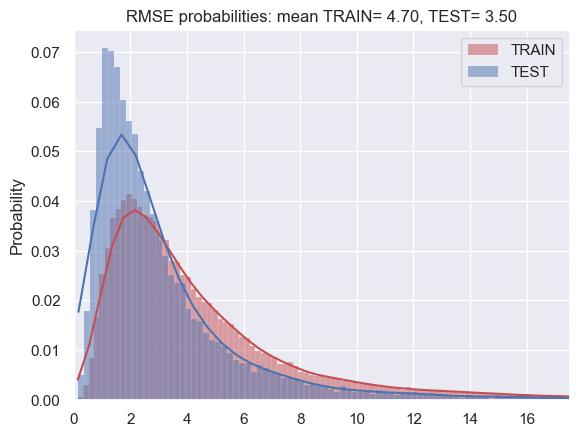

In [170]:
ax = sns.histplot(x=arr_mse_train,  stat="probability", kde=True, label="TRAIN", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="TEST", ax=ax)
plt.title(f"RMSE probabilities: mean TRAIN= {np.mean(arr_mse_train):.2f}, TEST= {np.mean(arr_mse):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_mse)*5])

Text(0.5, 1.0, 'RMSE on TEST: mean= 3.50')

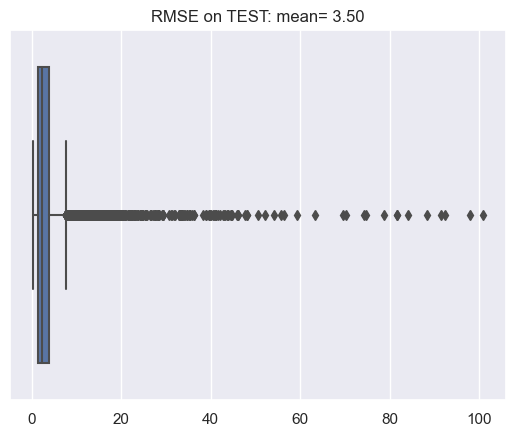

In [171]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [172]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1673.98 1661.62 1665.26 1669.04 1672.71 1674.14 1673.95 1674.39 1674.39
 1675.23 1676.25 1676.64 1675.99 1675.24 1676.19]
[1681.00426054 1681.68477757 1682.55680895 1683.3028335  1683.75577698
 1684.50620876 1685.20796064 1685.74444124 1686.1569183  1686.84584913
 1687.11889732 1687.61471117 1687.78679363 1688.04842308 1688.29102129]


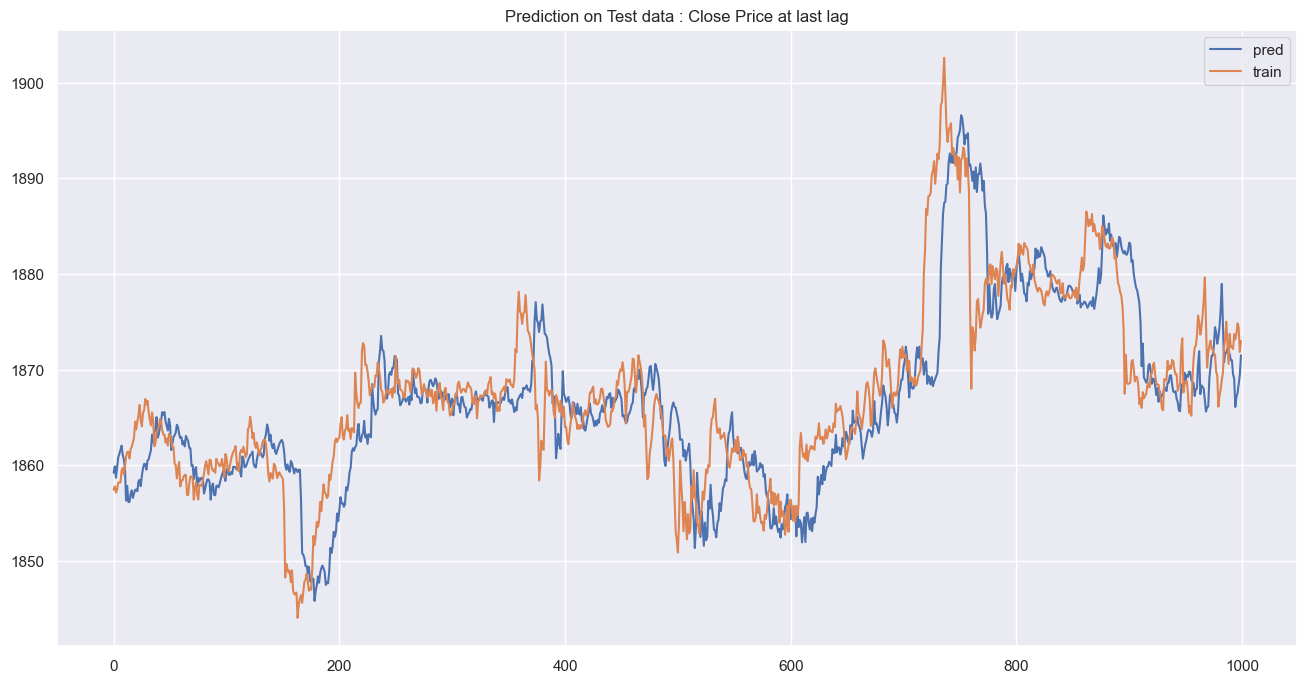

In [173]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

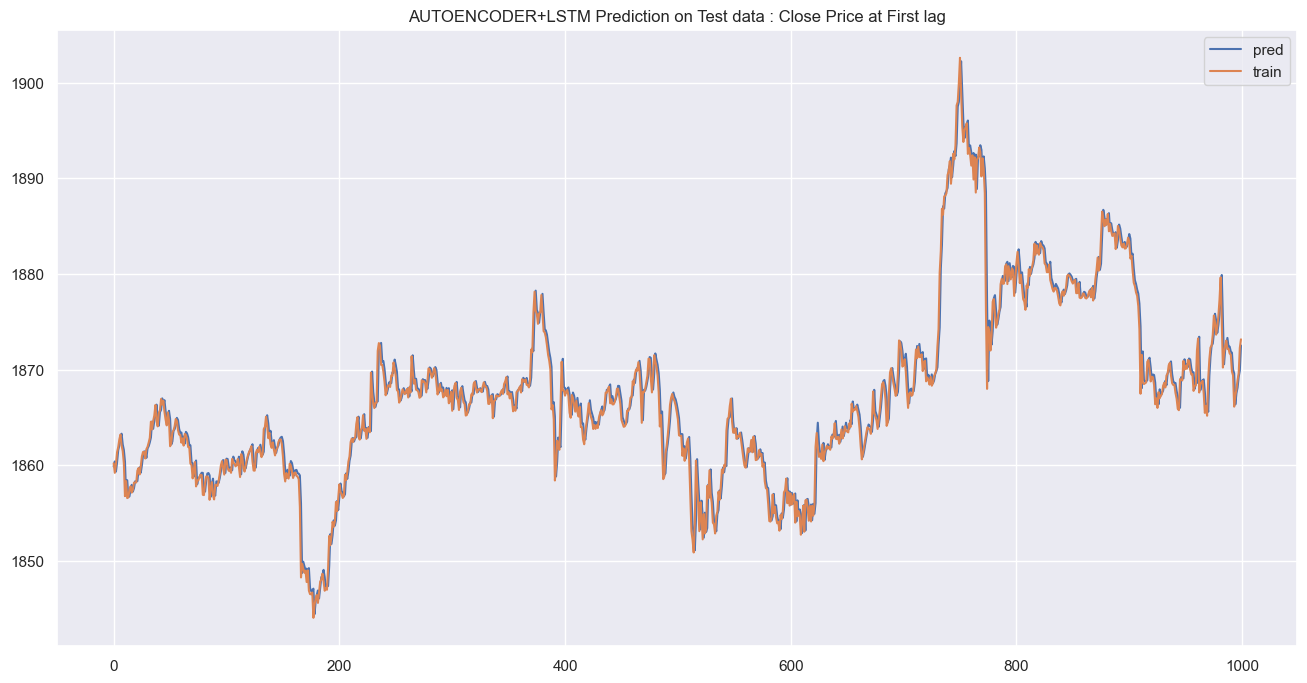

In [174]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

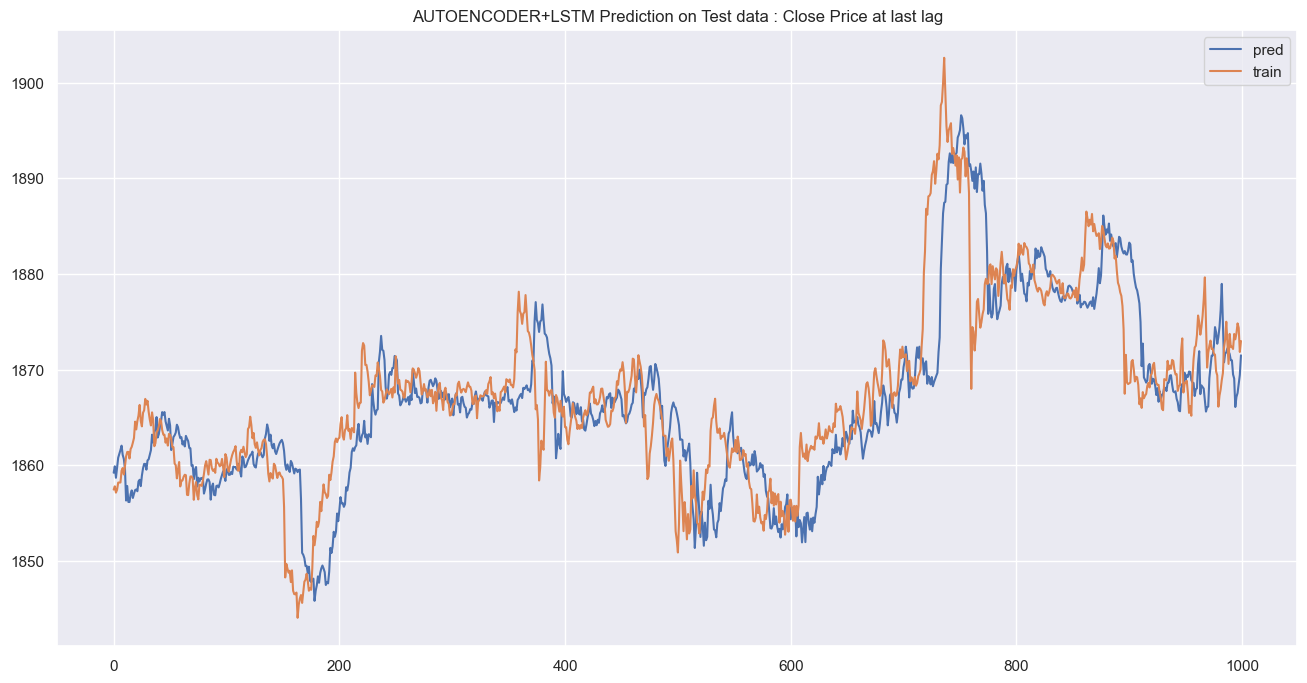

In [175]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [176]:
X_test_sca.shape

(13446, 72, 102)

In [177]:
df_feat["Close_ETH"].iloc[-1]

1677.51

In [178]:
df_feat["Close_ETH"].iloc[-1]

1677.51

In [179]:
len(list_i_enc_select)

12

In [180]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[1690.59 1688.18 1685.85 1684.85 1685.76 1685.79 1685.19 1683.36 1683.41
 1684.38 1683.2  1684.39 1685.48 1682.19 1680.73 1680.24 1679.03 1677.01
 1678.21 1677.99 1679.29 1680.62 1680.49 1680.99 1679.71 1680.23 1682.05
 1681.5  1681.79 1686.9  1695.4  1691.61 1687.2  1685.99 1685.   1684.61
 1683.41 1691.7  1689.2  1689.39 1688.41 1689.17 1685.27 1686.2  1684.51
 1683.59 1683.67 1684.79 1684.2  1684.14 1682.67 1681.21 1682.16 1680.48
 1673.98 1661.62 1665.26 1669.04 1672.71 1674.14 1673.95 1674.39 1674.39
 1675.23 1676.25 1676.64 1675.99 1675.24 1676.19 1676.42 1677.59 1677.51]
X_last[0,:,0] after divide by price:
[1.00779727 1.00636062 1.00497165 1.00437553 1.004918   1.00493589
 1.00457821 1.00348731 1.00351712 1.00409536 1.00339193 1.00410132
 1.00475109 1.00278985 1.00191951 1.00162741 1.0009061  0.99970194
 1.00041729 1.00028614 1.0010611  1.00185394 1.00177644 1.0020745
 1.00131147 1.00162145 1.00270639 1.00237853 1.0025514  1.00559758
 1.01

1/1 [==============================] - 0s 153ms/step
X_last_encoded[0,:,0]:
[-0.669315   -1.0500482  -0.7423699  -0.82481384 -0.84424293 -0.897202
 -0.7900379  -0.91444063 -0.8693899  -0.88681483 -0.96304476 -0.9135041
 -0.77237344 -0.8843684  -0.77277327 -0.8033284  -0.80436313 -0.79918694
 -0.8750235  -0.801324   -0.91350996 -0.9287846  -0.9090414  -0.8974705
 -0.9266454  -0.92751074 -0.947361   -0.9060235  -0.8902122  -0.5883106
 -0.6778785  -1.0516438  -0.96941555 -0.8202957  -1.0652558  -0.96183634
 -0.9679433  -0.7552408  -0.9688499  -0.9394839  -0.9635242  -0.955233
 -0.91171384 -0.9075798  -0.91565573 -0.8969512  -0.95649004 -0.9359242
 -0.93423223 -0.94936204 -0.91998076 -0.82935774 -0.9756454  -0.96137536
 -0.7229488  -0.74068797 -0.9600481  -1.0089458  -1.0596399  -1.0841085
 -1.0807327  -1.0864147  -1.0972722  -1.1188959  -1.0747037  -1.1133008
 -1.0760444  -1.0615399  -1.082824   -1.1452483  -1.1993024  -1.1571814 ]
(1, 72, 16)
X_last_encoded_sca[0,:,0]:
[-0.967365   -1.63

In [181]:
X_last_encoded_sca.shape

(1, 72, 16)

In [182]:
list_i_enc_select

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 15]

In [183]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 72, 12)

In [184]:
X_last_sca[:,:,0:4].shape

(1, 72, 4)

In [185]:
X_train_.shape

(54051, 72, 16)

In [186]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
67666  1692831000000   1675.99   1676.50  1675.23    1675.24    365.8599   
67667  1692831300000   1675.23   1676.54  1675.23    1676.19    367.3257   
67668  1692831600000   1676.19   1677.00  1675.22    1676.42    298.2720   
67669  1692831900000   1676.42   1678.43  1676.41    1677.59    380.8305   
67670  1692832200000   1677.58   1677.59  1677.50    1677.51     19.6382   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1751.679883       1751.147585   
1      2023-01-01 00:05:00       1751.679883       1751.147585   
2      2023-01-01 00:10:00       1751.679883       1751.147585   
3      2023-01-01 00:15:00       1751.679883       1751.147585   
4      2023-01-01 00:20:00       1751.679883       1751.147585   
...                    ...               ...               ...   
67666  2023-08-23 22:50:00       1687.875000       1688.205000   
67667  2023-08-23 22:55:00       1688.547500       1688.905000   
67668  2023-08-23 23:00:00       1688.547500       1689.495000   
67669  2023-08-23 23:05:00       1688.572500       1689.495000   
67670  2023-08-23 23:10:00       1688.825000       1689.495000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
67666        1674.585  ...         NaN            NaN           NaN   
67667        1673.500  ...         NaN            NaN           NaN   
67668        1673.250  ...         NaN            NaN           NaN   
67669        1672.780  ...         NaN            NaN           NaN   
67670        1672.780  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
67666               NaN         0.0               NaN         0.0      0.0   
67667               NaN         0.0               NaN         0.0      0.0   
67668               NaN         0.0               NaN         0.0      0.0   
67669               NaN         0.0               NaN         0.0      0.0   
67670               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
67666                  NaN  False  
67667                  NaN  False  
67668                  NaN  False  
67669                  NaN  False  
67670                  NaN  False  

[67671 rows x 136 columns]

In [187]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [188]:
y_last_pred_unscaled

array([[1.0003657, 1.0007206, 1.0012941, 1.0017545, 1.0020849, 1.0025808,
        1.0029999, 1.0033854, 1.003604 , 1.0039551, 1.0041025, 1.004389 ,
        1.0044398, 1.0045178, 1.0046655]], dtype=float32)

In [189]:
df_feat["Close_ETH"].iloc[-1]

1677.51

In [190]:
y_last_pred_raw

array([[1678.1235, 1678.7189, 1679.6809, 1680.4532, 1681.0073, 1681.8392,
        1682.5424, 1683.1891, 1683.5559, 1684.1448, 1684.392 , 1684.8727,
        1684.9579, 1685.0886, 1685.3364]], dtype=float32)

In [191]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [192]:
list_pred

[1680.4532,
 1681.0073,
 1681.8392,
 1682.5424,
 1683.1891,
 1683.5559,
 1684.1448,
 1684.392,
 1684.8727,
 1684.9579,
 1685.0886,
 1685.3364]

In [193]:
save_list(list_pred, path_save_pred_vals)

In [194]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [195]:
list_pred_reload

[1680.4532,
 1681.0073,
 1681.8392,
 1682.5424,
 1683.1891,
 1683.5559,
 1684.1448,
 1684.392,
 1684.8727,
 1684.9579,
 1685.0886,
 1685.3364]